# Sparse Score Fusion for Classifying Mate Pairs of Images


## Introduction

###  Challenge MDI343 2017-2018
#### Authors :  Umut Şimşekli & Stéphane Gentric


The topic of this challenge will be determining if two images belong to the same person or not. Conventionally, in order to solve this task, one typically builds an algorithm to provide a "score" for a given image pair. If the value of the score is high, it means that it is more probable that these images belong to the same person. Then, by using this score, one can determine if the images belong to the same person, by simply thresholding it.   

The goal of this challenge is to build a system for determining if two images belong to the same person or not by "fusing" multiple algorithms. In particular, for a given image pair, you will be provided the scores obtained from **14** different algorithms, each of which has a different computational complexity.   

Then the aim is to combine the scores of these algorithms (in a way that will be described in the sequel) in order to obtain a better classification accuracy. However, there will be a strict **computational budget**, such the running times of the algorithms that you combine **cannot exceed a certain time threshold**. For example, let $t_i$ denote the running time of algorithm $i$ in milliseconds ($i = 1,\dots,14$). Then, you will be given a threshold, $T$, such that the total computational time of the algorithms that you combine will not exceed $T$: 

$
\sum_{i\in C} t_i \leq T,
$

where $C \subset \{1,\dots,14\}$ is the set of algorithms that you choose to combine. The idea in such fusion is that "combining several fast algorithms might be better than using a single slow (possible more complex) algorithm". 

Before we describe how the fusion will be done, let us introduce the data:

**Training data:**

There will be $N= 2048853$ image pairs in the dataset. For a given image pair $n \in \{1,\dots,N\}$, we define $y_n = 1$ if this image pair belongs to the same person, or $y_n=0$ otherwise.

We then define a vector of scores for each image pair, $s_n \in \mathbb{R}_+^{14}$, such that $i$th component of $s_n$ will encode the score obtained by the $i$th algorithm, for the given image pair.  

**Test data:**

The test data contain $N_\text{test} = 170738$ image pairs. Similarly to the training data, each image pair contains a label and a vector of scores that are obtained from $14$ different algorithms. The test data will not be provided.


## Fusion Method 

In this challenge, you are expected to build a fusion system that is given as follows. Given a score vector $s \in \mathbb{R}_+^{14}$, we first define an extended vector $s'$, by appending a $1$ in the beginning of the original vector $s\in \mathbb{R}_+^{15}$: $s' = [1, s]$. Then we use the following fusion scheme in order to obtain the combined score $\hat{s}$: 

$
\hat{s} = s'^\top M s' 
$

where $M \in \mathbb{R}^{15 \times 15}$, is the "fusion matrix". This matrix will enable you to combine the scores of the different algorithms in a linear or a quadratic way. 


## The goal and the performance criterion

In this challenge, we will use an evaluation metric, which is commonly used in biometrics, namely the False Recognition Rate (FRR) at a fixed False Acceptance Rate (FAR). **The lower the better.**

The definitions of these quantities are as follows: (definitions from Webopedia)

**The false acceptance rate**, or **FAR**, is the measure of the likelihood that the biometric security system will incorrectly accept an access attempt by an unauthorized user. A system’s FAR typically is stated as the ratio of the number of false acceptances divided by the number of identification attempts.

**The false recognition rate**, or **FRR**, is the measure of the likelihood that the biometric security system will incorrectly reject an access attempt by an authorized user. A system’s FRR typically is stated as the ratio of the number of false recognitions divided by the number of identification attempts.

In this challenge, we will use the following evaluation scheme:

1) Given the scores, find a threshold that will give an FAR 0.01 %

2) Given the threshold, compute the FRR

The overall metric will be called **"the FRR at 0.01% FAR"**.


# Training Data

https://www.dropbox.com/s/6it6v6ifqkwuz98/train15_telecom.txt?dl=0


# Example Submission

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsIC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from scipy.optimize import minimize

# Running time of each algorithm (in milliseconds)
alg_times = np.zeros((14,1))
alg_times[0] = 163
alg_times[1] = 163
alg_times[2] = 190
alg_times[3] = 190
alg_times[4] = 206
alg_times[5] = 206
alg_times[6] = 120
alg_times[7] = 120
alg_times[8] = 83
alg_times[9] = 83
alg_times[10] = 83
alg_times[11] = 83
alg_times[12] = 170
alg_times[13] = 170

# Time constraint: The total duration of the algorithms cannot exceed 600 milliseconds
alg_time_thr = 600


# Compute the total computational time for the fusion algorithm
def compute_total_time(M):
    is_used = np.zeros((14,1))
    for i in range(15):
        for j in range(15):
            if(M[i,j] != 0):
                if(i>=1):
                    is_used[i-1] = 1
                if(j>=1):
                    is_used[j-1] = 1

    total_dur = np.dot(is_used.T,alg_times)
    return total_dur[0,0]

# Evaluation 

def compute_eval(fused_score):
    look_at_FAR = 0.0001
    # calculating FAR and FRR
    sort = np.argsort(fused_score[:,1])

    #sort = np.concatenate([sort[-2:],sort[:-2]], axis=0)
    scores = fused_score[sort]
    totpos = sum(scores[:,0])
    totneg = scores.shape[0]-totpos
    fa = (np.cumsum(scores[:,0]-1)+totneg)/totneg
    fr = np.cumsum(scores[:,0])/totpos

    i=0
    while fa[i]>look_at_FAR:
        i+=1

    return scores[i][1], fa[i], fr[i]


In [2]:
# Load the data

train_fname = 'train15_telecom.txt'

#The first column contains the labels, the rest of the columns contains the scores
train_data = np.loadtxt(train_fname, dtype=np.float) 

# Extract the labels
y_trn = train_data[:,0].astype(int)

# Extract the score vectors
s_trn = train_data.copy()

# Put a 1 in front of all the scores (see the "Fusion method" section above)
s_trn[:,0] = 1;

In [3]:
#Prepare a fusion matrix
M = np.zeros((15,15))

#Example: the matrix will only average the first and the third algorithms:
M[0,1] = 0.5
M[0,3] = 0.5
 
#Example: Make the fusion for the first image pair:
cur_s = s_trn[0]
cur_s_hat = np.dot(cur_s.T,np.dot(M,cur_s)) 

#Check if the time constraint is satisfied:

tot_dur = compute_total_time(M)
print(tot_dur)

if(tot_dur <= alg_time_thr):
    print ("The total running time of the fusion is acceptable!")
else:
    print ("The total running time of the fusion is NOT acceptable!")


353.0
The total running time of the fusion is acceptable!


In [4]:
# Evaluation
look_at_FAR = 0.0001
# apply fusion on scores
fuse = np.multiply(s_trn[:, None, :] * s_trn[:, :, None], M)
fuse = np.concatenate([np.reshape(y_trn, [-1, 1]),
                       np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
fuse[np.isnan(fuse)] = -float("inf")

print(fuse.shape)
# compute the FRR at FAR = 0.01%
thr, fa, fr = compute_eval(fuse)

print("Score at FAR=" + str(look_at_FAR * 100.0) + "%")
print("threshold :", thr, "far :", fa, "frr :", fr)

/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


(2048853, 2)
Score at FAR=0.01%
threshold : 4879.43 far : 9.9610468009e-05 frr : 0.215112294649


In [5]:
#Submission

#Write the matrix M to the disk:
np.savetxt('M_pred.txt', M, fmt='%f')



Now, you can submit score_pred.txt to the challenge website.

Bonne chance !

## General methodology
Basically i have spent some time in order to try  have a generalized method to solve this kind of minimisation under constraint.

I have taken this problem as the dimension reduction issue while keeping the most informative features or combinaison of features

## Preprocessing :
    - Get rid of the inf values
    - Get rid of the negative scores observation ( rows)
    - Standard Scale

## Data Analysis
    - Rank algorithm
    - Plot denisty with thresholds
    - Plot HeatMap ( empriric correlation beteween algorithms)
    - Stratified KfoldData( 3 & 10)

## Methodology 1 :
    - Polynomial features to get all the possible features -> 119 columns
    - LassoCV to reduce dimension in 10 % of the dataset ( not enough Ram for more) -> 22 columns
    - ElasticNetCv gives also the same
    - Extra trees to rank the features by ascending importances
    - CV 10 And 3 using Extra Trees features importances in the Matrix 
    - Plot the score function the number of features retained
    - submit the 20 best matrix
    - Take the best mean score 
    - trying to optimize it with scipy.minimize
    - submission 
    - Plot score distribution with uniform 500 Matrixe generated -> we reached the minimum
    
    
## Methodology 2 :
    - Lasso to reduce dimension on full dataset -> 8 columns kept
    - ElasticNetCv gives also the same
    - Polynomial features to get all the possible features -> 45 columns
    - LassoCV on 33 % of dataset -> 11 features retained
    - Extra trees to rank the features by ascending importances
    - CV 10 And 3 using Extra Trees features importances in the Matrix 
    - Plot the score function the number of features retained
    - submit the 20 matrix
    - Take the best mean score 
    - trying to optimize it with scipy.
    - submission

As my score was not among the top, i have 0.071 (methodology 1) i am trying to implement lately the 2 Methodologies below.
Mathematically speaking there are more corrects as i will use a linear perceptron and Logistic regression to fill the matrix. This is in adequation of the fusion matrix methology.

## Methodology 3 :
    - Polynomial features to get all the possible features -> 119 columns
    - LassoCV to reduce dimension in 10 % of the dataset ( not enough Ram for more) -> 22 columns
    - Extra trees to rank the features by ascending importances
    - CV 10 And 3 using Logistic Regression importances in the Matrix 
    - Plot the score function the number of features retained
    - Take the best mean score 
    - GridSearch on the best features set
    - submission 
    - 
    
    
## Methodology 4 :
    - Lasso to reduce dimension on full dataset -> 8 columns kept
    - Polynomial features to get all the possible features -> 45 columns
    - Lasso on 33 % of dataset -> 11 features retained
    - Extra trees to rank the features by ascending importances
    - CV 10 And 3 using Perceptron Classifier importances in the Matrix 
    - Plot the score function the number of features retained
    - Take the best mean score 
    - GridSearch on the best features set
    - submission

Remarks : I got around 0.065 on the full dataset, I am overfitting a bit. 
I have made the mapping from coeff to matrix automatic using regexp on polynomial features names

I am very disapointed of my score considering the level of work and effort achieved. 
That's unfortunately the truth of the data world ;)

Hope you have not a too bad time enjoying reading my notebook
    

### Preprocessing

In [6]:
M=np.zeros((15,15))
#Example: the matrix will only average the first and the third algorithms:
M[0,1] = 0.5
M[0,3] = 0.5

#Example: Make the fusion for the first image pair:
cur_s = s_trn[0]
print(cur_s)
print(np.dot(M,cur_s))
cur_s_hat = np.dot(cur_s.T,np.dot(M,cur_s))
cur_s_hat_sym = np.dot(cur_s.T,np.dot(M.T,cur_s))
print(cur_s_hat)
print(cur_s_hat_sym)
np.isclose(cur_s_hat,cur_s_hat_sym)

#Par construction de la matrice de fusion on peut la reduire à son triangle inférieur
#car le produit est commutatif

[  1.00000000e+00   4.05664000e+03   4.32906000e+03   4.25826000e+03
   4.48792000e+03   4.43895000e+03   4.62401000e+03   4.29581000e+03
   4.51667000e+03   5.56692000e+03   5.36555000e+03   3.53417000e+03
   3.87752000e+03   4.93386000e+03   4.97020000e+03]
[ 4157.45     0.       0.       0.       0.       0.       0.       0.
     0.       0.       0.       0.       0.       0.       0.  ]
4157.45
4157.45


True

In [197]:
%%latex
\begin{aligned}



\ soit\ m_{i,j}\ \in  \mathbb{R} \ les\ elements\ de\ M \\

\ fuse(M) =\sum_{i=0}^{15} \ {s}_{i,b} \sum_{j=0}^{15}\ m_{i,j}\ s_{j,b} \\

\ fuse(M^{t}) =\sum_{i=0}^{15} \ {s}_{i,b} \sum_{j=0}^{15}\ m^\prime_{i,j}\ s_{j,b} \\

\ m_{i,j} = \ m^\prime_{j,i} \\
    
\ fuse(M) - \ fuse(M^{t}) = \sum_{i=0}^{15} \ {s}_{i,b} \sum_{j=0}^{15}\ (m_{i,j} - m^\prime_{i,j})\ s_{j,b} \\

\ fuse(M) - \ fuse(M^{t}) = \sum_{i=0}^{15} \ {s}_{i,b} \sum_{j=0}^{15}\ (m_{i,j} - m_{j,i})\ s_{j,b} \\  

\ fuse(M) - \ fuse(M^{t}) =0

\end{aligned}

<IPython.core.display.Latex object>

In [3]:
#a look at the dataset
col =['lab']
for i in range (1,15):
    col.append(str('ScoreAlg_'+str(i)))

data = pd.DataFrame(train_data,columns=col)

In [4]:
data.head(10)

,lab,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
0,1.0,4056.64,4329.06,4258.26,4487.92,4438.95,4624.01,4295.81,4516.67,5566.92,5365.55,3534.17,3877.52,4933.86,4970.20
1,0.0,2284.19,2448.09,2148.12,2246.95,2379.43,2581.86,2530.12,2782.97,2397.09,2606.08,1906.96,1856.95,2743.85,3048.56
2,0.0,2158.96,2263.43,2369.36,2567.98,2385.78,2590.60,2320.31,2499.47,2155.66,2258.41,1938.28,1910.30,2837.74,3158.75
3,0.0,2257.80,2410.03,2297.49,2467.10,2280.85,2443.30,2293.67,2461.65,2200.40,2325.69,1989.81,1996.23,2548.51,2806.69
4,0.0,2094.92,2164.81,1830.91,1723.67,2239.55,2383.45,2038.94,2076.11,2465.04,2697.64,1617.28,1317.34,2802.02,3117.27
5,0.0,2023.54,2051.27,2188.39,2307.77,2270.24,2428.02,2346.37,2536.04,2258.22,2410.64,1716.45,1512.25,2521.31,2771.55
6,0.0,2083.31,2146.62,2265.20,2420.75,2031.11,2063.51,2260.46,2413.89,2165.30,2273.02,1919.65,1878.67,2476.94,2713.41
7,0.0,2136.76,2229.58,2141.56,2236.92,2472.38,2707.37,2343.64,2532.23,1866.36,1786.46,1984.01,1986.67,2525.65,2777.18
8,0.0,1761.38,1596.87,2030.67,2062.79,2014.63,2036.83,2096.06,2166.59,2472.14,2707.05,1866.28,1786.32,2288.95,2454.91
9,0.0,2060.21,2110.10,1782.56,1636.01,2220.42,2355.35,2489.89,2730.48,2276.09,2436.45,1557.62,1194.24,2311.09,2486.42


In [5]:
data.describe()

,lab,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
count,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06,2.048853e+06
mean,2.492663e-02,2.573596e+03,-inf,2.569313e+03,-inf,2.637285e+03,-inf,2.664964e+03,-inf,2.472289e+03,-inf,2.310908e+03,-inf,2.638910e+03,-inf
std,1.559016e-01,7.419229e+02,NaN,7.693366e+02,NaN,6.980401e+02,NaN,7.468333e+02,NaN,7.094564e+02,NaN,7.412945e+02,NaN,8.321185e+02,NaN
min,0.000000e+00,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf,0.000000e+00,-inf
25%,0.000000e+00,2.138490e+03,2.232230e+03,2.149470e+03,2.248990e+03,2.229640e+03,2.368920e+03,2.265540e+03,2.421240e+03,2.072810e+03,2.130060e+03,1.921370e+03,1.881600e+03,2.227810e+03,2.366230e+03
50%,0.000000e+00,2.386910e+03,2.592150e+03,2.392620e+03,2.599970e+03,2.460330e+03,2.691360e+03,2.490080e+03,2.730730e+03,2.325930e+03,2.507390e+03,2.142360e+03,2.238150e+03,2.450320e+03,2.678010e+03
75%,0.000000e+00,2.772650e+03,3.082760e+03,2.747730e+03,3.053190e+03,2.823070e+03,3.141780e+03,2.827520e+03,3.146930e+03,2.670530e+03,2.959860e+03,2.457510e+03,2.687610e+03,2.775980e+03,3.086690e+03
max,1.000000e+00,7.917510e+03,6.519120e+03,9.308740e+03,7.049270e+03,7.830500e+03,6.482930e+03,9.475980e+03,7.107590e+03,8.637100e+03,6.804020e+03,1.027537e+04,7.372830e+03,1.118469e+04,7.650540e+03


In [6]:
#There are some missing values, let's explore them
MissingVal = data[data == -float("inf")]
MissingValCount = MissingVal.count()

In [7]:
MissingValCount

lab             0
ScoreAlg_1      0
ScoreAlg_2     10
ScoreAlg_3      0
ScoreAlg_4     10
ScoreAlg_5      0
ScoreAlg_6     10
ScoreAlg_7      0
ScoreAlg_8     10
ScoreAlg_9      0
ScoreAlg_10    10
ScoreAlg_11     0
ScoreAlg_12    10
ScoreAlg_13     0
ScoreAlg_14    13
dtype: int64

In [8]:
#How many lines and label type(0,1) are concerned
Mval1 = data.loc[data['ScoreAlg_14']==-float("inf") ]
Mval1

,lab,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
11603,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
273125,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
380893,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
666685,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
690600,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
962698,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
1232151,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
1506679,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
1783440,0.0,0.00,-inf,0.00,-inf,0.00,-inf,0.0,-inf,0.00,-inf,0.00,-inf,0.0,-inf
1839301,1.0,1224.26,405.540000,1184.37,297.070000,1576.66,1234.040000,817.2,-918.230000,1244.01,457.950000,931.07,-491.000000,0.0,-inf


In [9]:
# We can easily drop the rows concerned as there are only 3 adding information 
# Strong unbalanced dataset
Classweight = data['lab'].value_counts()/data.shape[0]
print(Classweight)
print ('the weight of the dropped value is negligeable',3/((Classweight[1]-3)*data.shape[0]))

0.0    0.975073
1.0    0.024927
Name: lab, dtype: float64
the weight of the dropped value is negligeable -4.9216732114e-07


In [10]:
### Dropping values
data.loc[data['ScoreAlg_14']==-float("inf") ]= np.NaN
data.dropna(axis=0, how='any', inplace=True )
data.isnull().sum()


lab            0
ScoreAlg_1     0
ScoreAlg_2     0
ScoreAlg_3     0
ScoreAlg_4     0
ScoreAlg_5     0
ScoreAlg_6     0
ScoreAlg_7     0
ScoreAlg_8     0
ScoreAlg_9     0
ScoreAlg_10    0
ScoreAlg_11    0
ScoreAlg_12    0
ScoreAlg_13    0
ScoreAlg_14    0
dtype: int64

In [11]:
 data[data == -float("inf")].count()


lab            0
ScoreAlg_1     0
ScoreAlg_2     0
ScoreAlg_3     0
ScoreAlg_4     0
ScoreAlg_5     0
ScoreAlg_6     0
ScoreAlg_7     0
ScoreAlg_8     0
ScoreAlg_9     0
ScoreAlg_10    0
ScoreAlg_11    0
ScoreAlg_12    0
ScoreAlg_13    0
ScoreAlg_14    0
dtype: int64

In [12]:
data.describe()

,lab,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
count,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06,2.048840e+06
mean,2.492532e-02,2.573612e+03,2.733487e+03,2.569328e+03,2.727719e+03,2.637301e+03,2.829041e+03,2.664980e+03,2.863117e+03,2.472303e+03,2.610541e+03,2.310921e+03,2.378375e+03,2.638927e+03,2.817327e+03
std,1.558976e-01,7.418988e+02,7.974593e+02,7.693139e+02,7.846836e+02,6.980129e+02,7.413406e+02,7.468091e+02,7.142936e+02,7.094361e+02,7.465448e+02,7.412774e+02,7.689539e+02,8.320946e+02,7.518738e+02
min,0.000000e+00,8.004000e+01,-8.527270e+03,1.802900e+02,-5.867700e+03,5.351000e+01,-9.846110e+03,1.002070e+03,-2.503200e+02,8.172000e+02,-9.182300e+02,1.244010e+03,4.579500e+02,9.310700e+02,-4.910000e+02
25%,0.000000e+00,2.138500e+03,2.232240e+03,2.149470e+03,2.249000e+03,2.229640e+03,2.368927e+03,2.265550e+03,2.421240e+03,2.072810e+03,2.130070e+03,1.921370e+03,1.881610e+03,2.227810e+03,2.366240e+03
50%,0.000000e+00,2.386910e+03,2.592150e+03,2.392620e+03,2.599970e+03,2.460330e+03,2.691370e+03,2.490080e+03,2.730730e+03,2.325930e+03,2.507390e+03,2.142370e+03,2.238160e+03,2.450320e+03,2.678010e+03
75%,0.000000e+00,2.772650e+03,3.082760e+03,2.747730e+03,3.053190e+03,2.823080e+03,3.141780e+03,2.827520e+03,3.146940e+03,2.670540e+03,2.959863e+03,2.457520e+03,2.687620e+03,2.775990e+03,3.086690e+03
max,1.000000e+00,7.917510e+03,6.519120e+03,9.308740e+03,7.049270e+03,7.830500e+03,6.482930e+03,9.475980e+03,7.107590e+03,8.637100e+03,6.804020e+03,1.027537e+04,7.372830e+03,1.118469e+04,7.650540e+03


In [13]:
#We see some negative values that don't  
#match the criteria given s belongs to R+
#Let s drop them
data[data<0].count()

lab              0
ScoreAlg_1       0
ScoreAlg_2     426
ScoreAlg_3       0
ScoreAlg_4     458
ScoreAlg_5       0
ScoreAlg_6     392
ScoreAlg_7       0
ScoreAlg_8     379
ScoreAlg_9       0
ScoreAlg_10    379
ScoreAlg_11      0
ScoreAlg_12      0
ScoreAlg_13      0
ScoreAlg_14    379
dtype: int64

In [14]:
data[data<0]=np.NaN
data.dropna(axis=0, how='any', inplace=True )
data.describe()

,lab,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
count,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06,2.048343e+06
mean,2.492014e-02,2.574157e+03,2.735755e+03,2.569856e+03,2.729486e+03,2.637860e+03,2.831565e+03,2.665325e+03,2.863755e+03,2.472640e+03,2.611249e+03,2.311133e+03,2.378757e+03,2.639273e+03,2.817993e+03
std,1.558818e-01,7.411249e+02,7.820759e+02,7.686328e+02,7.755436e+02,6.971238e+02,7.203353e+02,7.464908e+02,7.130235e+02,7.091100e+02,7.450068e+02,7.411872e+02,7.685581e+02,8.318087e+02,7.505305e+02
min,0.000000e+00,1.082110e+03,1.340000e+00,1.081850e+03,5.400000e-01,1.110670e+03,8.666000e+01,1.379440e+03,7.963900e+02,1.195480e+03,3.276500e+02,1.379270e+03,7.960000e+02,1.353150e+03,7.333700e+02
25%,0.000000e+00,2.138680e+03,2.232510e+03,2.149660e+03,2.249290e+03,2.229810e+03,2.369180e+03,2.265710e+03,2.421480e+03,2.073000e+03,2.130360e+03,1.921520e+03,1.881860e+03,2.227975e+03,2.366480e+03
50%,0.000000e+00,2.387020e+03,2.592300e+03,2.392740e+03,2.600130e+03,2.460450e+03,2.691530e+03,2.490190e+03,2.730880e+03,2.326050e+03,2.507560e+03,2.142460e+03,2.238300e+03,2.450430e+03,2.678160e+03
75%,0.000000e+00,2.772810e+03,3.082950e+03,2.747860e+03,3.053340e+03,2.823230e+03,3.141960e+03,2.827620e+03,3.147050e+03,2.670630e+03,2.959980e+03,2.457630e+03,2.687760e+03,2.776100e+03,3.086830e+03
max,1.000000e+00,7.917510e+03,6.519120e+03,9.308740e+03,7.049270e+03,7.830500e+03,6.482930e+03,9.475980e+03,7.107590e+03,8.637100e+03,6.804020e+03,1.027537e+04,7.372830e+03,1.118469e+04,7.650540e+03


In [15]:
Y = data['lab']
trainset = data.drop(columns=['lab'])
del train_data
del MissingVal
del MissingValCount
del Mval1
del s_trn
del y_trn

### Let' s standard scale as we will applied Lasso

In [16]:
#Standard-scale the scores
from sklearn.preprocessing import StandardScaler
CompData=pd.DataFrame(data=trainset.values,columns=trainset.columns)
CompData.insert(loc=0,column='cte',value=1)
CompData.head()
scaler = StandardScaler()
trainset = scaler.fit_transform(trainset)

In [17]:
trainset = pd.DataFrame(data=trainset, columns=col[1:])
trainset.head()

,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
0,2.000314,2.037278,2.196633,2.267357,2.583602,2.488349,2.184200,2.318178,4.363612,3.697016,1.650106,1.950097,2.758551,2.867582
1,-0.391253,-0.367822,-0.548684,-0.622191,-0.370709,-0.346651,-0.181121,-0.113300,-0.106542,-0.006938,-0.545305,-0.678943,0.125722,0.307206
2,-0.560226,-0.603937,-0.260848,-0.208249,-0.361600,-0.334518,-0.462183,-0.510902,-0.447012,-0.473605,-0.503048,-0.609527,0.238596,0.454022
3,-0.426861,-0.416487,-0.354352,-0.338326,-0.512118,-0.539006,-0.497870,-0.563944,-0.383918,-0.383297,-0.433525,-0.497721,-0.109116,-0.015060
4,-0.646635,-0.730038,-0.961378,-1.296918,-0.571362,-0.622093,-0.839106,-1.104656,-0.010718,0.115960,-0.936138,-1.381050,0.195654,0.398754


In [23]:
# Compute metrics for each algo to see how they perform
# Algorithm ranking dataframe
#import multiprocessing as mp




AgoRank = pd.DataFrame(columns=['Time', 'FAR', 'FRR', 'Name'], index=range(1, 15))
AgoRank['Name'] = range(1,15)
AgoRank['Time'] = alg_times



In [41]:
def returnFuse(M,Y,CompData):
    fuse = np.zeros((CompData.shape[0], 1))
    for i in range(CompData.shape[0]):
        cur_s = CompData.values[i, :]
        fuse[i, 0] = np.dot(cur_s.T, np.dot(M, cur_s))
    f = np.concatenate([Y.values.reshape(-1, 1), fuse.reshape(-1, 1)], axis=1)
    return f

def returnFuseVect(M,Y,CompData):
    # Evaluation
    look_at_FAR = 0.0001
    # apply fusion on scores
    fuse = np.multiply(CompData.values[:, None, :] * CompData.values[:, :, None], M)
    fuse = np.concatenate([np.reshape(Y.values, [-1, 1]),
                       np.reshape(np.sum(fuse, axis=(1, 2)), [-1, 1])], axis=1)
    return fuse


def evalModel(f):  # compute the FRR at FAR = 0.01%
    look_at_FAR = 0.0001
    thr, fa, fr = compute_eval(f)
    print("Score at FAR=" + str(look_at_FAR * 100.0) + "%")
    print("threshold :", thr, "far :", fa, "frr :", fr)
    return thr, fa, fr



In [45]:

thr_t = np.zeros(14)
fat_t = np.zeros(14)
frr_t = np.zeros(14)

for i in range(0,14):
    M = np.zeros((15, 15))
    M[0,i+1]=1
    thr_t[i], fat_t[i], frr_t[i] = evalModel(returnFuseVect(M,Y,CompData))

Score at FAR=0.01%
threshold : 5023.26 far : 9.96346063532e-05 frr : 0.252698599275
Score at FAR=0.01%
threshold : 5029.01 far : 9.96346063532e-05 frr : 0.252698599275
Score at FAR=0.01%
threshold : 5028.1 far : 9.96346063532e-05 frr : 0.255519639534
Score at FAR=0.01%
threshold : 5032.16 far : 9.96346063532e-05 frr : 0.255519639534
Score at FAR=0.01%
threshold : 4906.89 far : 9.96346063532e-05 frr : 0.230717993927
Score at FAR=0.01%
threshold : 4952.24 far : 9.96346063532e-05 frr : 0.230717993927
Score at FAR=0.01%
threshold : 5002.08 far : 9.96346063532e-05 frr : 0.165109217357
Score at FAR=0.01%
threshold : 5015.17 far : 9.96346063532e-05 frr : 0.165109217357
Score at FAR=0.01%
threshold : 4659.33 far : 9.96346063532e-05 frr : 0.173787834264
Score at FAR=0.01%
threshold : 4782.7 far : 9.96346063532e-05 frr : 0.173787834264
Score at FAR=0.01%
threshold : 4949.0 far : 9.96346063532e-05 frr : 0.312782838672
Score at FAR=0.01%
threshold : 4980.23 far : 9.96346063532e-05 frr : 0.31278283

In [48]:
AgoRank['FAR']=fat_t
AgoRank['FRR']=frr_t
AgoRank['ScoreThreshold']= thr_t
AgoRank.sort_values(['FRR'])

,Time,FAR,FRR,Name,ScoreThreshold
13,170.0,0.0001,0.162719,13,5219.04
14,170.0,0.0001,0.162719,14,5154.23
7,120.0,0.0001,0.165109,7,5002.08
8,120.0,0.0001,0.165109,8,5015.17
9,83.0,0.0001,0.173788,9,4659.33
10,83.0,0.0001,0.173788,10,4782.70
5,206.0,0.0001,0.230718,5,4906.89
6,206.0,0.0001,0.230718,6,4952.24
1,163.0,0.0001,0.252699,1,5023.26
2,163.0,0.0001,0.252699,2,5029.01


### We see that the best algorithms are the 13, 14, 7

### Data Analysis

In [19]:
CompData.head()

,cte,ScoreAlg_1,ScoreAlg_2,ScoreAlg_3,ScoreAlg_4,ScoreAlg_5,ScoreAlg_6,ScoreAlg_7,ScoreAlg_8,ScoreAlg_9,ScoreAlg_10,ScoreAlg_11,ScoreAlg_12,ScoreAlg_13,ScoreAlg_14
0,1,4056.64,4329.06,4258.26,4487.92,4438.95,4624.01,4295.81,4516.67,5566.92,5365.55,3534.17,3877.52,4933.86,4970.20
1,1,2284.19,2448.09,2148.12,2246.95,2379.43,2581.86,2530.12,2782.97,2397.09,2606.08,1906.96,1856.95,2743.85,3048.56
2,1,2158.96,2263.43,2369.36,2567.98,2385.78,2590.60,2320.31,2499.47,2155.66,2258.41,1938.28,1910.30,2837.74,3158.75
3,1,2257.80,2410.03,2297.49,2467.10,2280.85,2443.30,2293.67,2461.65,2200.40,2325.69,1989.81,1996.23,2548.51,2806.69
4,1,2094.92,2164.81,1830.91,1723.67,2239.55,2383.45,2038.94,2076.11,2465.04,2697.64,1617.28,1317.34,2802.02,3117.27


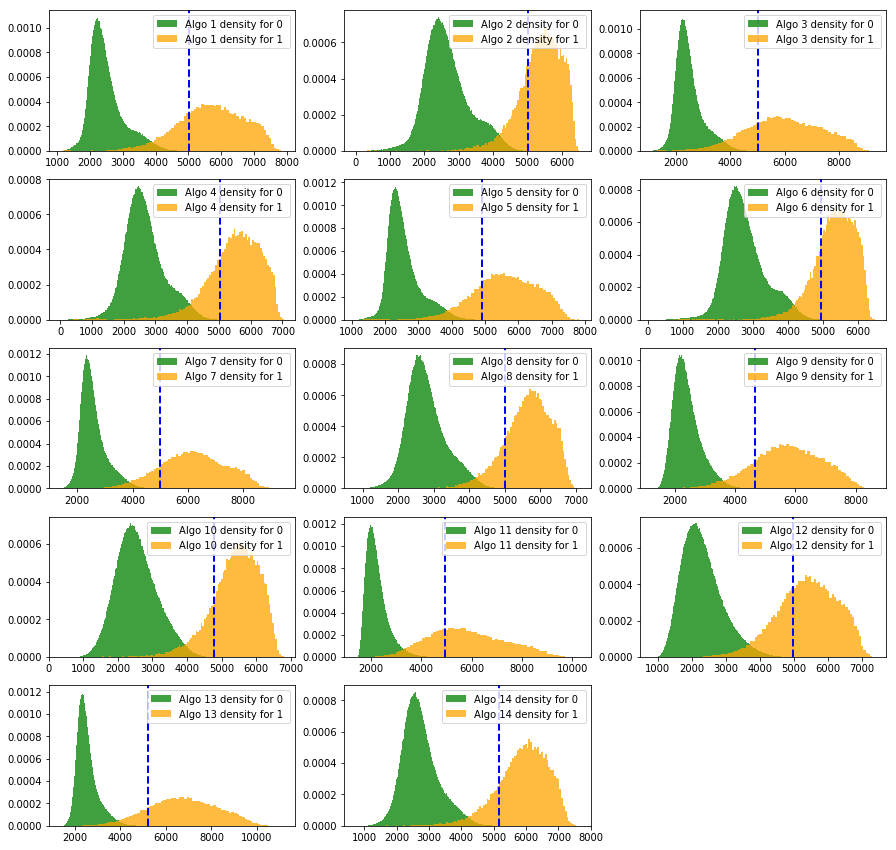

In [71]:
# Histogramms
plt.figure(figsize=(15,15))
trainset_1 = CompData[Y.values==1]
trainset_0 = CompData[Y.values==0]

for i,j in enumerate(trainset_0.columns[1:]):
    plt.subplot(5,3 , i+1)
    plt.hist(trainset_0.loc[:,j].values, bins='auto',
             density=True, facecolor='g', alpha=0.75, label='Algo '+ str(i+1) + ' density for 0 ')
    plt.hist(trainset_1.loc[:,j].values, bins='auto',
             density=True, facecolor='orange', alpha=0.75, label='Algo ' + str(i+1)+ ' density for 1') 
    plt.axvline(AgoRank.iloc[i,4], color='b', linestyle='dashed', linewidth=2)
    plt.legend()

plt.show()
  
        

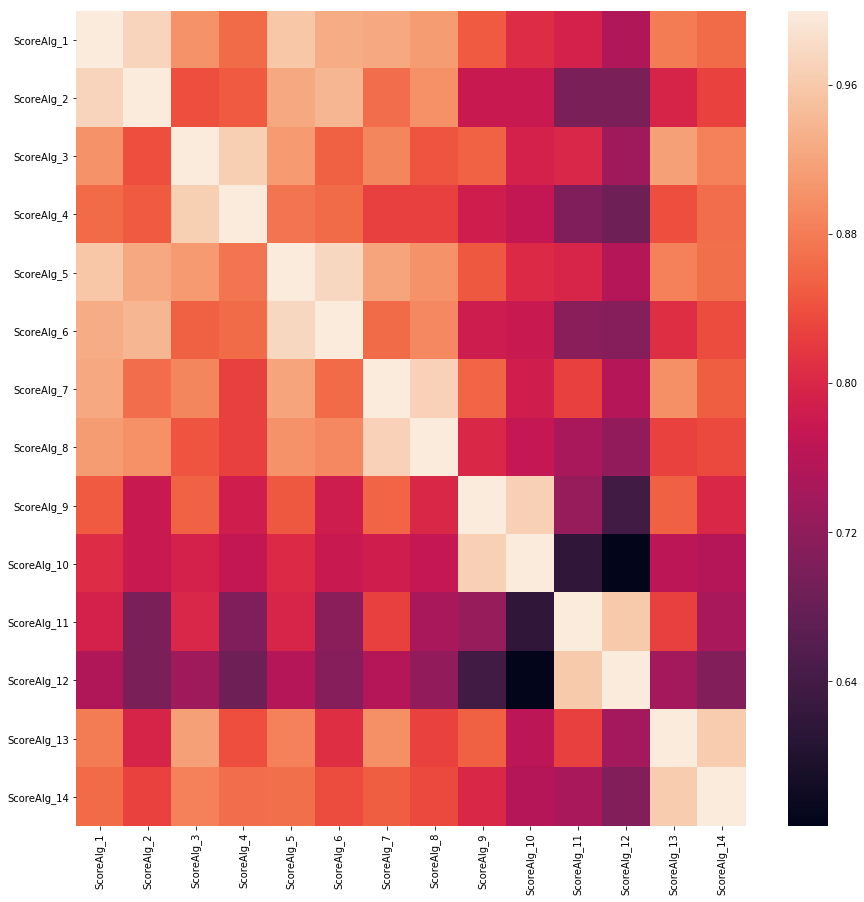

In [108]:
import seaborn as sns

plt.figure(figsize=(15,15))
Mat_corr = np.corrcoef(trainset.values[:, :], rowvar=False)
labels = trainset.columns
sns.heatmap(Mat_corr, xticklabels=labels, yticklabels=labels)


### We can see that the algorithms are corrlated two by two 1,2 ; 4,5 etc ..

In [20]:
# Split the dataset
from sklearn.model_selection import StratifiedKFold
train_index = []
test_index = []
train_2_index=[]
test_2_index =[]


skf = StratifiedKFold(n_splits=10, random_state=26, shuffle=False)
skf_2 = StratifiedKFold(n_splits=3, random_state=26, shuffle=False)
for tr_index, te_index in skf.split(trainset.values, Y.values):
    train_index.append(tr_index)
    test_index.append(te_index)

for tr_index, te_index in skf_2.split(trainset.values, Y.values):
    train_2_index.append(tr_index)
    test_2_index.append(te_index)
    
    

In [21]:
trainset.values[test_2_index[0],:].shape[0]/trainset.values.shape[0]

0.3333333333333333

### First test for Benchmark

In [113]:
#first test for Benchmark


clf = ExtraTreesClassifier(n_jobs=-1, random_state=26)
clf = clf.fit(trainset.values, Y.values)
clf.feature_importances_


array([ 0.07931476,  0.00614499,  0.09435361,  0.06303184,  0.0831395 ,
        0.01505403,  0.01783459,  0.0240213 ,  0.02036484,  0.06507597,
        0.15793423,  0.01650754,  0.18260998,  0.17461285])

In [114]:
tab = np.argsort(clf.feature_importances_)

In [115]:
print(tab[-5:])
print(clf.feature_importances_[tab[-5:]])

[ 4  2 10 13 12]
[ 0.0831395   0.09435361  0.15793423  0.17461285  0.18260998]


In [116]:
M = np.zeros((15, 15))
M[0, 12] = clf.feature_importances_[tab[-1]] / np.sum(clf.feature_importances_[tab[-4:]])
M[0, 13] = clf.feature_importances_[tab[-2]] / np.sum(clf.feature_importances_[tab[-4:]])
M[0, 10] = clf.feature_importances_[tab[-3]] / np.sum(clf.feature_importances_[tab[-4:]])
M[0, 2] = clf.feature_importances_[tab[-4]] / np.sum(clf.feature_importances_[tab[-4:]])
#M[0, 1] =clf.feature_importances_[tab[-5]] / np.sum(clf.feature_importances_[tab[-5:]])

tot_dur=compute_total_time(M)
print(tot_dur)

if(tot_dur <= alg_time_thr):
    print("The total running time of the fusion is acceptable!")
else:
    print("The total running time of the fusion is NOT acceptable!")
    

499.0
The total running time of the fusion is acceptable!


In [38]:
np.savetxt('M_pred.txt', M, fmt='%f')

### Polynomial features on the original dataset without further treatment

In [22]:
# first let's compute polynomial transformation with degree 2
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias=True)
X_pol = poly.fit_transform(trainset.values)

In [23]:
X_pol.shape

(2048343, 120)

### Feature Selection Process

In [25]:
#Corresponding matrix from poly to M(i,j)
j=0
Mtable = np.zeros((15, 15), dtype=int)
for i in range(14):
    j += 15-i
    index=[]
    rindex=[]
    rindex.append(0)
    rindex.extend(list(range(i+1,15)))
    index.append(i+1)
    index.extend(list(range(j,j+14-i)))
    Mtable[rindex,i+1 ] = index

In [26]:
# features importance to M
def MfromFeaturesImp(f):
    M = np.zeros((15, 15))
    M = f[Mtable]
    tab = np.argsort(f)
    i = 0
    while compute_total_time(M) > alg_time_thr:
        M[Mtable == tab[i]] = 0
        i += 1
    # normalise M coeffcient
    M = M / np.sum(M)
    return M

In [27]:
#Because of only 16 GB RAM on my laptop
#I will make a first pass on Lasso and ElasticNet 
#to reduce the problem dimension with the polynomial features


clf_l = LassoCV(cv=10,n_jobs=-1, random_state=26, max_iter=10**4)
clf_e = ElasticNetCV(cv=10, n_jobs=-1, random_state=26, max_iter=10**4)
clf_ll_aic = LassoLarsIC(criterion='aic', normalize=False, max_iter=10**4)
clf_ll_bic = LassoLarsIC(criterion='bic', normalize=False,  max_iter=10**4)

Xtrain = X_pol[test_index[0]]
Ytrain = Y.values[test_index[0]]


In [28]:
clf_l.fit(Xtrain, Ytrain)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=26, selection='cyclic',
    tol=0.0001, verbose=False)

In [29]:
LassoCoef = clf_l.coef_
ColToKeepPolyLasso = np.argwhere(clf_l.coef_ > abs(0.00001)).ravel()
ColToKeepPolyLasso

array([  6,   8,  10,  12,  14,  16,  20,  75,  79,  81,  83,  92,  94,
        96,  98, 105, 107, 109, 114, 116, 119])

In [30]:
clf_e.fit(Xtrain,Ytrain)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=10000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto', random_state=26,
       selection='cyclic', tol=0.0001, verbose=0)

In [31]:
ElasticNetCoef=clf_e.coef_
ColToKeepPolyElasticNet = np.argwhere(clf_e.coef_> abs(0.00001)).ravel()
ColToKeepPolyElasticNet

array([  6,   8,  10,  12,  14,  16,  20,  75,  79,  81,  83,  92,  94,
        96,  98, 105, 107, 109, 114, 116, 119])

#### We got the same features for ElasticNetCV ou LassoCV

In [48]:
clf_ll_aic.fit(Xtrain,Ytrain)
clf_ll_bic.fit(Xtrain,Ytrain)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=10000, normalize=False, positive=False,
      precompute='auto', verbose=False)

In [49]:
print('le model Lasso Lars AIC ne nous reduit pas bcp la dimension:',
      len(np.argwhere(clf_ll_aic.coef_ != 0)))
print('le model Lasso Lars BIC ne nous reduit pas bcp la dimension:',
      len(np.argwhere(clf_ll_bic.coef_ != 0)))

le model Lasso Lars AIC ne nous reduit pas bcp la dimension: 114
le model Lasso Lars BIC ne nous reduit pas bcp la dimension: 114


In [50]:
# mais peut nous donner une indiquation des coeffs les plus determinants
print('features les plus importantes pour Lasso Lars AIC:',
      np.argsort(clf_ll_aic.coef_)[-22:])
print('features les plus importantes pour Lasso Lars AIC:',
      np.argsort(clf_ll_bic.coef_ )[-22:])
c=np.argsort(clf_ll_bic.coef_ )[-22:]

features les plus importantes pour Lasso Lars AIC: [ 52  99  26  24 108  97  72  40  82 110  56  78  44  70  74  84   3 117
   9  11   7  13]
features les plus importantes pour Lasso Lars AIC: [ 52  99  26  24 108  97  72  40  82 110  56  78  44  70  74  84   3 117
   9  11   7  13]


In [51]:
#Valeurs communes :
np.intersect1d(ColToKeepPolyLasso,c)

array([], dtype=int64)

### Lasso on the original dataset without Polynomial Features

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


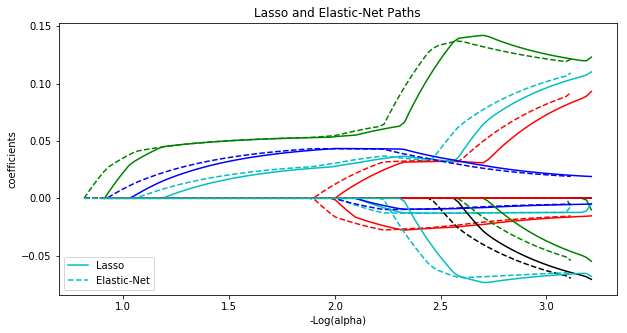

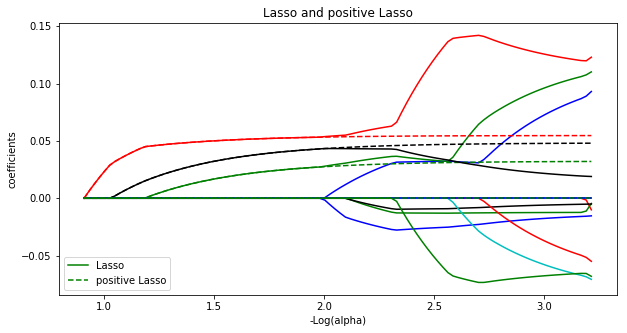

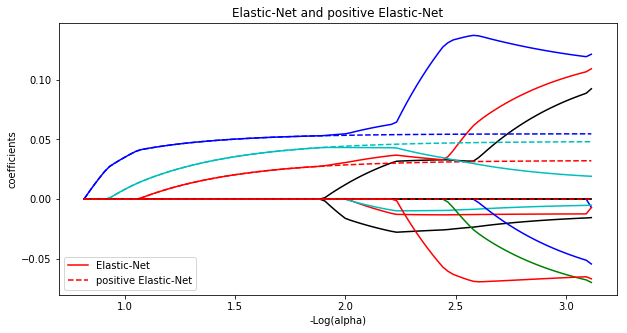

In [131]:
#Lasso Path and Elastic net on full original dataset and apply after poly
plt.figure(figsize=(10,5))
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, enet_path


X = trainset.values
y = Y.values



eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)


print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

plt.figure(figsize=(10,5))
plt.figure(2)
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')

plt.figure(figsize=(10,5))
plt.figure(3)
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [134]:
#Apply Lasso and ElasticNet on original dataset
Xtrain = trainset.values
Ytrain = Y.values
clf_l_1 = LassoCV(cv=10,n_jobs=-1, random_state=26, max_iter=10**4)
clf_e_1 = ElasticNetCV(cv=10, n_jobs=-1, random_state=26, max_iter=10**4)
clf_l_1.fit(Xtrain,Ytrain)
clf_e_1.fit(Xtrain,Ytrain)


ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=10000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto', random_state=26,
       selection='cyclic', tol=0.0001, verbose=0)

In [135]:
clf_e_1.coef_/np.sum(abs(clf_e_1.coef_))

array([-0.        , -0.01188872, -0.11245161,  0.0724016 ,  0.00247016,
       -0.0048725 ,  0.14249733, -0.09548787,  0.15005818, -0.10314371,
        0.02694301, -0.0078503 ,  0.16816549, -0.10176952])

In [136]:
clf_l_1.coef_ /np.sum(np.abs(clf_l_1.coef_))

array([-0.        , -0.01142347, -0.11609816,  0.07565187,  0.0017598 ,
       -0.00413733,  0.14182016, -0.09547578,  0.14832812, -0.10219771,
        0.02552761, -0.0071248 ,  0.16812513, -0.10233006])

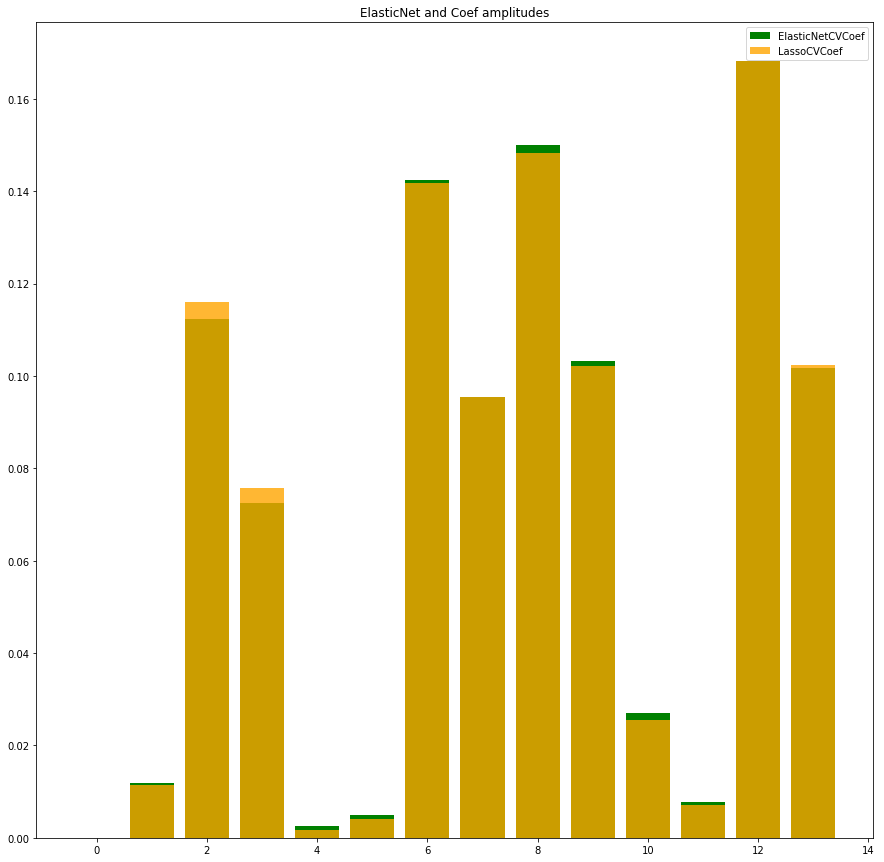

In [137]:
plt.figure(figsize=(15, 15))
plt.bar(range(len(clf_e_1.coef_)), abs(clf_e_1.coef_) /
        np.sum(np.abs(clf_e_1.coef_)), label='ElasticNetCVCoef', color='green', alpha=1)
plt.bar(range(len(clf_e_1.coef_)), abs(clf_l_1.coef_) /
        np.sum(np.abs(clf_l_1.coef_)), label='LassoCVCoef', color='orange', alpha=0.8)
plt.title('ElasticNet and Coef amplitudes')
plt.legend()
plt.show()

In [138]:
#On va garder les 8 meilleurs ce qui va reduire la dimension de 120
ColtoKeepLassoPoly = np.argsort(abs(clf_e_1.coef_))[-8:]
ColtoKeepLassoPoly

array([ 3,  7, 13,  9,  2,  6,  8, 12])

### We have initiated both appraches:
 - Polynomial Feartures -> Lasso
 - Lasso -> Polynomial Features


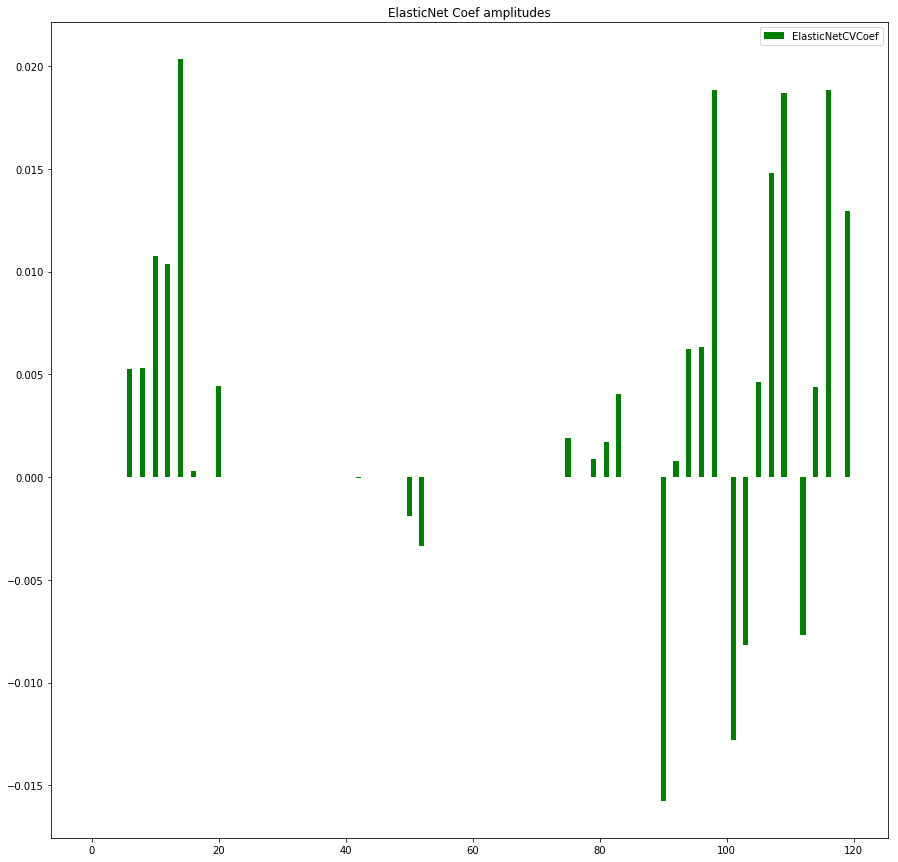

In [32]:
plt.figure(figsize=(15, 15))
plt.bar(range(len(clf_e.coef_)), ElasticNetCoef, label='ElasticNetCVCoef', color='green', alpha=1)
plt.title('ElasticNet Coef amplitudes')
plt.legend()
plt.show()

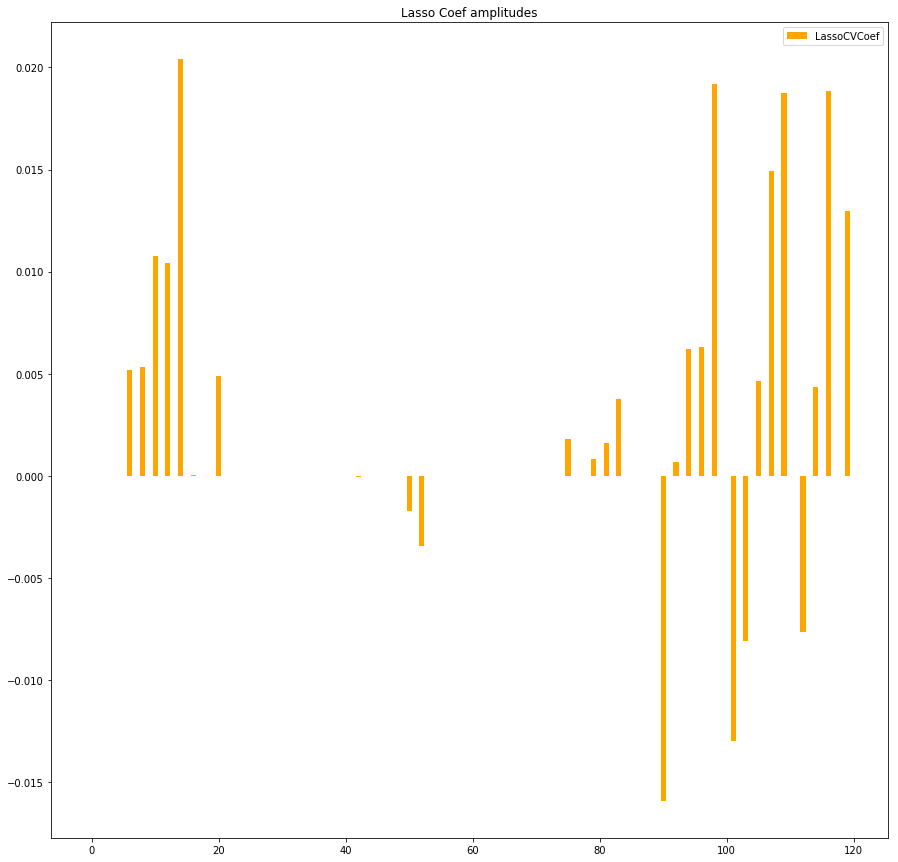

In [33]:
plt.figure(figsize=(15, 15))
plt.bar(range(len(clf_l.coef_)), LassoCoef, label='LassoCVCoef', color='orange', alpha=1)
plt.title('Lasso Coef amplitudes')
plt.legend()
plt.show()

In [43]:
np.argwhere(LassoCoef>0)

array([[  6],
       [  8],
       [ 10],
       [ 12],
       [ 14],
       [ 16],
       [ 20],
       [ 75],
       [ 79],
       [ 81],
       [ 83],
       [ 92],
       [ 94],
       [ 96],
       [ 98],
       [105],
       [107],
       [109],
       [114],
       [116],
       [119]])

In [79]:
len(np.argwhere(LassoCoef>0))

21

In [44]:
np.asarray(poly.get_feature_names())[np.argwhere(LassoCoef>0)]

array([['x5'],
       ['x7'],
       ['x9'],
       ['x11'],
       ['x13'],
       ['x0 x1'],
       ['x0 x5'],
       ['x5^2'],
       ['x5 x9'],
       ['x5 x11'],
       ['x5 x13'],
       ['x7^2'],
       ['x7 x9'],
       ['x7 x11'],
       ['x7 x13'],
       ['x9^2'],
       ['x9 x11'],
       ['x9 x13'],
       ['x11^2'],
       ['x11 x13'],
       ['x13^2']],
      dtype='<U7')

In [34]:
import re
reg = r"x(\d*)(\^)?\s?x?(\d*)?"
Mtable_1 = np.zeros((15, 15), dtype=int)

for j, i in enumerate(np.asarray(poly.get_feature_names())[np.argwhere(LassoCoef > 0)]):
    p = re.search(reg, str(i[0]))
    if p.group(2) == '^':
        Mtable_1[int(p.group(1)) + 1, int(p.group(1)) + 1] = j+1
    elif p.group(3) != '':
        Mtable_1[int(p.group(1)) + 1, int(p.group(3)) + 1] = j+1
    else:  
        Mtable_1[int(p.group(1)) + 1, 0] = j+1
print(np.argwhere(Mtable_1>0))

[[ 1  2]
 [ 1  6]
 [ 6  0]
 [ 6  6]
 [ 6 10]
 [ 6 12]
 [ 6 14]
 [ 8  0]
 [ 8  8]
 [ 8 10]
 [ 8 12]
 [ 8 14]
 [10  0]
 [10 10]
 [10 12]
 [10 14]
 [12  0]
 [12 12]
 [12 14]
 [14  0]
 [14 14]]


In [35]:
#Mapping features to M(i,j)
def MfromFeatures(f,M_table, step, dim, alg_time_thr):
    M = np.zeros((15, 15))
    g = np.zeros(dim+1, dtype=float)
    g[:step+1]=0
    g[step+1:]=f
    M = g[M_table]
    tab = np.argsort(f)
    i = 0
    while compute_total_time(M) > alg_time_thr:
        M[M_table == tab[i]] = 0
        i += 1
        if i>=len(f):
            break
            
    # normalise M coeffcient
    M = M / np.sum(M)
    return M

In [36]:
# Let s rank the features
from sklearn.linear_model import LogisticRegression

clf = ExtraTreesClassifier(n_jobs=-1, random_state=26)
X_pol = X_pol[:, ColToKeepPolyLasso]
clf.fit(X_pol, Y.values)
ColToKeepPolyLasso = np.argsort(clf.feature_importances_)
ColToKeepPolyLasso


In [37]:
ColToKeepPolyLasso

array([10,  5,  1,  0,  9, 16, 14, 20, 13,  6,  2, 19,  4,  3, 18,  7, 11,
        8, 17, 15, 12])

In [42]:
fr_f = np.zeros(((ColToKeepPolyLasso.shape[0]-2),10), dtype=float)
feat_weight = np.zeros((10 * (ColToKeepPolyLasso.shape[0]-2), ColToKeepPolyLasso.shape[0]))
Mf_l=[]
# Cross Validation 10

for j in range(ColToKeepPolyLasso.shape[0]-2):
    for i in range(10):
        Min=0
        Xtrain = X_pol[train_index[i]]
        Xtrain_f = Xtrain[:,ColToKeepPolyLasso[j:]]
        print(Xtrain_f.shape)
        del Xtrain
        Ytrain = Y.values[train_index[i]]
        Ytest = Y.values[test_index[i]]
        clf.fit(Xtrain_f, Ytrain)
        feat_weight[i + 10 * j, j:] = np.asarray(clf.feature_importances_)[:]
        Mf=MfromFeatures(np.asarray(clf.feature_importances_),Mtable_1,j,21, alg_time_thr)
        thr, fa, fr = evalModel(returnFuseVect(
            Mf, Y.iloc[test_index[i]], CompData.iloc[test_index[i], :]))
        fr_f[j,i]=fr
    print(fr_f[j,:])




(1843508, 21)
Score at FAR=0.01%
threshold : 18156130.9151 far : 9.51284233716e-05 frr : 0.0317335945152
(1843508, 21)
Score at FAR=0.01%
threshold : 26409429.9989 far : 9.51284233716e-05 frr : 0.128109696376
(1843508, 21)
Score at FAR=0.01%
threshold : 26353716.4868 far : 9.51284233716e-05 frr : 0.0284035259549
(1843508, 21)
Score at FAR=0.01%
threshold : 25898697.5414 far : 9.51284233716e-05 frr : 0.143780607248
(1843508, 21)
Score at FAR=0.01%
threshold : 18036995.359 far : 9.51284233716e-05 frr : 0.0714985308521
(1843509, 21)
Score at FAR=0.01%
threshold : 18633043.5991 far : 9.51284233716e-05 frr : 0.0333072100313
(1843509, 21)
Score at FAR=0.01%
threshold : 20265690.105 far : 9.51284233716e-05 frr : 0.0818965517241
(1843509, 21)
Score at FAR=0.01%
threshold : 27790858.9406 far : 9.51284233716e-05 frr : 0.179663009404
(1843510, 21)
Score at FAR=0.01%
threshold : 27271834.0207 far : 9.5128899659e-05 frr : 0.258228840125
(1843510, 21)
Score at FAR=0.01%
threshold : 16963530.3048 far

(1843508, 14)
Score at FAR=0.01%
threshold : 25368549.6316 far : 9.51284233716e-05 frr : 0.126738491675
(1843508, 14)
Score at FAR=0.01%
threshold : 24291533.6566 far : 9.51284233716e-05 frr : 0.0209598432909
(1843508, 14)
Score at FAR=0.01%
threshold : 22167688.1798 far : 9.51284233716e-05 frr : 0.0711067580803
(1843508, 14)
Score at FAR=0.01%
threshold : 15807989.9242 far : 9.51284233716e-05 frr : 0.0573947110676
(1843509, 14)
Score at FAR=0.01%
threshold : 16904502.031 far : 9.51284233716e-05 frr : 0.0166536050157
(1843509, 14)
Score at FAR=0.01%
threshold : 19357056.8251 far : 9.51284233716e-05 frr : 0.0679858934169
(1843509, 14)
Score at FAR=0.01%
threshold : 26524540.0367 far : 9.51284233716e-05 frr : 0.155956112853
(1843510, 14)
Score at FAR=0.01%
threshold : 24679128.1506 far : 9.5128899659e-05 frr : 0.206112852665
(1843510, 14)
Score at FAR=0.01%
threshold : 16333802.8394 far : 9.5128899659e-05 frr : 0.0192006269592
[ 0.03212537  0.12673849  0.02095984  0.07110676  0.05739471 

Score at FAR=0.01%
threshold : 23750404.6419 far : 9.51284233716e-05 frr : 0.0203721841332
(1843508, 7)
Score at FAR=0.01%
threshold : 21967789.8401 far : 9.51284233716e-05 frr : 0.0732615083252
(1843508, 7)
Score at FAR=0.01%
threshold : 15689710.8445 far : 9.51284233716e-05 frr : 0.0538687561214
(1843509, 7)
Score at FAR=0.01%
threshold : 16158980.5758 far : 9.51284233716e-05 frr : 0.0129310344828
(1843509, 7)
Score at FAR=0.01%
threshold : 19665196.1962 far : 9.51284233716e-05 frr : 0.0711206896552
(1843509, 7)
Score at FAR=0.01%
threshold : 25044253.8025 far : 9.51284233716e-05 frr : 0.131073667712
(1843510, 7)
Score at FAR=0.01%
threshold : 24413854.7076 far : 9.5128899659e-05 frr : 0.210227272727
(1843510, 7)
Score at FAR=0.01%
threshold : 14835986.5893 far : 9.5128899659e-05 frr : 0.0133228840125
[ 0.03290891  0.12419197  0.02037218  0.07326151  0.05386876  0.01293103
  0.07112069  0.13107367  0.21022727  0.01332288]
(1843508, 6)
Score at FAR=0.01%
threshold : 17213399.8646 far 

In [43]:
np.argsort(fr_f)

array([[9, 2, 0, 5, 4, 6, 1, 3, 7, 8],
       [5, 9, 2, 0, 4, 6, 3, 1, 7, 8],
       [9, 5, 2, 0, 4, 6, 3, 1, 7, 8],
       [5, 9, 2, 0, 4, 3, 6, 1, 7, 8],
       [9, 5, 2, 0, 4, 3, 6, 1, 7, 8],
       [5, 9, 2, 0, 4, 6, 3, 7, 1, 8],
       [5, 9, 2, 4, 0, 3, 6, 1, 7, 8],
       [5, 9, 2, 0, 4, 6, 3, 1, 7, 8],
       [9, 2, 5, 0, 4, 3, 6, 7, 1, 8],
       [2, 5, 9, 0, 4, 3, 6, 7, 1, 8],
       [5, 2, 9, 0, 4, 3, 6, 7, 1, 8],
       [5, 9, 2, 0, 4, 3, 6, 7, 1, 8],
       [5, 9, 2, 0, 4, 3, 6, 7, 1, 8],
       [9, 5, 2, 0, 4, 6, 3, 1, 7, 8],
       [5, 9, 2, 0, 4, 6, 3, 1, 7, 8],
       [5, 9, 2, 0, 4, 6, 3, 7, 1, 8],
       [9, 5, 2, 0, 4, 3, 6, 7, 1, 8],
       [9, 5, 2, 0, 4, 6, 3, 1, 7, 8],
       [9, 5, 2, 0, 4, 3, 6, 1, 7, 8]])

In [44]:
np.argwhere(fr_f==np.min(fr_f))

array([[10,  5]])

In [45]:
fr_f[10,5]

0.0092084639498432597

In [46]:
feat_weight[105,]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01659369,  0.01296211,  0.12115153,  0.02875913,  0.14200971,
        0.12813012,  0.15794188,  0.06519899,  0.22514482,  0.00955626,
        0.09255175])

In [48]:
M = MfromFeatures(feat_weight[135,:],Mtable_1,0,21, alg_time_thr)
thr, fa, fr = evalModel(returnFuseVect(
            M, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0],:]))

Score at FAR=0.01%
threshold : 23855808.7821 far : 9.91339299393e-05 frr : 0.0660005877167


In [49]:
#No more memory for full scoring -> i submit 10%
np.savetxt('M_pred.txt', M, fmt='%f')

In [50]:
Moy = np.mean(fr_f, axis=1)
Max = np.max(fr_f, axis=1)
Min = np.min(fr_f, axis=1)
MinMax = np.zeros((2,Moy.shape[0]))
MinMax[0,:]=Min
MinMax[1,:]=Max


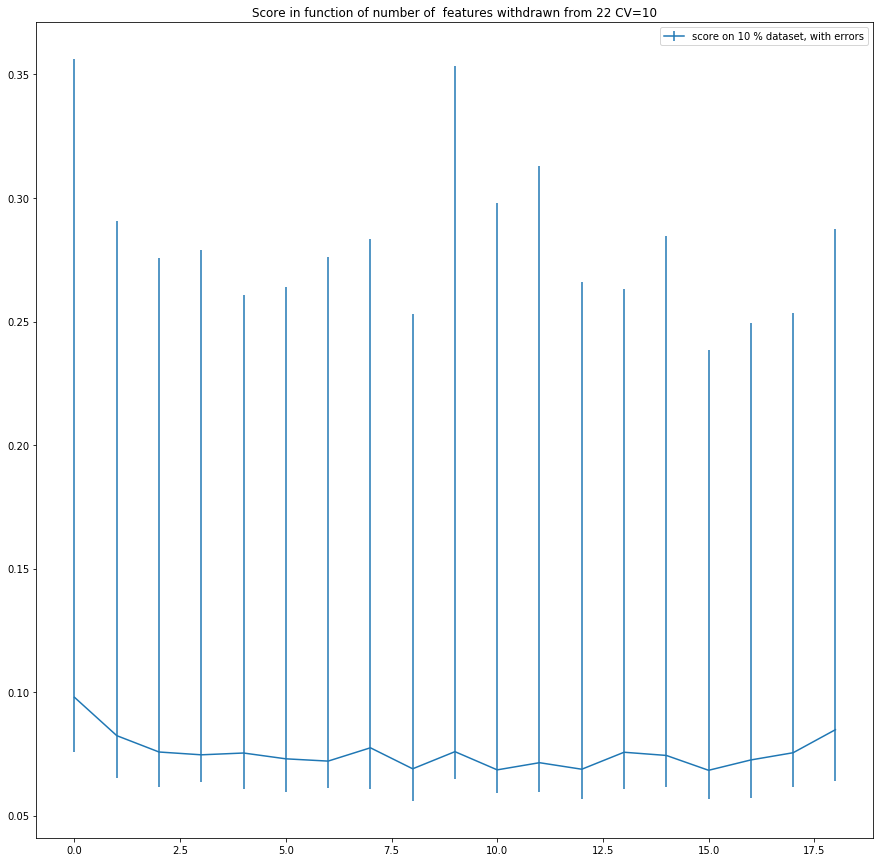

In [51]:
#plot mean FRR with errors
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(range(ColToKeepPolyLasso.shape[0]-2))
y = Moy



# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(15,15))
plt.errorbar(x, y, yerr=MinMax, label='score on 10 % dataset, with errors')
plt.title("Score in function of number of  features withdrawn from 21 CV=10")
plt.legend()
plt.show()

### We can see that because of the consraint we have a very big score variance over the Kfold

In [76]:
#Let's submit the 20 best 
d=np.argsort(fr_f, axis=1)[:,:1].ravel()

In [52]:
#index of the least score average
np.argmin(y)

15

In [78]:
for i, j in enumerate(np.argsort(fr_f, axis=1)[:, 2]):  
    M = MfromFeatures(feat_weight[j+10*i, :], Mtable_1, 0, 22, alg_time_thr)
    thr, fa, fr = evalModel(returnFuseVect(
        M, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0], :]))
    np.savetxt('M_pred_' + str(i) +'_.txt', M, fmt='%f')

Score at FAR=0.01%
threshold : 18094799.5794 far : 9.91104089956e-05 frr : 0.0667919873113
Score at FAR=0.01%
threshold : 25332253.0204 far : 9.91104089956e-05 frr : 0.0732538330494
Score at FAR=0.01%
threshold : 21692763.0981 far : 9.91104089956e-05 frr : 0.0625036715033
Score at FAR=0.01%
threshold : 16856096.7657 far : 9.91104089956e-05 frr : 0.0760148035011
Score at FAR=0.01%
threshold : 22374419.8153 far : 9.91104089956e-05 frr : 0.06132879046
Score at FAR=0.01%
threshold : 23138839.55 far : 9.91104089956e-05 frr : 0.0673206837808
Score at FAR=0.01%
threshold : 22338343.2567 far : 9.91104089956e-05 frr : 0.0655583622158
Score at FAR=0.01%
threshold : 21719881.4248 far : 9.91104089956e-05 frr : 0.080949303883
Score at FAR=0.01%
threshold : 24906249.5904 far : 9.91104089956e-05 frr : 0.0709040709628
Score at FAR=0.01%
threshold : 23401323.6588 far : 9.91104089956e-05 frr : 0.0696117018152
Score at FAR=0.01%
threshold : 24440370.2807 far : 9.91104089956e-05 frr : 0.0665570111026
Scor

## Best result for the 14th ie (lowest mean score) submission -> 0.073, we overfit a bit as we got a score of 0.0660

In [105]:
#Best result for the 14 submissions -> 0.073
M = MfromFeatures(feat_weight[132, :], Mtable_1, 0, 22, alg_time_thr)
thr, fa, fr = evalModel(returnFuseVect(
        M, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0], :]))


Score at FAR=0.01%
threshold : 21970714.5827 far : 9.91104089956e-05 frr : 0.0637372965987


In [106]:
np.argwhere(M>0)

array([[ 8, 12],
       [ 8, 14],
       [10, 10],
       [10, 12],
       [10, 14],
       [12, 12],
       [12, 14],
       [14, 14]])

In [57]:
ColToKeepPolyLasso

(21,)

### Same with CV=3

In [58]:
fr_f_cv3 = np.zeros(((ColToKeepPolyLasso.shape[0]-2),3), dtype=float)
feat_weight_cv3 = np.zeros((3 * (ColToKeepPolyLasso.shape[0]-2), ColToKeepPolyLasso.shape[0]))
Mf_l=[]
# Cross Validation 3

for j in range(ColToKeepPolyLasso.shape[0]-2):
    for i in range(3):
        Min=0
        Xtrain = X_pol[train_2_index[i]]
        Xtrain_f = Xtrain[:,ColToKeepPolyLasso[j:]]
        print(Xtrain_f.shape)
        del Xtrain
        Ytrain = Y.values[train_2_index[i]]
        Ytest = Y.values[test_2_index[i]]
        clf.fit(Xtrain_f, Ytrain)
        feat_weight_cv3[i + 3 * j, j:] = np.asarray(clf.feature_importances_)[:]
        Mf=MfromFeatures(np.asarray(clf.feature_importances_),Mtable_1,j,21, alg_time_thr)
        thr, fa, fr = evalModel(returnFuseVect(
            Mf, Y.iloc[test_2_index[i]], CompData.iloc[test_2_index[i], :]))
        fr_f_cv3[j,i]=fr
    print(fr_f_cv3[j,:])


# Plot features_scores percantile
# Plot FRR -> percentile

(1365562, 21)
Score at FAR=0.01%
threshold : 17294800.3349 far : 9.91339299393e-05 frr : 0.0645312959154
(1365562, 21)
Score at FAR=0.01%
threshold : 11025206.7307 far : 9.91339299393e-05 frr : 0.100264472524
(1365562, 21)
Score at FAR=0.01%
threshold : 17974813.7828 far : 9.91339299393e-05 frr : 0.0871583896562
[ 0.0645313   0.10026447  0.08715839]
(1365562, 20)
Score at FAR=0.01%
threshold : 20243393.2061 far : 9.91339299393e-05 frr : 0.0849250661181
(1365562, 20)
Score at FAR=0.01%
threshold : 14258894.7259 far : 9.91339299393e-05 frr : 0.0436673523362
(1365562, 20)
Score at FAR=0.01%
threshold : 17030984.3869 far : 9.91339299393e-05 frr : 0.0915662650602
[ 0.08492507  0.04366735  0.09156627]
(1365562, 19)
Score at FAR=0.01%
threshold : 14485006.0385 far : 9.91339299393e-05 frr : 0.0753452835733
(1365562, 19)
Score at FAR=0.01%
threshold : 17501558.1801 far : 9.91339299393e-05 frr : 0.0528357331766
(1365562, 19)
Score at FAR=0.01%
threshold : 19478332.5114 far : 9.91339299393e-05 fr

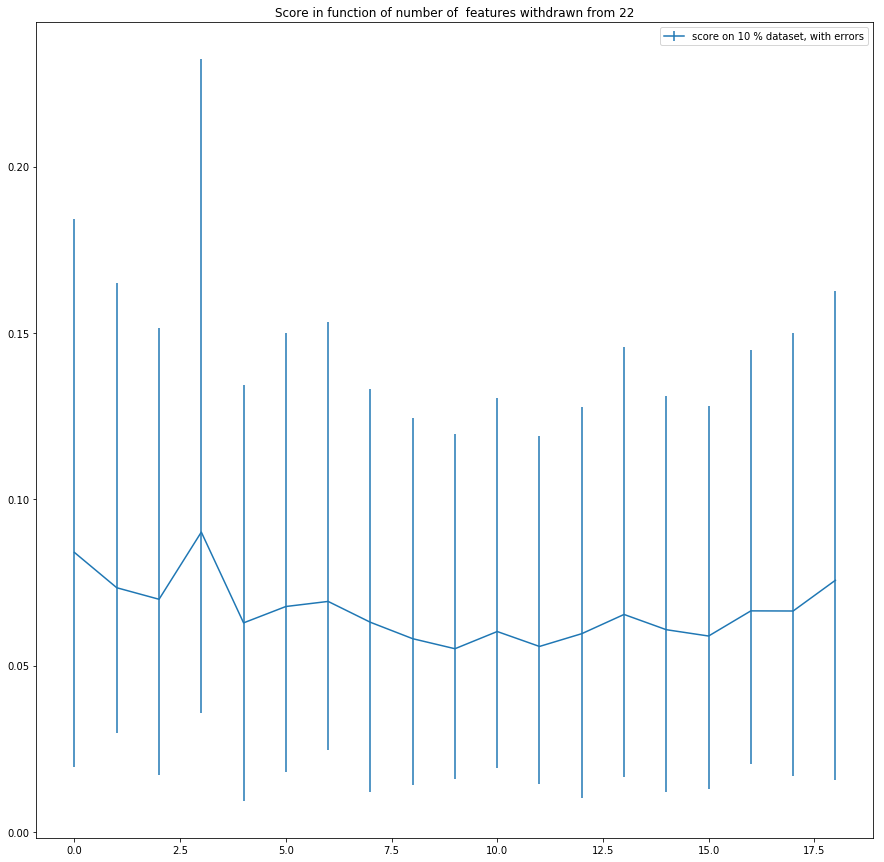

In [125]:
Moy = np.mean(fr_f_cv3, axis=1)
Max = np.max(fr_f_cv3, axis=1)
Min = np.min(fr_f_cv3, axis=1)
MinMax = np.zeros((2,Moy.shape[0]))
MinMax[0,:]=Min
MinMax[1,:]=Max
#plot scores nb colonnes ( candlestick)
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(range(ColToKeepPolyLasso.shape[0]-2))
y = Moy


# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(15,15))
plt.errorbar(x, y, yerr=MinMax, label='score on 10 % dataset, with errors')
plt.title("Score in function of number of  features withdrawn from 22")
plt.legend()
plt.show()


In [62]:
for i, j in enumerate(np.argsort(fr_f_cv3, axis=1)[:, 2]):  
    M = MfromFeatures(feat_weight_cv3[j+3*i, :], Mtable_1, 0, 21, alg_time_thr)
    thr, fa, fr = evalModel(returnFuseVect(
        M, Y.iloc[test_2_index[1]], CompData.iloc[test_2_index[1], :]))
    np.savetxt('M_pred_cv3_PL' + str(i) +'_.txt', M, fmt='%f')

Score at FAR=0.01%
threshold : 11025206.7307 far : 9.91339299393e-05 frr : 0.100264472524
Score at FAR=0.01%
threshold : 15191509.9014 far : 9.91339299393e-05 frr : 0.0654716426682
Score at FAR=0.01%
threshold : 19180723.7426 far : 9.91339299393e-05 frr : 0.0925066118131
Score at FAR=0.01%
threshold : 9259599.42968 far : 9.91339299393e-05 frr : 0.0726417866588
Score at FAR=0.01%
threshold : 16533033.6689 far : 9.91339299393e-05 frr : 0.0457831325301
Score at FAR=0.01%
threshold : 18683312.5837 far : 9.91339299393e-05 frr : 0.0666470761093
Score at FAR=0.01%
threshold : 17089922.2655 far : 9.91339299393e-05 frr : 0.0527181898325
Score at FAR=0.01%
threshold : 17295133.3033 far : 9.91339299393e-05 frr : 0.0595944754628
Score at FAR=0.01%
threshold : 17460303.9477 far : 9.91339299393e-05 frr : 0.0429620922715
Score at FAR=0.01%
threshold : 18523425.9761 far : 9.91339299393e-05 frr : 0.0577725536292
Score at FAR=0.01%
threshold : 19169383.4831 far : 9.91339299393e-05 frr : 0.0622979723773


In [173]:
# the eleventh gives us the best score 0.071
# that matches the fact that it has the lowest mean fr 
M = MfromFeatures(feat_weight_cv3[3 * 11, :], Mtable_1, 0, 21, alg_time_thr)
thr, fa, fr = evalModel(returnFuseVect(
    M, Y.iloc[test_2_index[2]], CompData.iloc[test_2_index[2], :]))

MemoryError: 

In [175]:
M[8:15,:]


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.02205378,  0.        ,
         0.19841946,  0.        ,  0.13243688,  0.        ,  0.06962653],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.22604028,  0.        ,  0.0592488 ,  0.        ,  0.06303812],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 

### Now let's optimize my coefficients

In [78]:
def MeanScoreCV(M,cv):
    if cv == 3 :
        fr = np.zeros((3))
        for i in range(3):
            thr, fa, fr[i] = evalModel(returnFuseVect(
                M, Y.iloc[test_2_index[i]], CompData.iloc[test_2_index[i], :]))
    else:
        fr = np.zeros((10))
        for i in range(10):
            thr, fa, fr[i] = evalModel(returnFuseVect(
                M, Y.iloc[test_index[i]], CompData.iloc[test_index[i], :]))
    print('##done: ',np.mean(fr))
    return np.mean(fr)


In [177]:
np.argwhere(M>0)

array([[ 8,  8],
       [ 8, 10],
       [ 8, 12],
       [ 8, 14],
       [10, 10],
       [10, 12],
       [10, 14],
       [12, 12],
       [14, 14]])

In [178]:
def ScoreToMinimize(x):
    M= np.zeros((15,15), dtype=float)
    M[8,8]=x[0]
    M[8,10]=x[1]
    M[8,12]=x[2]
    M[8,14]=x[3]
    M[10,10]=x[4]
    M[10,12]=x[5]
    M[10,14]=x[6]
    M[12,12]=x[7]
    M[14,14]=x[8]
    
    M/=np.sum(M)
    return MeanScoreCV(M,10)


In [179]:
x0 = np.array([M[8, 8], M[8, 10], M[8, 12], M[8, 14],
               M[10, 10], M[10, 12], M[10, 14], M[12, 12], M[14, 14] ])
x0.dtype=float
res = minimize(ScoreToMinimize, x0, method='Nelder-Mead', tol=1e-6)

Score at FAR=0.01%
threshold : 16621848.1562 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24081222.0887 far : 9.51284233716e-05 frr : 0.124779627816
Score at FAR=0.01%
threshold : 22497583.2602 far : 9.51284233716e-05 frr : 0.0105778648384
Score at FAR=0.01%
threshold : 20754239.963 far : 9.51284233716e-05 frr : 0.0552399608227
Score at FAR=0.01%
threshold : 14941311.7819 far : 9.51284233716e-05 frr : 0.0444662095984
Score at FAR=0.01%
threshold : 15605897.441 far : 9.51284233716e-05 frr : 0.0121473354232
Score at FAR=0.01%
threshold : 18584430.9403 far : 9.51284233716e-05 frr : 0.0658307210031
Score at FAR=0.01%
threshold : 23480413.2224 far : 9.51284233716e-05 frr : 0.10775862069
Score at FAR=0.01%
threshold : 23907067.7829 far : 9.5128899659e-05 frr : 0.220415360502
Score at FAR=0.01%
threshold : 14978664.2834 far : 9.5128899659e-05 frr : 0.0141065830721
##done:  0.0685880559965
Score at FAR=0.01%
threshold : 16623527.8882 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 14930591.0413 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0683921120421
Score at FAR=0.01%
threshold : 16615545.215 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24089346.051 far : 9.51284233716e-05 frr : 0.124191968658
Score at FAR=0.01%
threshold : 22500524.9859 far : 9.51284233716e-05 frr : 0.0105778648384
Score at FAR=0.01%
threshold : 20782310.4859 far : 9.51284233716e-05 frr : 0.0554358472086
Score at FAR=0.01%
threshold : 14964350.2333 far : 9.51284233716e-05 frr : 0.0446620959843
Score at FAR=0.01%
threshold : 15615320.5621 far : 9.51284233716e-05 frr : 0.0121473354232
Score at FAR=0.01%
threshold : 18607899.7449 far : 9.51284233716e-05 frr : 0.0658307210031
Score at FAR=0.01%
threshold : 23514895.2672 far : 9.51284233716e-05 frr : 0.108346394984
Score at FAR=0.01%
threshold : 23915653.272 far : 9.5128899659e-05 frr : 0.220415360502
Score at FAR=0.01%
threshold : 14973649.8781 far : 9.5128899659e-05 frr :

Score at FAR=0.01%
threshold : 23825295.6975 far : 9.5128899659e-05 frr : 0.218260188088
Score at FAR=0.01%
threshold : 14869923.6977 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0678631382043
Score at FAR=0.01%
threshold : 16659149.2244 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 24033488.1023 far : 9.51284233716e-05 frr : 0.124779627816
Score at FAR=0.01%
threshold : 22443294.2823 far : 9.51284233716e-05 frr : 0.0115572967679
Score at FAR=0.01%
threshold : 20733573.0349 far : 9.51284233716e-05 frr : 0.0552399608227
Score at FAR=0.01%
threshold : 14879244.6259 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15428606.2438 far : 9.51284233716e-05 frr : 0.0099921630094
Score at FAR=0.01%
threshold : 18498617.6074 far : 9.51284233716e-05 frr : 0.0646551724138
Score at FAR=0.01%
threshold : 23366548.1434 far : 9.51284233716e-05 frr : 0.104427899687
Score at FAR=0.01%
threshold : 23781470.5125 far : 9.5128899659e-05 fr

Score at FAR=0.01%
threshold : 23379792.6254 far : 9.51284233716e-05 frr : 0.104427899687
Score at FAR=0.01%
threshold : 23800432.7038 far : 9.5128899659e-05 frr : 0.217868338558
Score at FAR=0.01%
threshold : 14744688.0591 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.067490881151
Score at FAR=0.01%
threshold : 16638588.9996 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 23985550.1136 far : 9.51284233716e-05 frr : 0.123996082272
Score at FAR=0.01%
threshold : 22440107.3738 far : 9.51284233716e-05 frr : 0.0115572967679
Score at FAR=0.01%
threshold : 20755785.7943 far : 9.51284233716e-05 frr : 0.0556317335945
Score at FAR=0.01%
threshold : 14828830.6782 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15392036.2389 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18437875.0065 far : 9.51284233716e-05 frr : 0.0640673981191
Score at FAR=0.01%
threshold : 23359180.9142 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 18449801.5391 far : 9.51284233716e-05 frr : 0.0638714733542
Score at FAR=0.01%
threshold : 23363460.5303 far : 9.51284233716e-05 frr : 0.104036050157
Score at FAR=0.01%
threshold : 23765642.613 far : 9.5128899659e-05 frr : 0.216105015674
Score at FAR=0.01%
threshold : 14738911.7519 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0672949487103
Score at FAR=0.01%
threshold : 16637842.5341 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24006200.3887 far : 9.51284233716e-05 frr : 0.123996082272
Score at FAR=0.01%
threshold : 22456490.1932 far : 9.51284233716e-05 frr : 0.0115572967679
Score at FAR=0.01%
threshold : 20785743.5668 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14830199.9508 far : 9.51284233716e-05 frr : 0.0432908912831
Score at FAR=0.01%
threshold : 15442959.0061 far : 9.51284233716e-05 frr : 0.0099921630094
Score at FAR=0.01%
threshold : 18449255.4591 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15471038.0691 far : 9.51284233716e-05 frr : 0.010775862069
Score at FAR=0.01%
threshold : 18519397.8511 far : 9.51284233716e-05 frr : 0.0646551724138
Score at FAR=0.01%
threshold : 23384591.2519 far : 9.51284233716e-05 frr : 0.104819749216
Score at FAR=0.01%
threshold : 23788960.0592 far : 9.5128899659e-05 frr : 0.217280564263
Score at FAR=0.01%
threshold : 14843576.7282 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0675496854458
Score at FAR=0.01%
threshold : 16652073.0546 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 23985000.5625 far : 9.51284233716e-05 frr : 0.123800195886
Score at FAR=0.01%
threshold : 22445918.8005 far : 9.51284233716e-05 frr : 0.0115572967679
Score at FAR=0.01%
threshold : 20765399.3515 far : 9.51284233716e-05 frr : 0.0558276199804
Score at FAR=0.01%
threshold : 14850151.1902 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15390505.1236 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 14838533.6773 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15406174.2797 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18449919.9007 far : 9.51284233716e-05 frr : 0.0638714733542
Score at FAR=0.01%
threshold : 23345362.7151 far : 9.51284233716e-05 frr : 0.103840125392
Score at FAR=0.01%
threshold : 23758892.9798 far : 9.5128899659e-05 frr : 0.216300940439
Score at FAR=0.01%
threshold : 14735746.1465 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0672949487103
Score at FAR=0.01%
threshold : 16635894.4454 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 23985368.5129 far : 9.51284233716e-05 frr : 0.123408423115
Score at FAR=0.01%
threshold : 22451260.6842 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20789689.8794 far : 9.51284233716e-05 frr : 0.0558276199804
Score at FAR=0.01%
threshold : 14837694.1628 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 20752708.5219 far : 9.51284233716e-05 frr : 0.0560235063663
Score at FAR=0.01%
threshold : 14798422.6996 far : 9.51284233716e-05 frr : 0.0440744368266
Score at FAR=0.01%
threshold : 15378323.7279 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18482721.12 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23321938.6461 far : 9.51284233716e-05 frr : 0.103448275862
Score at FAR=0.01%
threshold : 23663019.829 far : 9.5128899659e-05 frr : 0.211990595611
Score at FAR=0.01%
threshold : 14719500.225 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0669422726198
Score at FAR=0.01%
threshold : 16614508.432 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 24027706.6072 far : 9.51284233716e-05 frr : 0.123996082272
Score at FAR=0.01%
threshold : 22470916.32 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20755989.9407 far : 9.51284233716e-05 frr : 0.0

Score at FAR=0.01%
threshold : 22468713.6462 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20759672.3665 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14807984.4082 far : 9.51284233716e-05 frr : 0.0440744368266
Score at FAR=0.01%
threshold : 15390132.5454 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18496430.6974 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23353244.9164 far : 9.51284233716e-05 frr : 0.103448275862
Score at FAR=0.01%
threshold : 23686800.0067 far : 9.5128899659e-05 frr : 0.211990595611
Score at FAR=0.01%
threshold : 14710287.7079 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.066981449897
Score at FAR=0.01%
threshold : 16612665.5388 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24032053.7425 far : 9.51284233716e-05 frr : 0.123996082272
Score at FAR=0.01%
threshold : 22472360.0596 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 24021313.0437 far : 9.51284233716e-05 frr : 0.123800195886
Score at FAR=0.01%
threshold : 22466006.486 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20763173.3325 far : 9.51284233716e-05 frr : 0.0560235063663
Score at FAR=0.01%
threshold : 14823318.3648 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412731.0209 far : 9.51284233716e-05 frr : 0.0099921630094
Score at FAR=0.01%
threshold : 18458403.0465 far : 9.51284233716e-05 frr : 0.0640673981191
Score at FAR=0.01%
threshold : 23350177.528 far : 9.51284233716e-05 frr : 0.103448275862
Score at FAR=0.01%
threshold : 23687482.0371 far : 9.5128899659e-05 frr : 0.212578369906
Score at FAR=0.01%
threshold : 14734771.3894 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0669031068563
Score at FAR=0.01%
threshold : 16630169.1043 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24004693.2942 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 16611621.0543 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24035736.8966 far : 9.51284233716e-05 frr : 0.124387855044
Score at FAR=0.01%
threshold : 22472389.9531 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20763573.308 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14803151.7905 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15377468.0195 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18509430.92 far : 9.51284233716e-05 frr : 0.0644592476489
Score at FAR=0.01%
threshold : 23347555.3876 far : 9.51284233716e-05 frr : 0.103448275862
Score at FAR=0.01%
threshold : 23659984.0545 far : 9.5128899659e-05 frr : 0.211598746082
Score at FAR=0.01%
threshold : 14715782.92 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0669030915047
Score at FAR=0.01%
threshold : 16612612.9563 far : 9.51284233716e-05 frr : 

Score at FAR=0.01%
threshold : 14724352.3251 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0668834798387
Score at FAR=0.01%
threshold : 16594283.0915 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24066993.7514 far : 9.51284233716e-05 frr : 0.124975514202
Score at FAR=0.01%
threshold : 22485956.2958 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20787971.361 far : 9.51284233716e-05 frr : 0.0570029382958
Score at FAR=0.01%
threshold : 14816121.6076 far : 9.51284233716e-05 frr : 0.0442703232125
Score at FAR=0.01%
threshold : 15412281.0038 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18557562.979 far : 9.51284233716e-05 frr : 0.0652429467085
Score at FAR=0.01%
threshold : 23354812.5601 far : 9.51284233716e-05 frr : 0.104036050157
Score at FAR=0.01%
threshold : 23628721.7281 far : 9.5128899659e-05 frr : 0.209051724138
Score at FAR=0.01%
threshold : 14734598.5505 far : 9.5128899659e-05 frr :

Score at FAR=0.01%
threshold : 23669185.3302 far : 9.5128899659e-05 frr : 0.210815047022
Score at FAR=0.01%
threshold : 14725998.0322 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0668247215988
Score at FAR=0.01%
threshold : 16599633.7357 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24065300.2611 far : 9.51284233716e-05 frr : 0.124975514202
Score at FAR=0.01%
threshold : 22484517.1568 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20787554.5559 far : 9.51284233716e-05 frr : 0.0568070519099
Score at FAR=0.01%
threshold : 14821519.0373 far : 9.51284233716e-05 frr : 0.0440744368266
Score at FAR=0.01%
threshold : 15420349.8475 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18532295.0569 far : 9.51284233716e-05 frr : 0.0646551724138
Score at FAR=0.01%
threshold : 23363723.7571 far : 9.51284233716e-05 frr : 0.103840125392
Score at FAR=0.01%
threshold : 23650226.3017 far : 9.5128899659e-05 frr

Score at FAR=0.01%
threshold : 23353195.6679 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23649955.2975 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14724883.2592 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667855251321
Score at FAR=0.01%
threshold : 16612544.0183 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24034236.2868 far : 9.51284233716e-05 frr : 0.124387855044
Score at FAR=0.01%
threshold : 22472381.1322 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20761461.5411 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14811788.9852 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15393067.0161 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18494184.5306 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23346750.1259 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 18506915.7054 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23356582.1962 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23659099.4543 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14730319.8963 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667659326556
Score at FAR=0.01%
threshold : 16610047.8276 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24044351.6517 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22475985.7394 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20770285.7618 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14816698.6991 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15407138.0577 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18496502.3082 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 15412570.6633 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18505957.3767 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23357443.5353 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23660879.0257 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14731260.66 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.066746344017
Score at FAR=0.01%
threshold : 16607549.8481 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24054417.4145 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22479314.3324 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20779697.0923 far : 9.51284233716e-05 frr : 0.0564152791381
Score at FAR=0.01%
threshold : 14818504.9894 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15411056.2867 far : 9.51284233716e-05 frr : 

Score at FAR=0.01%
threshold : 14817916.2906 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15413576.6529 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18507189.8871 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23358982.3538 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23660865.5782 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732229.9826 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667267553784
Score at FAR=0.01%
threshold : 16607962.9613 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24049336.2903 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22477874.5479 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20774602.757 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14816874.1982 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 20774653.8199 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14816429.6448 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15410957.9053 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18507609.2505 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23357289.0652 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23658879.8023 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14730683.1668 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667659326556
Score at FAR=0.01%
threshold : 16607248.564 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24049859.391 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478170.8772 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20774909.0198 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 22478605.1345 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20776350.6858 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14818033.5403 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 15413900.0583 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18505777.6792 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23360109.4626 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661872.4883 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732529.2483 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667267553784
Score at FAR=0.01%
threshold : 16607126.0432 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24051782.8822 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478758.382 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 24052343.3146 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478899.5641 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777330.7288 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14818291.6923 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15414263.9333 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506008.2175 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361511.7099 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23662119.1915 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14733171.6256 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607497.3924 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052315.7704 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 16607402.9821 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24051991.8932 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478747.1261 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777068.0678 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817812.0688 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15413349.9164 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506036.2976 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361360.8399 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661589.4323 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732785.9542 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607437.2286 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 14732745.7234 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607445.896 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052182.6664 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478783.8593 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777287.0715 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817676.0079 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15413051.6305 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506188.5498 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361756.8216 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661385.2285 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732824.3567 far : 9.5128899659e-05 frr :

Score at FAR=0.01%
threshold : 23661404.0914 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732858.2606 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607425.3211 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052306.8848 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478818.5309 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777413.4541 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817623.1941 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412965.3032 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506375.4462 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361911.6836 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661225.4333 far : 9.5128899659e-05 frr 

Score at FAR=0.01%
threshold : 23361936.1817 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661182.6762 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732878.632 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607377.4812 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052340.8103 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478837.2965 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777434.9713 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817614.7761 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412982.6146 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506547.2324 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361866.3135 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 18506487.1827 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361813.2368 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661096.13 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732801.9248 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607377.0143 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052363.8818 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478844.6884 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777455.4514 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817641.7596 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15413036.0562 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506523.7905 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 15412978.9039 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506525.549 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361882.9096 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661115.9029 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732853.097 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607387.4341 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052342.8994 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478834.5457 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777441.4989 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817601.5107 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412957.6067 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 14817603.2615 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412960.2533 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506535.0735 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361907.6692 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661103.1313 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732855.4985 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607384.5739 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052354.2586 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478838.2403 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777452.1098 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817603.5743 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 20777460.6252 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817599.9601 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412954.8573 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506546.7567 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361917.349 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661093.1424 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732857.3561 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607384.111 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052353.3722 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478838.0999 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777451.1149 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 22478840.7952 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777461.9701 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817599.434 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412955.9393 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506557.4934 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361914.5133 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661085.6665 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732857.1713 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607386.6994 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052361.1709 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478839.4483 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 24052365.1678 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478841.2572 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777463.2501 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817601.1205 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412959.2795 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506556.0282 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361916.14 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661088.3672 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732858.8021 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607384.5563 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052365.0602 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 16607384.3214 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24052363.8564 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 22478840.6232 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20777462.3781 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14817598.6049 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15412954.3763 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18506556.6847 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 23361915.9773 far : 9.51284233716e-05 frr : 0.103644200627
Score at FAR=0.01%
threshold : 23661085.3377 far : 9.5128899659e-05 frr : 0.209639498433
Score at FAR=0.01%
threshold : 14732857.015 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0667071667398
Score at FAR=0.01%
threshold : 16607384.6801 far : 9.51284233716e-05 frr 

In [180]:
x =res.x
Mopt= np.zeros((15,15), dtype=float)
Mopt[8,8]=x[0]
Mopt[8,10]=x[1]
Mopt[8,12]=x[2]
Mopt[8,14]=x[3]
Mopt[10,10]=x[4]
Mopt[10,12]=x[5]
Mopt[10,14]=x[6]
Mopt[12,12]=x[7]
Mopt[14,14]=x[8]
np.savetxt('M_pred_opt_4.txt', Mopt, fmt='%f') 

### give us a worst score than before -> we  overfeet a little bit 0.0719 from 0.071

In [183]:
# let's try to see the distribution of our score function
xrand = np.zeros((500, 9))
score = np.zeros(500)
for i in range(500):
    xrand[i] = np.random.rand(9)
    xrand[i] /= np.sum(xrand[i])
    score[i] = ScoreToMinimize(xrand[i])


Score at FAR=0.01%
threshold : 16360960.2434 far : 9.51284233716e-05 frr : 0.0295788442703
Score at FAR=0.01%
threshold : 24109906.7181 far : 9.51284233716e-05 frr : 0.122233104799
Score at FAR=0.01%
threshold : 22916914.8164 far : 9.51284233716e-05 frr : 0.0156709108717
Score at FAR=0.01%
threshold : 21632384.692 far : 9.51284233716e-05 frr : 0.0564152791381
Score at FAR=0.01%
threshold : 15431749.5545 far : 9.51284233716e-05 frr : 0.0397649363369
Score at FAR=0.01%
threshold : 16332016.4905 far : 9.51284233716e-05 frr : 0.0133228840125
Score at FAR=0.01%
threshold : 18609553.9786 far : 9.51284233716e-05 frr : 0.0652429467085
Score at FAR=0.01%
threshold : 24432086.7029 far : 9.51284233716e-05 frr : 0.122061128527
Score at FAR=0.01%
threshold : 25480208.7786 far : 9.5128899659e-05 frr : 0.275274294671
Score at FAR=0.01%
threshold : 15292632.6297 far : 9.5128899659e-05 frr : 0.0150862068966
##done:  0.0754650536231
Score at FAR=0.01%
threshold : 17508737.2906 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15347248.712 far : 9.5128899659e-05 frr : 0.0150862068966
##done:  0.0725849212002
Score at FAR=0.01%
threshold : 17074336.8693 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24747390.3871 far : 9.51284233716e-05 frr : 0.119490695397
Score at FAR=0.01%
threshold : 23569569.0249 far : 9.51284233716e-05 frr : 0.0172380019589
Score at FAR=0.01%
threshold : 21643565.0153 far : 9.51284233716e-05 frr : 0.0575905974535
Score at FAR=0.01%
threshold : 15537817.4748 far : 9.51284233716e-05 frr : 0.0444662095984
Score at FAR=0.01%
threshold : 16525997.9821 far : 9.51284233716e-05 frr : 0.0135188087774
Score at FAR=0.01%
threshold : 18832120.378 far : 9.51284233716e-05 frr : 0.0615203761755
Score at FAR=0.01%
threshold : 25387346.4908 far : 9.51284233716e-05 frr : 0.138126959248
Score at FAR=0.01%
threshold : 25077726.0745 far : 9.5128899659e-05 frr : 0.238636363636
Score at FAR=0.01%
threshold : 15481719.7937 far : 9.5128899659e-05 frr 

Score at FAR=0.01%
threshold : 25114680.785 far : 9.5128899659e-05 frr : 0.236089341693
Score at FAR=0.01%
threshold : 15522959.1281 far : 9.5128899659e-05 frr : 0.0144984326019
##done:  0.0746615241373
Score at FAR=0.01%
threshold : 16660029.9497 far : 9.51284233716e-05 frr : 0.0299706170421
Score at FAR=0.01%
threshold : 24551701.1873 far : 9.51284233716e-05 frr : 0.127717923604
Score at FAR=0.01%
threshold : 22716143.0674 far : 9.51284233716e-05 frr : 0.0129285014691
Score at FAR=0.01%
threshold : 21023244.0221 far : 9.51284233716e-05 frr : 0.0556317335945
Score at FAR=0.01%
threshold : 15041588.4143 far : 9.51284233716e-05 frr : 0.0432908912831
Score at FAR=0.01%
threshold : 15781571.3404 far : 9.51284233716e-05 frr : 0.0113636363636
Score at FAR=0.01%
threshold : 18729546.6133 far : 9.51284233716e-05 frr : 0.0650470219436
Score at FAR=0.01%
threshold : 24215371.2777 far : 9.51284233716e-05 frr : 0.119514106583
Score at FAR=0.01%
threshold : 24217839.9955 far : 9.5128899659e-05 frr

Score at FAR=0.01%
threshold : 25726191.574 far : 9.51284233716e-05 frr : 0.144396551724
Score at FAR=0.01%
threshold : 25284249.7614 far : 9.5128899659e-05 frr : 0.24118338558
Score at FAR=0.01%
threshold : 15722948.0326 far : 9.5128899659e-05 frr : 0.0154780564263
##done:  0.0759937434564
Score at FAR=0.01%
threshold : 16801858.1083 far : 9.51284233716e-05 frr : 0.0317335945152
Score at FAR=0.01%
threshold : 24547018.9602 far : 9.51284233716e-05 frr : 0.131635651322
Score at FAR=0.01%
threshold : 22460641.6678 far : 9.51284233716e-05 frr : 0.0105778648384
Score at FAR=0.01%
threshold : 20871556.6049 far : 9.51284233716e-05 frr : 0.0589618021548
Score at FAR=0.01%
threshold : 14962214.5993 far : 9.51284233716e-05 frr : 0.0515181194907
Score at FAR=0.01%
threshold : 15517137.0963 far : 9.51284233716e-05 frr : 0.0117554858934
Score at FAR=0.01%
threshold : 18637069.0708 far : 9.51284233716e-05 frr : 0.0650470219436
Score at FAR=0.01%
threshold : 23484360.5311 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 18944072.3825 far : 9.51284233716e-05 frr : 0.0721003134796
Score at FAR=0.01%
threshold : 24040574.7158 far : 9.51284233716e-05 frr : 0.117946708464
Score at FAR=0.01%
threshold : 25086276.0689 far : 9.5128899659e-05 frr : 0.263322884013
Score at FAR=0.01%
threshold : 15335033.7432 far : 9.5128899659e-05 frr : 0.0154780564263
##done:  0.0745834228843
Score at FAR=0.01%
threshold : 16269201.7039 far : 9.51284233716e-05 frr : 0.0319294809011
Score at FAR=0.01%
threshold : 23264967.1592 far : 9.51284233716e-05 frr : 0.123016650343
Score at FAR=0.01%
threshold : 23013769.3966 far : 9.51284233716e-05 frr : 0.0174338883448
Score at FAR=0.01%
threshold : 21377270.6911 far : 9.51284233716e-05 frr : 0.0595494613124
Score at FAR=0.01%
threshold : 15185404.2659 far : 9.51284233716e-05 frr : 0.0331047992165
Score at FAR=0.01%
threshold : 15826475.3349 far : 9.51284233716e-05 frr : 0.014302507837
Score at FAR=0.01%
threshold : 18198454.9921 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15822511.2669 far : 9.51284233716e-05 frr : 0.0113636363636
Score at FAR=0.01%
threshold : 18452652.826 far : 9.51284233716e-05 frr : 0.060736677116
Score at FAR=0.01%
threshold : 23955803.0528 far : 9.51284233716e-05 frr : 0.113048589342
Score at FAR=0.01%
threshold : 24535856.3587 far : 9.5128899659e-05 frr : 0.239615987461
Score at FAR=0.01%
threshold : 14798681.6643 far : 9.5128899659e-05 frr : 0.0129310344828
##done:  0.0709586228389
Score at FAR=0.01%
threshold : 17186770.3287 far : 9.51284233716e-05 frr : 0.0313418217434
Score at FAR=0.01%
threshold : 24717033.8337 far : 9.51284233716e-05 frr : 0.123016650343
Score at FAR=0.01%
threshold : 23101039.7823 far : 9.51284233716e-05 frr : 0.0142997061704
Score at FAR=0.01%
threshold : 21153861.1519 far : 9.51284233716e-05 frr : 0.056611165524
Score at FAR=0.01%
threshold : 15538615.4183 far : 9.51284233716e-05 frr : 0.052889324192
Score at FAR=0.01%
threshold : 16245615.0022 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 14756287.2921 far : 9.51284233716e-05 frr : 0.0376101860921
Score at FAR=0.01%
threshold : 15483803.4476 far : 9.51284233716e-05 frr : 0.010775862069
Score at FAR=0.01%
threshold : 18410413.5795 far : 9.51284233716e-05 frr : 0.0666144200627
Score at FAR=0.01%
threshold : 24000239.129 far : 9.51284233716e-05 frr : 0.119122257053
Score at FAR=0.01%
threshold : 23562356.5965 far : 9.5128899659e-05 frr : 0.209443573668
Score at FAR=0.01%
threshold : 14459196.9352 far : 9.5128899659e-05 frr : 0.0123432601881
##done:  0.0691169108594
Score at FAR=0.01%
threshold : 17411327.7262 far : 9.51284233716e-05 frr : 0.0311459353575
Score at FAR=0.01%
threshold : 25108805.9115 far : 9.51284233716e-05 frr : 0.119882468168
Score at FAR=0.01%
threshold : 23945047.0712 far : 9.51284233716e-05 frr : 0.0193927522037
Score at FAR=0.01%
threshold : 21961944.4749 far : 9.51284233716e-05 frr : 0.0597453476983
Score at FAR=0.01%
threshold : 16050625.5879 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 21557467.6319 far : 9.51284233716e-05 frr : 0.0583741429971
Score at FAR=0.01%
threshold : 15655157.0849 far : 9.51284233716e-05 frr : 0.0519098922625
Score at FAR=0.01%
threshold : 16728585.2217 far : 9.51284233716e-05 frr : 0.0158699059561
Score at FAR=0.01%
threshold : 19063111.4362 far : 9.51284233716e-05 frr : 0.0670062695925
Score at FAR=0.01%
threshold : 25602313.7272 far : 9.51284233716e-05 frr : 0.144396551724
Score at FAR=0.01%
threshold : 25330544.6194 far : 9.5128899659e-05 frr : 0.245689655172
Score at FAR=0.01%
threshold : 15470127.5222 far : 9.5128899659e-05 frr : 0.0150862068966
##done:  0.0768949666717
Score at FAR=0.01%
threshold : 17056622.7108 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24799357.9195 far : 9.51284233716e-05 frr : 0.123408423115
Score at FAR=0.01%
threshold : 23399053.7269 far : 9.51284233716e-05 frr : 0.0164544564153
Score at FAR=0.01%
threshold : 21526270.7808 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 22850209.1544 far : 9.51284233716e-05 frr : 0.0123408423115
Score at FAR=0.01%
threshold : 21238008.6793 far : 9.51284233716e-05 frr : 0.054652301665
Score at FAR=0.01%
threshold : 15452780.5614 far : 9.51284233716e-05 frr : 0.0479921645446
Score at FAR=0.01%
threshold : 16375842.7908 far : 9.51284233716e-05 frr : 0.0150862068966
Score at FAR=0.01%
threshold : 18903247.7904 far : 9.51284233716e-05 frr : 0.0670062695925
Score at FAR=0.01%
threshold : 24885464.7817 far : 9.51284233716e-05 frr : 0.132249216301
Score at FAR=0.01%
threshold : 24976326.0714 far : 9.5128899659e-05 frr : 0.243730407524
Score at FAR=0.01%
threshold : 15381196.7401 far : 9.5128899659e-05 frr : 0.0150862068966
##done:  0.0743089746975
Score at FAR=0.01%
threshold : 16885687.7789 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24590332.4235 far : 9.51284233716e-05 frr : 0.12458374143
Score at FAR=0.01%
threshold : 23234013.0171 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 24698764.7948 far : 9.51284233716e-05 frr : 0.118315377081
Score at FAR=0.01%
threshold : 24088533.7759 far : 9.51284233716e-05 frr : 0.0223310479922
Score at FAR=0.01%
threshold : 22004640.8453 far : 9.51284233716e-05 frr : 0.066013712047
Score at FAR=0.01%
threshold : 15479508.8097 far : 9.51284233716e-05 frr : 0.0370225269344
Score at FAR=0.01%
threshold : 16302810.7916 far : 9.51284233716e-05 frr : 0.0131269592476
Score at FAR=0.01%
threshold : 19024037.4641 far : 9.51284233716e-05 frr : 0.0664184952978
Score at FAR=0.01%
threshold : 25330540.8597 far : 9.51284233716e-05 frr : 0.13460031348
Score at FAR=0.01%
threshold : 25330626.5256 far : 9.5128899659e-05 frr : 0.247648902821
Score at FAR=0.01%
threshold : 15182890.9257 far : 9.5128899659e-05 frr : 0.0141065830721
##done:  0.0750533966945
Score at FAR=0.01%
threshold : 16690510.7923 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24646040.0503 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 17265468.9789 far : 9.51284233716e-05 frr : 0.0309500489716
Score at FAR=0.01%
threshold : 25041719.2039 far : 9.51284233716e-05 frr : 0.124191968658
Score at FAR=0.01%
threshold : 23408350.8103 far : 9.51284233716e-05 frr : 0.0154750244858
Score at FAR=0.01%
threshold : 21514414.2674 far : 9.51284233716e-05 frr : 0.0591576885406
Score at FAR=0.01%
threshold : 15556145.8194 far : 9.51284233716e-05 frr : 0.0497551420176
Score at FAR=0.01%
threshold : 16476926.2206 far : 9.51284233716e-05 frr : 0.0148902821317
Score at FAR=0.01%
threshold : 19118896.9552 far : 9.51284233716e-05 frr : 0.0668103448276
Score at FAR=0.01%
threshold : 25383183.3305 far : 9.51284233716e-05 frr : 0.138518808777
Score at FAR=0.01%
threshold : 24934273.8467 far : 9.5128899659e-05 frr : 0.229036050157
Score at FAR=0.01%
threshold : 15307149.8896 far : 9.5128899659e-05 frr : 0.0141065830721
##done:  0.0742891941639
Score at FAR=0.01%
threshold : 16506944.3275 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 14930501.3065 far : 9.5128899659e-05 frr : 0.012539184953
##done:  0.0730943025616
Score at FAR=0.01%
threshold : 17035417.7547 far : 9.51284233716e-05 frr : 0.0350636630754
Score at FAR=0.01%
threshold : 23973884.768 far : 9.51284233716e-05 frr : 0.123996082272
Score at FAR=0.01%
threshold : 22960275.1569 far : 9.51284233716e-05 frr : 0.0193927522037
Score at FAR=0.01%
threshold : 21006713.9743 far : 9.51284233716e-05 frr : 0.0632713026445
Score at FAR=0.01%
threshold : 14685034.8775 far : 9.51284233716e-05 frr : 0.0374142997062
Score at FAR=0.01%
threshold : 15524179.5518 far : 9.51284233716e-05 frr : 0.0121473354232
Score at FAR=0.01%
threshold : 18429283.2538 far : 9.51284233716e-05 frr : 0.0673981191223
Score at FAR=0.01%
threshold : 24113600.108 far : 9.51284233716e-05 frr : 0.122648902821
Score at FAR=0.01%
threshold : 22951710.6238 far : 9.5128899659e-05 frr : 0.183777429467
Score at FAR=0.01%
threshold : 14309584.8021 far : 9.5128899659e-05 frr :

Score at FAR=0.01%
threshold : 24536206.8266 far : 9.5128899659e-05 frr : 0.215321316614
Score at FAR=0.01%
threshold : 15186126.2333 far : 9.5128899659e-05 frr : 0.0144984326019
##done:  0.0732898281849
Score at FAR=0.01%
threshold : 16794794.9185 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24330285.7856 far : 9.51284233716e-05 frr : 0.122820763957
Score at FAR=0.01%
threshold : 22864767.1284 far : 9.51284233716e-05 frr : 0.0142997061704
Score at FAR=0.01%
threshold : 21138033.544 far : 9.51284233716e-05 frr : 0.0577864838394
Score at FAR=0.01%
threshold : 14879490.2126 far : 9.51284233716e-05 frr : 0.0389813907933
Score at FAR=0.01%
threshold : 15573151.9781 far : 9.51284233716e-05 frr : 0.0101880877743
Score at FAR=0.01%
threshold : 18493417.2608 far : 9.51284233716e-05 frr : 0.0603448275862
Score at FAR=0.01%
threshold : 24142406.7528 far : 9.51284233716e-05 frr : 0.115203761755
Score at FAR=0.01%
threshold : 24552750.6507 far : 9.5128899659e-05 frr

Score at FAR=0.01%
threshold : 24538437.3638 far : 9.51284233716e-05 frr : 0.130094043887
Score at FAR=0.01%
threshold : 24090729.3041 far : 9.5128899659e-05 frr : 0.228252351097
Score at FAR=0.01%
threshold : 14771749.6726 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0722321299728
Score at FAR=0.01%
threshold : 16941886.6704 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24675801.1008 far : 9.51284233716e-05 frr : 0.125367286974
Score at FAR=0.01%
threshold : 23170303.1628 far : 9.51284233716e-05 frr : 0.0158667972576
Score at FAR=0.01%
threshold : 21386399.8312 far : 9.51284233716e-05 frr : 0.0583741429971
Score at FAR=0.01%
threshold : 15100017.4543 far : 9.51284233716e-05 frr : 0.0393731635651
Score at FAR=0.01%
threshold : 15971754.9124 far : 9.51284233716e-05 frr : 0.0119514106583
Score at FAR=0.01%
threshold : 18669356.3145 far : 9.51284233716e-05 frr : 0.0613244514107
Score at FAR=0.01%
threshold : 24482512.1412 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 18583826.8748 far : 9.51284233716e-05 frr : 0.0619122257053
Score at FAR=0.01%
threshold : 24254523.0081 far : 9.51284233716e-05 frr : 0.118730407524
Score at FAR=0.01%
threshold : 24379124.3885 far : 9.5128899659e-05 frr : 0.226880877743
Score at FAR=0.01%
threshold : 14995563.1788 far : 9.5128899659e-05 frr : 0.0137147335423
##done:  0.0703512867709
Score at FAR=0.01%
threshold : 16741693.0009 far : 9.51284233716e-05 frr : 0.0295788442703
Score at FAR=0.01%
threshold : 24590028.6257 far : 9.51284233716e-05 frr : 0.126346718903
Score at FAR=0.01%
threshold : 22893332.389 far : 9.51284233716e-05 frr : 0.0142997061704
Score at FAR=0.01%
threshold : 21166302.5287 far : 9.51284233716e-05 frr : 0.056611165524
Score at FAR=0.01%
threshold : 15062521.4216 far : 9.51284233716e-05 frr : 0.04152791381
Score at FAR=0.01%
threshold : 15801094.2128 far : 9.51284233716e-05 frr : 0.0109717868339
Score at FAR=0.01%
threshold : 18739286.551 far : 9.51284233716e-05 frr : 

Score at FAR=0.01%
threshold : 16050187.2604 far : 9.51284233716e-05 frr : 0.0115595611285
Score at FAR=0.01%
threshold : 18296141.4992 far : 9.51284233716e-05 frr : 0.0593652037618
Score at FAR=0.01%
threshold : 24335229.3791 far : 9.51284233716e-05 frr : 0.116771159875
Score at FAR=0.01%
threshold : 25140022.8811 far : 9.5128899659e-05 frr : 0.261755485893
Score at FAR=0.01%
threshold : 15081011.3163 far : 9.5128899659e-05 frr : 0.0131269592476
##done:  0.0730942718584
Score at FAR=0.01%
threshold : 16802291.4327 far : 9.51284233716e-05 frr : 0.0311459353575
Score at FAR=0.01%
threshold : 24320153.4603 far : 9.51284233716e-05 frr : 0.126934378061
Score at FAR=0.01%
threshold : 22603307.046 far : 9.51284233716e-05 frr : 0.0127326150833
Score at FAR=0.01%
threshold : 20939673.4536 far : 9.51284233716e-05 frr : 0.0595494613124
Score at FAR=0.01%
threshold : 14723751.5667 far : 9.51284233716e-05 frr : 0.0446620959843
Score at FAR=0.01%
threshold : 15317606.2278 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15322632.4127 far : 9.51284233716e-05 frr : 0.0446620959843
Score at FAR=0.01%
threshold : 16284578.3358 far : 9.51284233716e-05 frr : 0.0139106583072
Score at FAR=0.01%
threshold : 18819199.886 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 24587664.5985 far : 9.51284233716e-05 frr : 0.127938871473
Score at FAR=0.01%
threshold : 24917780.1211 far : 9.5128899659e-05 frr : 0.248040752351
Score at FAR=0.01%
threshold : 15366526.7509 far : 9.5128899659e-05 frr : 0.0154780564263
##done:  0.0737800354008
Score at FAR=0.01%
threshold : 16757060.9502 far : 9.51284233716e-05 frr : 0.0295788442703
Score at FAR=0.01%
threshold : 24627301.9467 far : 9.51284233716e-05 frr : 0.126542605289
Score at FAR=0.01%
threshold : 22929949.0442 far : 9.51284233716e-05 frr : 0.0142997061704
Score at FAR=0.01%
threshold : 21204051.658 far : 9.51284233716e-05 frr : 0.0568070519099
Score at FAR=0.01%
threshold : 15081103.4231 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 20797337.796 far : 9.51284233716e-05 frr : 0.0554358472086
Score at FAR=0.01%
threshold : 14820932.5176 far : 9.51284233716e-05 frr : 0.0411361410382
Score at FAR=0.01%
threshold : 15347136.8479 far : 9.51284233716e-05 frr : 0.00960031347962
Score at FAR=0.01%
threshold : 18200615.7514 far : 9.51284233716e-05 frr : 0.0621081504702
Score at FAR=0.01%
threshold : 23287237.2787 far : 9.51284233716e-05 frr : 0.104231974922
Score at FAR=0.01%
threshold : 23924484.6344 far : 9.5128899659e-05 frr : 0.231778996865
Score at FAR=0.01%
threshold : 14710127.8259 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0687447842947
Score at FAR=0.01%
threshold : 16822064.8872 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24434272.114 far : 9.51284233716e-05 frr : 0.124387855044
Score at FAR=0.01%
threshold : 22909405.9928 far : 9.51284233716e-05 frr : 0.0144955925563
Score at FAR=0.01%
threshold : 21070914.6406 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 23551878.9435 far : 9.51284233716e-05 frr : 0.0166503428012
Score at FAR=0.01%
threshold : 21724298.6692 far : 9.51284233716e-05 frr : 0.0597453476983
Score at FAR=0.01%
threshold : 15773113.0364 far : 9.51284233716e-05 frr : 0.0521057786484
Score at FAR=0.01%
threshold : 16846890.476 far : 9.51284233716e-05 frr : 0.016065830721
Score at FAR=0.01%
threshold : 19057044.6022 far : 9.51284233716e-05 frr : 0.0644592476489
Score at FAR=0.01%
threshold : 25770441.5761 far : 9.51284233716e-05 frr : 0.145768025078
Score at FAR=0.01%
threshold : 25388467.0779 far : 9.5128899659e-05 frr : 0.244905956113
Score at FAR=0.01%
threshold : 15672307.2867 far : 9.5128899659e-05 frr : 0.0156739811912
##done:  0.0769732981986
Score at FAR=0.01%
threshold : 16225347.0287 far : 9.51284233716e-05 frr : 0.0295788442703
Score at FAR=0.01%
threshold : 23715846.755 far : 9.51284233716e-05 frr : 0.124975514202
Score at FAR=0.01%
threshold : 22473058.0935 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 24446699.1621 far : 9.51284233716e-05 frr : 0.118315377081
Score at FAR=0.01%
threshold : 23751152.9524 far : 9.51284233716e-05 frr : 0.0205680705191
Score at FAR=0.01%
threshold : 21916241.0452 far : 9.51284233716e-05 frr : 0.062291870715
Score at FAR=0.01%
threshold : 15354078.4324 far : 9.51284233716e-05 frr : 0.0368266405485
Score at FAR=0.01%
threshold : 16358778.52 far : 9.51284233716e-05 frr : 0.0135188087774
Score at FAR=0.01%
threshold : 18682895.3648 far : 9.51284233716e-05 frr : 0.0625
Score at FAR=0.01%
threshold : 25271245.0764 far : 9.51284233716e-05 frr : 0.136167711599
Score at FAR=0.01%
threshold : 25486340.6639 far : 9.5128899659e-05 frr : 0.264106583072
Score at FAR=0.01%
threshold : 15106302.8136 far : 9.5128899659e-05 frr : 0.0137147335423
##done:  0.0757980412897
Score at FAR=0.01%
threshold : 16955100.4809 far : 9.51284233716e-05 frr : 0.0319294809011
Score at FAR=0.01%
threshold : 24666687.3089 far : 9.51284233716e-05 frr : 0.13379

Score at FAR=0.01%
threshold : 16550762.5869 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24341355.4864 far : 9.51284233716e-05 frr : 0.129285014691
Score at FAR=0.01%
threshold : 22648276.0272 far : 9.51284233716e-05 frr : 0.0139079333986
Score at FAR=0.01%
threshold : 21030214.503 far : 9.51284233716e-05 frr : 0.0562193927522
Score at FAR=0.01%
threshold : 14856547.1514 far : 9.51284233716e-05 frr : 0.0370225269344
Score at FAR=0.01%
threshold : 15541484.6305 far : 9.51284233716e-05 frr : 0.00940438871473
Score at FAR=0.01%
threshold : 18284205.788 far : 9.51284233716e-05 frr : 0.0617163009404
Score at FAR=0.01%
threshold : 23818775.657 far : 9.51284233716e-05 frr : 0.110305642633
Score at FAR=0.01%
threshold : 24377854.0281 far : 9.5128899659e-05 frr : 0.243142633229
Score at FAR=0.01%
threshold : 14678203.898 far : 9.5128899659e-05 frr : 0.0127351097179
##done:  0.0704101332826
Score at FAR=0.01%
threshold : 16830372.1755 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 15273988.7724 far : 9.5128899659e-05 frr : 0.0137147335423
##done:  0.0732902426781
Score at FAR=0.01%
threshold : 16996219.2143 far : 9.51284233716e-05 frr : 0.0323212536729
Score at FAR=0.01%
threshold : 24560898.6576 far : 9.51284233716e-05 frr : 0.12889324192
Score at FAR=0.01%
threshold : 22675809.7392 far : 9.51284233716e-05 frr : 0.0119490695397
Score at FAR=0.01%
threshold : 21029750.6184 far : 9.51284233716e-05 frr : 0.0607247796278
Score at FAR=0.01%
threshold : 14804450.3091 far : 9.51284233716e-05 frr : 0.0476003917728
Score at FAR=0.01%
threshold : 15405083.6639 far : 9.51284233716e-05 frr : 0.010775862069
Score at FAR=0.01%
threshold : 18624162.088 far : 9.51284233716e-05 frr : 0.0644592476489
Score at FAR=0.01%
threshold : 23621348.9806 far : 9.51284233716e-05 frr : 0.109326018809
Score at FAR=0.01%
threshold : 23321849.211 far : 9.5128899659e-05 frr : 0.193181818182
Score at FAR=0.01%
threshold : 14641155.0852 far : 9.5128899659e-05 frr : 

Score at FAR=0.01%
threshold : 25358300.7218 far : 9.5128899659e-05 frr : 0.256073667712
Score at FAR=0.01%
threshold : 15491185.0613 far : 9.5128899659e-05 frr : 0.0156739811912
##done:  0.0760527242945
Score at FAR=0.01%
threshold : 16471984.6223 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24046690.185 far : 9.51284233716e-05 frr : 0.1236043095
Score at FAR=0.01%
threshold : 22605564.9628 far : 9.51284233716e-05 frr : 0.0115572967679
Score at FAR=0.01%
threshold : 21088663.81 far : 9.51284233716e-05 frr : 0.0544564152791
Score at FAR=0.01%
threshold : 15301779.0066 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 16136787.7012 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18627192.2302 far : 9.51284233716e-05 frr : 0.0662225705329
Score at FAR=0.01%
threshold : 24160831.0724 far : 9.51284233716e-05 frr : 0.119514106583
Score at FAR=0.01%
threshold : 24789072.0881 far : 9.5128899659e-05 frr : 0.

Score at FAR=0.01%
threshold : 23969656.1819 far : 9.51284233716e-05 frr : 0.122452978056
Score at FAR=0.01%
threshold : 23564518.21 far : 9.5128899659e-05 frr : 0.219631661442
Score at FAR=0.01%
threshold : 14550871.0724 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0700966152798
Score at FAR=0.01%
threshold : 16600718.7973 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24454403.0599 far : 9.51284233716e-05 frr : 0.126150832517
Score at FAR=0.01%
threshold : 22730970.1719 far : 9.51284233716e-05 frr : 0.0127326150833
Score at FAR=0.01%
threshold : 20886645.2608 far : 9.51284233716e-05 frr : 0.054652301665
Score at FAR=0.01%
threshold : 15169823.7635 far : 9.51284233716e-05 frr : 0.0458374142997
Score at FAR=0.01%
threshold : 15751826.5262 far : 9.51284233716e-05 frr : 0.0111677115987
Score at FAR=0.01%
threshold : 18700094.7657 far : 9.51284233716e-05 frr : 0.0648510971787
Score at FAR=0.01%
threshold : 24169868.0885 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 18116050.5507 far : 9.51284233716e-05 frr : 0.0617163009404
Score at FAR=0.01%
threshold : 24378116.6089 far : 9.51284233716e-05 frr : 0.12539184953
Score at FAR=0.01%
threshold : 24297448.0113 far : 9.5128899659e-05 frr : 0.232562695925
Score at FAR=0.01%
threshold : 14839808.5279 far : 9.5128899659e-05 frr : 0.0131269592476
##done:  0.0712917601835
Score at FAR=0.01%
threshold : 16245786.5824 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 23526147.1049 far : 9.51284233716e-05 frr : 0.122624877571
Score at FAR=0.01%
threshold : 22325867.7685 far : 9.51284233716e-05 frr : 0.0111655239961
Score at FAR=0.01%
threshold : 20877638.6981 far : 9.51284233716e-05 frr : 0.0544564152791
Score at FAR=0.01%
threshold : 14863303.398 far : 9.51284233716e-05 frr : 0.0397649363369
Score at FAR=0.01%
threshold : 15636015.9381 far : 9.51284233716e-05 frr : 0.0113636363636
Score at FAR=0.01%
threshold : 18545722.8882 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 17000743.8931 far : 9.51284233716e-05 frr : 0.0162617554859
Score at FAR=0.01%
threshold : 19295154.9839 far : 9.51284233716e-05 frr : 0.0689655172414
Score at FAR=0.01%
threshold : 25879553.4885 far : 9.51284233716e-05 frr : 0.147923197492
Score at FAR=0.01%
threshold : 25599484.4747 far : 9.5128899659e-05 frr : 0.251371473354
Score at FAR=0.01%
threshold : 15743098.0318 far : 9.5128899659e-05 frr : 0.016065830721
##done:  0.0787561329633
Score at FAR=0.01%
threshold : 16727545.3273 far : 9.51284233716e-05 frr : 0.0299706170421
Score at FAR=0.01%
threshold : 24561250.6178 far : 9.51284233716e-05 frr : 0.125367286974
Score at FAR=0.01%
threshold : 22861679.5751 far : 9.51284233716e-05 frr : 0.0133202742409
Score at FAR=0.01%
threshold : 20948622.6381 far : 9.51284233716e-05 frr : 0.0550440744368
Score at FAR=0.01%
threshold : 15155333.0644 far : 9.51284233716e-05 frr : 0.0436826640548
Score at FAR=0.01%
threshold : 15797205.6789 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 14886620.2671 far : 9.51284233716e-05 frr : 0.0334965719882
Score at FAR=0.01%
threshold : 15548281.5318 far : 9.51284233716e-05 frr : 0.0105799373041
Score at FAR=0.01%
threshold : 18180686.3028 far : 9.51284233716e-05 frr : 0.0632836990596
Score at FAR=0.01%
threshold : 24061163.7157 far : 9.51284233716e-05 frr : 0.120689655172
Score at FAR=0.01%
threshold : 23983252.0397 far : 9.5128899659e-05 frr : 0.228448275862
Score at FAR=0.01%
threshold : 14713343.092 far : 9.5128899659e-05 frr : 0.0131269592476
##done:  0.0703317557008
Score at FAR=0.01%
threshold : 16593620.7903 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 23890845.1235 far : 9.51284233716e-05 frr : 0.123408423115
Score at FAR=0.01%
threshold : 22617808.4163 far : 9.51284233716e-05 frr : 0.013124387855
Score at FAR=0.01%
threshold : 20791564.3018 far : 9.51284233716e-05 frr : 0.0587659157689
Score at FAR=0.01%
threshold : 14678850.7326 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 21760078.4609 far : 9.51284233716e-05 frr : 0.0599412340842
Score at FAR=0.01%
threshold : 15692248.4788 far : 9.51284233716e-05 frr : 0.0499510284035
Score at FAR=0.01%
threshold : 16793407.8341 far : 9.51284233716e-05 frr : 0.0156739811912
Score at FAR=0.01%
threshold : 19071472.6285 far : 9.51284233716e-05 frr : 0.0652429467085
Score at FAR=0.01%
threshold : 25685104.3325 far : 9.51284233716e-05 frr : 0.144592476489
Score at FAR=0.01%
threshold : 25292837.4454 far : 9.5128899659e-05 frr : 0.243926332288
Score at FAR=0.01%
threshold : 15621288.4168 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0764247741012
Score at FAR=0.01%
threshold : 17126026.7053 far : 9.51284233716e-05 frr : 0.0331047992165
Score at FAR=0.01%
threshold : 24208177.8139 far : 9.51284233716e-05 frr : 0.122820763957
Score at FAR=0.01%
threshold : 23247606.8564 far : 9.51284233716e-05 frr : 0.0195886385896
Score at FAR=0.01%
threshold : 21634042.2932 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 23036608.2192 far : 9.51284233716e-05 frr : 0.0146914789422
Score at FAR=0.01%
threshold : 21350845.9685 far : 9.51284233716e-05 frr : 0.0570029382958
Score at FAR=0.01%
threshold : 15260720.0638 far : 9.51284233716e-05 frr : 0.0411361410382
Score at FAR=0.01%
threshold : 16209800.9206 far : 9.51284233716e-05 frr : 0.0135188087774
Score at FAR=0.01%
threshold : 18838706.3388 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 24671518.2177 far : 9.51284233716e-05 frr : 0.126371473354
Score at FAR=0.01%
threshold : 24559410.5033 far : 9.5128899659e-05 frr : 0.225901253918
Score at FAR=0.01%
threshold : 15225597.6068 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0711154470846
Score at FAR=0.01%
threshold : 16408220.2063 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 23480836.1514 far : 9.51284233716e-05 frr : 0.11792360431
Score at FAR=0.01%
threshold : 22995945.5935 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 24430904.5524 far : 9.51284233716e-05 frr : 0.128501469148
Score at FAR=0.01%
threshold : 22739130.2821 far : 9.51284233716e-05 frr : 0.0133202742409
Score at FAR=0.01%
threshold : 21089958.4925 far : 9.51284233716e-05 frr : 0.0568070519099
Score at FAR=0.01%
threshold : 14930567.3532 far : 9.51284233716e-05 frr : 0.0381978452498
Score at FAR=0.01%
threshold : 15630599.4853 far : 9.51284233716e-05 frr : 0.00979623824451
Score at FAR=0.01%
threshold : 18469734.1955 far : 9.51284233716e-05 frr : 0.0617163009404
Score at FAR=0.01%
threshold : 23896407.5904 far : 9.51284233716e-05 frr : 0.112068965517
Score at FAR=0.01%
threshold : 24631174.0874 far : 9.5128899659e-05 frr : 0.247844827586
Score at FAR=0.01%
threshold : 14694760.6174 far : 9.5128899659e-05 frr : 0.0127351097179
##done:  0.0711350472369
Score at FAR=0.01%
threshold : 16117020.9277 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 23509444.076 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 16845611.9985 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24611129.3354 far : 9.51284233716e-05 frr : 0.123212536729
Score at FAR=0.01%
threshold : 23166906.9177 far : 9.51284233716e-05 frr : 0.0148873653281
Score at FAR=0.01%
threshold : 21362022.2461 far : 9.51284233716e-05 frr : 0.056611165524
Score at FAR=0.01%
threshold : 15343463.8858 far : 9.51284233716e-05 frr : 0.0438785504407
Score at FAR=0.01%
threshold : 16286704.0511 far : 9.51284233716e-05 frr : 0.0139106583072
Score at FAR=0.01%
threshold : 18698150.4585 far : 9.51284233716e-05 frr : 0.0613244514107
Score at FAR=0.01%
threshold : 24854334.6202 far : 9.51284233716e-05 frr : 0.130289968652
Score at FAR=0.01%
threshold : 24736014.0908 far : 9.5128899659e-05 frr : 0.232954545455
Score at FAR=0.01%
threshold : 15251349.1885 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0721146403581
Score at FAR=0.01%
threshold : 16348366.209 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 15157333.6754 far : 9.5128899659e-05 frr : 0.0141065830721
##done:  0.0712329213476
Score at FAR=0.01%
threshold : 16678854.9158 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24124433.4411 far : 9.51284233716e-05 frr : 0.125759059745
Score at FAR=0.01%
threshold : 22457847.9202 far : 9.51284233716e-05 frr : 0.0115572967679
Score at FAR=0.01%
threshold : 20685520.4406 far : 9.51284233716e-05 frr : 0.0542605288932
Score at FAR=0.01%
threshold : 14905680.6338 far : 9.51284233716e-05 frr : 0.0417238001959
Score at FAR=0.01%
threshold : 15450404.4775 far : 9.51284233716e-05 frr : 0.0099921630094
Score at FAR=0.01%
threshold : 18459076.4169 far : 9.51284233716e-05 frr : 0.0630877742947
Score at FAR=0.01%
threshold : 23444509.7263 far : 9.51284233716e-05 frr : 0.104623824451
Score at FAR=0.01%
threshold : 24038400.771 far : 9.5128899659e-05 frr : 0.226880877743
Score at FAR=0.01%
threshold : 14830605.3983 far : 9.5128899659e-05 frr

Score at FAR=0.01%
threshold : 25385190.8343 far : 9.5128899659e-05 frr : 0.265869905956
Score at FAR=0.01%
threshold : 15546580.4492 far : 9.5128899659e-05 frr : 0.0158699059561
##done:  0.0764837971563
Score at FAR=0.01%
threshold : 16930410.8961 far : 9.51284233716e-05 frr : 0.0313418217434
Score at FAR=0.01%
threshold : 24359502.0208 far : 9.51284233716e-05 frr : 0.124779627816
Score at FAR=0.01%
threshold : 22938399.308 far : 9.51284233716e-05 frr : 0.0156709108717
Score at FAR=0.01%
threshold : 21006665.3924 far : 9.51284233716e-05 frr : 0.0607247796278
Score at FAR=0.01%
threshold : 14615442.9743 far : 9.51284233716e-05 frr : 0.039569049951
Score at FAR=0.01%
threshold : 15463038.2387 far : 9.51284233716e-05 frr : 0.0101880877743
Score at FAR=0.01%
threshold : 18674417.758 far : 9.51284233716e-05 frr : 0.0656347962382
Score at FAR=0.01%
threshold : 24019549.8656 far : 9.51284233716e-05 frr : 0.11579153605
Score at FAR=0.01%
threshold : 23965455.771 far : 9.5128899659e-05 frr : 0

Score at FAR=0.01%
threshold : 24776015.3167 far : 9.51284233716e-05 frr : 0.130877742947
Score at FAR=0.01%
threshold : 24846659.731 far : 9.5128899659e-05 frr : 0.24157523511
Score at FAR=0.01%
threshold : 15287570.9682 far : 9.5128899659e-05 frr : 0.014302507837
##done:  0.073544883466
Score at FAR=0.01%
threshold : 16535553.1936 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 24243672.0231 far : 9.51284233716e-05 frr : 0.127130264447
Score at FAR=0.01%
threshold : 22652716.44 far : 9.51284233716e-05 frr : 0.0135161606268
Score at FAR=0.01%
threshold : 20962287.2887 far : 9.51284233716e-05 frr : 0.0570029382958
Score at FAR=0.01%
threshold : 14794670.9876 far : 9.51284233716e-05 frr : 0.0401567091087
Score at FAR=0.01%
threshold : 15396214.161 far : 9.51284233716e-05 frr : 0.00940438871473
Score at FAR=0.01%
threshold : 18294104.6081 far : 9.51284233716e-05 frr : 0.0611285266458
Score at FAR=0.01%
threshold : 23774792.6314 far : 9.51284233716e-05 frr : 0

Score at FAR=0.01%
threshold : 18754293.0646 far : 9.51284233716e-05 frr : 0.0675940438871
Score at FAR=0.01%
threshold : 24203285.2679 far : 9.51284233716e-05 frr : 0.122844827586
Score at FAR=0.01%
threshold : 24502259.5161 far : 9.5128899659e-05 frr : 0.237068965517
Score at FAR=0.01%
threshold : 15207856.1613 far : 9.5128899659e-05 frr : 0.0146943573668
##done:  0.0729178474604
Score at FAR=0.01%
threshold : 16657351.9437 far : 9.51284233716e-05 frr : 0.0297747306562
Score at FAR=0.01%
threshold : 24440432.7656 far : 9.51284233716e-05 frr : 0.127130264447
Score at FAR=0.01%
threshold : 22744056.4202 far : 9.51284233716e-05 frr : 0.0103819784525
Score at FAR=0.01%
threshold : 20990439.5366 far : 9.51284233716e-05 frr : 0.052889324192
Score at FAR=0.01%
threshold : 15456027.6099 far : 9.51284233716e-05 frr : 0.0495592556317
Score at FAR=0.01%
threshold : 16346475.8323 far : 9.51284233716e-05 frr : 0.0152821316614
Score at FAR=0.01%
threshold : 19037679.9435 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15551245.7058 far : 9.51284233716e-05 frr : 0.00960031347962
Score at FAR=0.01%
threshold : 18243485.3178 far : 9.51284233716e-05 frr : 0.0621081504702
Score at FAR=0.01%
threshold : 23785205.5394 far : 9.51284233716e-05 frr : 0.112264890282
Score at FAR=0.01%
threshold : 24318515.3892 far : 9.5128899659e-05 frr : 0.240987460815
Score at FAR=0.01%
threshold : 14762380.4251 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0700575569775
Score at FAR=0.01%
threshold : 16569082.9375 far : 9.51284233716e-05 frr : 0.0297747306562
Score at FAR=0.01%
threshold : 24464072.1073 far : 9.51284233716e-05 frr : 0.127717923604
Score at FAR=0.01%
threshold : 22966774.311 far : 9.51284233716e-05 frr : 0.0154750244858
Score at FAR=0.01%
threshold : 21388353.7661 far : 9.51284233716e-05 frr : 0.056611165524
Score at FAR=0.01%
threshold : 15166091.3444 far : 9.51284233716e-05 frr : 0.0374142997062
Score at FAR=0.01%
threshold : 15937527.8181 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15237724.1663 far : 9.51284233716e-05 frr : 0.0481880509305
Score at FAR=0.01%
threshold : 15875630.2383 far : 9.51284233716e-05 frr : 0.0123432601881
Score at FAR=0.01%
threshold : 18732070.4467 far : 9.51284233716e-05 frr : 0.0668103448276
Score at FAR=0.01%
threshold : 24164773.1539 far : 9.51284233716e-05 frr : 0.120493730408
Score at FAR=0.01%
threshold : 24388247.9845 far : 9.5128899659e-05 frr : 0.229231974922
Score at FAR=0.01%
threshold : 15127442.1466 far : 9.5128899659e-05 frr : 0.0144984326019
##done:  0.0715268046571
Score at FAR=0.01%
threshold : 16800185.3388 far : 9.51284233716e-05 frr : 0.030166503428
Score at FAR=0.01%
threshold : 24624990.4981 far : 9.51284233716e-05 frr : 0.126150832517
Score at FAR=0.01%
threshold : 22931275.249 far : 9.51284233716e-05 frr : 0.0137120470127
Score at FAR=0.01%
threshold : 20975122.2935 far : 9.51284233716e-05 frr : 0.0554358472086
Score at FAR=0.01%
threshold : 15215600.6916 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 21486278.5463 far : 9.51284233716e-05 frr : 0.062291870715
Score at FAR=0.01%
threshold : 15287676.9569 far : 9.51284233716e-05 frr : 0.0391772771792
Score at FAR=0.01%
threshold : 15851363.1357 far : 9.51284233716e-05 frr : 0.0117554858934
Score at FAR=0.01%
threshold : 18719626.5781 far : 9.51284233716e-05 frr : 0.0650470219436
Score at FAR=0.01%
threshold : 24854214.3727 far : 9.51284233716e-05 frr : 0.129114420063
Score at FAR=0.01%
threshold : 24551900.7591 far : 9.5128899659e-05 frr : 0.226489028213
Score at FAR=0.01%
threshold : 14731278.0638 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0720557439538
Score at FAR=0.01%
threshold : 16549885.5797 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24450796.4179 far : 9.51284233716e-05 frr : 0.129872673849
Score at FAR=0.01%
threshold : 22563186.6614 far : 9.51284233716e-05 frr : 0.013124387855
Score at FAR=0.01%
threshold : 20965925.935 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 22642460.9181 far : 9.51284233716e-05 frr : 0.0146914789422
Score at FAR=0.01%
threshold : 21358811.2344 far : 9.51284233716e-05 frr : 0.0581782566112
Score at FAR=0.01%
threshold : 14978903.7015 far : 9.51284233716e-05 frr : 0.0344760039177
Score at FAR=0.01%
threshold : 15625308.3995 far : 9.51284233716e-05 frr : 0.0109717868339
Score at FAR=0.01%
threshold : 18356843.5521 far : 9.51284233716e-05 frr : 0.0662225705329
Score at FAR=0.01%
threshold : 23811861.0819 far : 9.51284233716e-05 frr : 0.115203761755
Score at FAR=0.01%
threshold : 24162535.7234 far : 9.5128899659e-05 frr : 0.236481191223
Score at FAR=0.01%
threshold : 14986024.6112 far : 9.5128899659e-05 frr : 0.014302507837
##done:  0.0700576529249
Score at FAR=0.01%
threshold : 16720235.547 far : 9.51284233716e-05 frr : 0.0299706170421
Score at FAR=0.01%
threshold : 24643065.1435 far : 9.51284233716e-05 frr : 0.127717923604
Score at FAR=0.01%
threshold : 22811548.3998 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 25306752.6541 far : 9.51284233716e-05 frr : 0.125563173359
Score at FAR=0.01%
threshold : 23743449.4277 far : 9.51284233716e-05 frr : 0.0195886385896
Score at FAR=0.01%
threshold : 21751070.9686 far : 9.51284233716e-05 frr : 0.0636630754163
Score at FAR=0.01%
threshold : 15576801.9034 far : 9.51284233716e-05 frr : 0.0499510284035
Score at FAR=0.01%
threshold : 16326090.1577 far : 9.51284233716e-05 frr : 0.0135188087774
Score at FAR=0.01%
threshold : 19079221.8544 far : 9.51284233716e-05 frr : 0.064263322884
Score at FAR=0.01%
threshold : 25508409.3137 far : 9.51284233716e-05 frr : 0.139694357367
Score at FAR=0.01%
threshold : 24563108.5162 far : 9.5128899659e-05 frr : 0.208463949843
Score at FAR=0.01%
threshold : 15305182.8566 far : 9.5128899659e-05 frr : 0.0137147335423
##done:  0.0729371137154
Score at FAR=0.01%
threshold : 16772225.0897 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24446745.5089 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 17223912.2995 far : 9.51284233716e-05 frr : 0.0311459353575
Score at FAR=0.01%
threshold : 25045694.7539 far : 9.51284233716e-05 frr : 0.125954946131
Score at FAR=0.01%
threshold : 23182348.8519 far : 9.51284233716e-05 frr : 0.0139079333986
Score at FAR=0.01%
threshold : 21385078.585 far : 9.51284233716e-05 frr : 0.0564152791381
Score at FAR=0.01%
threshold : 15609493.9241 far : 9.51284233716e-05 frr : 0.0524975514202
Score at FAR=0.01%
threshold : 16579627.3366 far : 9.51284233716e-05 frr : 0.0150862068966
Score at FAR=0.01%
threshold : 19160715.7189 far : 9.51284233716e-05 frr : 0.0689655172414
Score at FAR=0.01%
threshold : 25392641.9404 far : 9.51284233716e-05 frr : 0.140673981191
Score at FAR=0.01%
threshold : 25213031.3748 far : 9.5128899659e-05 frr : 0.240595611285
Score at FAR=0.01%
threshold : 15439934.5113 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0760525093722
Score at FAR=0.01%
threshold : 16846945.6741 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 14956515.4915 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0691953536855
Score at FAR=0.01%
threshold : 17165567.3786 far : 9.51284233716e-05 frr : 0.0313418217434
Score at FAR=0.01%
threshold : 24923379.5234 far : 9.51284233716e-05 frr : 0.1236043095
Score at FAR=0.01%
threshold : 23437813.0225 far : 9.51284233716e-05 frr : 0.0158667972576
Score at FAR=0.01%
threshold : 21613735.9479 far : 9.51284233716e-05 frr : 0.0581782566112
Score at FAR=0.01%
threshold : 15637778.7683 far : 9.51284233716e-05 frr : 0.0503428011753
Score at FAR=0.01%
threshold : 16716197.9733 far : 9.51284233716e-05 frr : 0.0158699059561
Score at FAR=0.01%
threshold : 19021564.1323 far : 9.51284233716e-05 frr : 0.0652429467085
Score at FAR=0.01%
threshold : 25550279.7747 far : 9.51284233716e-05 frr : 0.142829153605
Score at FAR=0.01%
threshold : 25279465.5252 far : 9.5128899659e-05 frr : 0.243926332288
Score at FAR=0.01%
threshold : 15470832.954 far : 9.5128899659e-05 frr :

Score at FAR=0.01%
threshold : 24283971.6018 far : 9.5128899659e-05 frr : 0.237656739812
Score at FAR=0.01%
threshold : 15045091.157 far : 9.5128899659e-05 frr : 0.0146943573668
##done:  0.0706453389479
Score at FAR=0.01%
threshold : 16389648.2933 far : 9.51284233716e-05 frr : 0.0291870714985
Score at FAR=0.01%
threshold : 24125016.9972 far : 9.51284233716e-05 frr : 0.121645445642
Score at FAR=0.01%
threshold : 22919565.5574 far : 9.51284233716e-05 frr : 0.0133202742409
Score at FAR=0.01%
threshold : 21575699.1354 far : 9.51284233716e-05 frr : 0.0560235063663
Score at FAR=0.01%
threshold : 15460775.2775 far : 9.51284233716e-05 frr : 0.0405484818805
Score at FAR=0.01%
threshold : 16485575.3109 far : 9.51284233716e-05 frr : 0.0139106583072
Score at FAR=0.01%
threshold : 18838882.7952 far : 9.51284233716e-05 frr : 0.0672021943574
Score at FAR=0.01%
threshold : 24614018.477 far : 9.51284233716e-05 frr : 0.126763322884
Score at FAR=0.01%
threshold : 25256024.0244 far : 9.5128899659e-05 frr 

Score at FAR=0.01%
threshold : 24843437.8713 far : 9.51284233716e-05 frr : 0.126175548589
Score at FAR=0.01%
threshold : 25310934.8701 far : 9.5128899659e-05 frr : 0.255094043887
Score at FAR=0.01%
threshold : 15151216.0656 far : 9.5128899659e-05 frr : 0.0133228840125
##done:  0.0733882050605
Score at FAR=0.01%
threshold : 16759279.6803 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24468841.054 far : 9.51284233716e-05 frr : 0.1236043095
Score at FAR=0.01%
threshold : 22930765.0592 far : 9.51284233716e-05 frr : 0.0127326150833
Score at FAR=0.01%
threshold : 21268429.1238 far : 9.51284233716e-05 frr : 0.0550440744368
Score at FAR=0.01%
threshold : 15416600.9973 far : 9.51284233716e-05 frr : 0.0464250734574
Score at FAR=0.01%
threshold : 16479402.6132 far : 9.51284233716e-05 frr : 0.0150862068966
Score at FAR=0.01%
threshold : 18852432.7501 far : 9.51284233716e-05 frr : 0.0652429467085
Score at FAR=0.01%
threshold : 24908307.5947 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 18937835.5346 far : 9.51284233716e-05 frr : 0.0662225705329
Score at FAR=0.01%
threshold : 24865871.9032 far : 9.51284233716e-05 frr : 0.131857366771
Score at FAR=0.01%
threshold : 24729990.8411 far : 9.5128899659e-05 frr : 0.2315830721
Score at FAR=0.01%
threshold : 15122521.4425 far : 9.5128899659e-05 frr : 0.0146943573668
##done:  0.0736426808188
Score at FAR=0.01%
threshold : 16701310.9804 far : 9.51284233716e-05 frr : 0.0311459353575
Score at FAR=0.01%
threshold : 24129546.0487 far : 9.51284233716e-05 frr : 0.122820763957
Score at FAR=0.01%
threshold : 22672380.8657 far : 9.51284233716e-05 frr : 0.0142997061704
Score at FAR=0.01%
threshold : 20912183.3024 far : 9.51284233716e-05 frr : 0.0573947110676
Score at FAR=0.01%
threshold : 14812880.2932 far : 9.51284233716e-05 frr : 0.0421155729677
Score at FAR=0.01%
threshold : 15366817.0889 far : 9.51284233716e-05 frr : 0.00920846394984
Score at FAR=0.01%
threshold : 18380409.1593 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15557655.6631 far : 9.51284233716e-05 frr : 0.0103840125392
Score at FAR=0.01%
threshold : 18608774.6138 far : 9.51284233716e-05 frr : 0.0634796238245
Score at FAR=0.01%
threshold : 23909698.5212 far : 9.51284233716e-05 frr : 0.115007836991
Score at FAR=0.01%
threshold : 23855685.8336 far : 9.5128899659e-05 frr : 0.208463949843
Score at FAR=0.01%
threshold : 14795424.9821 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.06835281579
Score at FAR=0.01%
threshold : 16921243.4508 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24659246.6096 far : 9.51284233716e-05 frr : 0.124779627816
Score at FAR=0.01%
threshold : 23187905.4961 far : 9.51284233716e-05 frr : 0.0164544564153
Score at FAR=0.01%
threshold : 21451385.1561 far : 9.51284233716e-05 frr : 0.0587659157689
Score at FAR=0.01%
threshold : 15066925.7503 far : 9.51284233716e-05 frr : 0.0387855044074
Score at FAR=0.01%
threshold : 15922596.3761 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 15651513.3716 far : 9.51284233716e-05 frr : 0.0430950048972
Score at FAR=0.01%
threshold : 16553066.4973 far : 9.51284233716e-05 frr : 0.014302507837
Score at FAR=0.01%
threshold : 18906967.8326 far : 9.51284233716e-05 frr : 0.0621081504702
Score at FAR=0.01%
threshold : 25630642.6486 far : 9.51284233716e-05 frr : 0.140086206897
Score at FAR=0.01%
threshold : 25346769.7369 far : 9.5128899659e-05 frr : 0.24079153605
Score at FAR=0.01%
threshold : 15484583.3461 far : 9.5128899659e-05 frr : 0.0146943573668
##done:  0.0745244266946
Score at FAR=0.01%
threshold : 17168395.1505 far : 9.51284233716e-05 frr : 0.0311459353575
Score at FAR=0.01%
threshold : 24953905.5698 far : 9.51284233716e-05 frr : 0.125563173359
Score at FAR=0.01%
threshold : 23077425.7422 far : 9.51284233716e-05 frr : 0.0139079333986
Score at FAR=0.01%
threshold : 21348108.3511 far : 9.51284233716e-05 frr : 0.0571988246817
Score at FAR=0.01%
threshold : 15547946.1604 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 20798777.9043 far : 9.51284233716e-05 frr : 0.0589618021548
Score at FAR=0.01%
threshold : 14805490.5758 far : 9.51284233716e-05 frr : 0.0458374142997
Score at FAR=0.01%
threshold : 15351152.1571 far : 9.51284233716e-05 frr : 0.0109717868339
Score at FAR=0.01%
threshold : 18599446.3684 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 23094264.0985 far : 9.51284233716e-05 frr : 0.101489028213
Score at FAR=0.01%
threshold : 23373779.5219 far : 9.5128899659e-05 frr : 0.205721003135
Score at FAR=0.01%
threshold : 14698895.4808 far : 9.5128899659e-05 frr : 0.0137147335423
##done:  0.0670988704294
Score at FAR=0.01%
threshold : 16855893.6598 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 24622516.2844 far : 9.51284233716e-05 frr : 0.127130264447
Score at FAR=0.01%
threshold : 22842157.9759 far : 9.51284233716e-05 frr : 0.0133202742409
Score at FAR=0.01%
threshold : 20872563.078 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 23842518.8625 far : 9.51284233716e-05 frr : 0.0164544564153
Score at FAR=0.01%
threshold : 21859050.4222 far : 9.51284233716e-05 frr : 0.0656219392752
Score at FAR=0.01%
threshold : 15875007.4201 far : 9.51284233716e-05 frr : 0.0587659157689
Score at FAR=0.01%
threshold : 16506784.3718 far : 9.51284233716e-05 frr : 0.014302507837
Score at FAR=0.01%
threshold : 19260530.906 far : 9.51284233716e-05 frr : 0.0658307210031
Score at FAR=0.01%
threshold : 25803142.275 far : 9.51284233716e-05 frr : 0.146943573668
Score at FAR=0.01%
threshold : 24814264.4709 far : 9.5128899659e-05 frr : 0.216692789969
Score at FAR=0.01%
threshold : 15391324.8877 far : 9.5128899659e-05 frr : 0.014302507837
##done:  0.0754839974946
Score at FAR=0.01%
threshold : 16418597.5675 far : 9.51284233716e-05 frr : 0.0299706170421
Score at FAR=0.01%
threshold : 24289058.0034 far : 9.51284233716e-05 frr : 0.128697355534
Score at FAR=0.01%
threshold : 22699469.3648 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 24193825.1077 far : 9.51284233716e-05 frr : 0.127130264447
Score at FAR=0.01%
threshold : 22694785.2214 far : 9.51284233716e-05 frr : 0.0135161606268
Score at FAR=0.01%
threshold : 21149046.7009 far : 9.51284233716e-05 frr : 0.0558276199804
Score at FAR=0.01%
threshold : 14958450.4521 far : 9.51284233716e-05 frr : 0.0372184133203
Score at FAR=0.01%
threshold : 15654296.2057 far : 9.51284233716e-05 frr : 0.00960031347962
Score at FAR=0.01%
threshold : 18265121.5924 far : 9.51284233716e-05 frr : 0.0611285266458
Score at FAR=0.01%
threshold : 23716880.1182 far : 9.51284233716e-05 frr : 0.107562695925
Score at FAR=0.01%
threshold : 24536085.7732 far : 9.5128899659e-05 frr : 0.247844827586
Score at FAR=0.01%
threshold : 14719174.1053 far : 9.5128899659e-05 frr : 0.0127351097179
##done:  0.0701751003227
Score at FAR=0.01%
threshold : 17105507.0696 far : 9.51284233716e-05 frr : 0.0305582761998
Score at FAR=0.01%
threshold : 24806692.0699 far : 9.51284233716e-05 

Score at FAR=0.01%
threshold : 16993473.4221 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24661515.5392 far : 9.51284233716e-05 frr : 0.123016650343
Score at FAR=0.01%
threshold : 23320400.6439 far : 9.51284233716e-05 frr : 0.0172380019589
Score at FAR=0.01%
threshold : 21552658.8517 far : 9.51284233716e-05 frr : 0.0595494613124
Score at FAR=0.01%
threshold : 15138161.061 far : 9.51284233716e-05 frr : 0.0399608227228
Score at FAR=0.01%
threshold : 16070635.9815 far : 9.51284233716e-05 frr : 0.012539184953
Score at FAR=0.01%
threshold : 18704208.9952 far : 9.51284233716e-05 frr : 0.0609326018809
Score at FAR=0.01%
threshold : 24734461.7224 far : 9.51284233716e-05 frr : 0.12421630094
Score at FAR=0.01%
threshold : 24787644.9247 far : 9.5128899659e-05 frr : 0.23275862069
Score at FAR=0.01%
threshold : 15201504.6991 far : 9.5128899659e-05 frr : 0.0135188087774
##done:  0.0714092843392
Score at FAR=0.01%
threshold : 16950918.883 far : 9.51284233716e-05 frr : 

Score at FAR=0.01%
threshold : 15310089.0784 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0725065321048
Score at FAR=0.01%
threshold : 16920211.0472 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24610740.2069 far : 9.51284233716e-05 frr : 0.1236043095
Score at FAR=0.01%
threshold : 23405581.5564 far : 9.51284233716e-05 frr : 0.0191968658178
Score at FAR=0.01%
threshold : 21406200.0061 far : 9.51284233716e-05 frr : 0.0579823702253
Score at FAR=0.01%
threshold : 15087928.1662 far : 9.51284233716e-05 frr : 0.0385896180215
Score at FAR=0.01%
threshold : 15913270.0441 far : 9.51284233716e-05 frr : 0.0117554858934
Score at FAR=0.01%
threshold : 18670018.8651 far : 9.51284233716e-05 frr : 0.0623040752351
Score at FAR=0.01%
threshold : 24673843.2515 far : 9.51284233716e-05 frr : 0.123432601881
Score at FAR=0.01%
threshold : 25246350.2969 far : 9.5128899659e-05 frr : 0.259992163009
Score at FAR=0.01%
threshold : 14987716.1103 far : 9.5128899659e-05 frr 

Score at FAR=0.01%
threshold : 25208478.6512 far : 9.5128899659e-05 frr : 0.23275862069
Score at FAR=0.01%
threshold : 15502606.0962 far : 9.5128899659e-05 frr : 0.0148902821317
##done:  0.0774825068545
Score at FAR=0.01%
threshold : 16563628.072 far : 9.51284233716e-05 frr : 0.0299706170421
Score at FAR=0.01%
threshold : 24287137.6575 far : 9.51284233716e-05 frr : 0.126150832517
Score at FAR=0.01%
threshold : 22579236.3008 far : 9.51284233716e-05 frr : 0.0101860920666
Score at FAR=0.01%
threshold : 20809677.461 far : 9.51284233716e-05 frr : 0.0556317335945
Score at FAR=0.01%
threshold : 15125773.4059 far : 9.51284233716e-05 frr : 0.0479921645446
Score at FAR=0.01%
threshold : 15688263.6578 far : 9.51284233716e-05 frr : 0.0119514106583
Score at FAR=0.01%
threshold : 18709146.193 far : 9.51284233716e-05 frr : 0.0658307210031
Score at FAR=0.01%
threshold : 23705685.0627 far : 9.51284233716e-05 frr : 0.113832288401
Score at FAR=0.01%
threshold : 24014655.9921 far : 9.5128899659e-05 frr : 

Score at FAR=0.01%
threshold : 25195557.7764 far : 9.51284233716e-05 frr : 0.134796238245
Score at FAR=0.01%
threshold : 25699373.9093 far : 9.5128899659e-05 frr : 0.26724137931
Score at FAR=0.01%
threshold : 15796368.7752 far : 9.5128899659e-05 frr : 0.0164576802508
##done:  0.078090242064
Score at FAR=0.01%
threshold : 16819988.714 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 24462530.0728 far : 9.51284233716e-05 frr : 0.125367286974
Score at FAR=0.01%
threshold : 22889120.7354 far : 9.51284233716e-05 frr : 0.0144955925563
Score at FAR=0.01%
threshold : 21130402.0513 far : 9.51284233716e-05 frr : 0.0570029382958
Score at FAR=0.01%
threshold : 14961932.5379 far : 9.51284233716e-05 frr : 0.0401567091087
Score at FAR=0.01%
threshold : 15733403.9783 far : 9.51284233716e-05 frr : 0.010775862069
Score at FAR=0.01%
threshold : 18575375.2831 far : 9.51284233716e-05 frr : 0.0621081504702
Score at FAR=0.01%
threshold : 24179241.5876 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 18548958.9719 far : 9.51284233716e-05 frr : 0.0646551724138
Score at FAR=0.01%
threshold : 23603560.9146 far : 9.51284233716e-05 frr : 0.109913793103
Score at FAR=0.01%
threshold : 24047454.641 far : 9.5128899659e-05 frr : 0.226097178683
Score at FAR=0.01%
threshold : 14989757.9495 far : 9.5128899659e-05 frr : 0.014302507837
##done:  0.069548029776
Score at FAR=0.01%
threshold : 16728817.2416 far : 9.51284233716e-05 frr : 0.0299706170421
Score at FAR=0.01%
threshold : 24601985.5916 far : 9.51284233716e-05 frr : 0.127130264447
Score at FAR=0.01%
threshold : 22885569.4417 far : 9.51284233716e-05 frr : 0.0144955925563
Score at FAR=0.01%
threshold : 21209077.0712 far : 9.51284233716e-05 frr : 0.0568070519099
Score at FAR=0.01%
threshold : 15179291.8818 far : 9.51284233716e-05 frr : 0.0428991185113
Score at FAR=0.01%
threshold : 16012512.8284 far : 9.51284233716e-05 frr : 0.0127351097179
Score at FAR=0.01%
threshold : 18712485.5072 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 16663935.9244 far : 9.51284233716e-05 frr : 0.0146943573668
Score at FAR=0.01%
threshold : 18977380.8674 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 25518140.2256 far : 9.51284233716e-05 frr : 0.141653605016
Score at FAR=0.01%
threshold : 25384341.0001 far : 9.5128899659e-05 frr : 0.251567398119
Score at FAR=0.01%
threshold : 15537829.1433 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0762681417505
Score at FAR=0.01%
threshold : 16958458.4436 far : 9.51284233716e-05 frr : 0.0315377081293
Score at FAR=0.01%
threshold : 24635007.7625 far : 9.51284233716e-05 frr : 0.126934378061
Score at FAR=0.01%
threshold : 22696816.6006 far : 9.51284233716e-05 frr : 0.0101860920666
Score at FAR=0.01%
threshold : 21015987.9924 far : 9.51284233716e-05 frr : 0.0540646425073
Score at FAR=0.01%
threshold : 15512502.1393 far : 9.51284233716e-05 frr : 0.0519098922625
Score at FAR=0.01%
threshold : 16283018.5032 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 14667939.1237 far : 9.51284233716e-05 frr : 0.0383937316357
Score at FAR=0.01%
threshold : 15315018.7838 far : 9.51284233716e-05 frr : 0.0105799373041
Score at FAR=0.01%
threshold : 18242605.5069 far : 9.51284233716e-05 frr : 0.0640673981191
Score at FAR=0.01%
threshold : 23705032.6467 far : 9.51284233716e-05 frr : 0.113832288401
Score at FAR=0.01%
threshold : 23496293.6662 far : 9.5128899659e-05 frr : 0.211206896552
Score at FAR=0.01%
threshold : 14465212.2522 far : 9.5128899659e-05 frr : 0.012539184953
##done:  0.0682548917866
Score at FAR=0.01%
threshold : 16031397.0714 far : 9.51284233716e-05 frr : 0.0311459353575
Score at FAR=0.01%
threshold : 23190697.7669 far : 9.51284233716e-05 frr : 0.125367286974
Score at FAR=0.01%
threshold : 22610379.2017 far : 9.51284233716e-05 frr : 0.0152791380999
Score at FAR=0.01%
threshold : 20899177.7422 far : 9.51284233716e-05 frr : 0.0611165523996
Score at FAR=0.01%
threshold : 14588806.8587 far : 9.51284233716e-05 fr

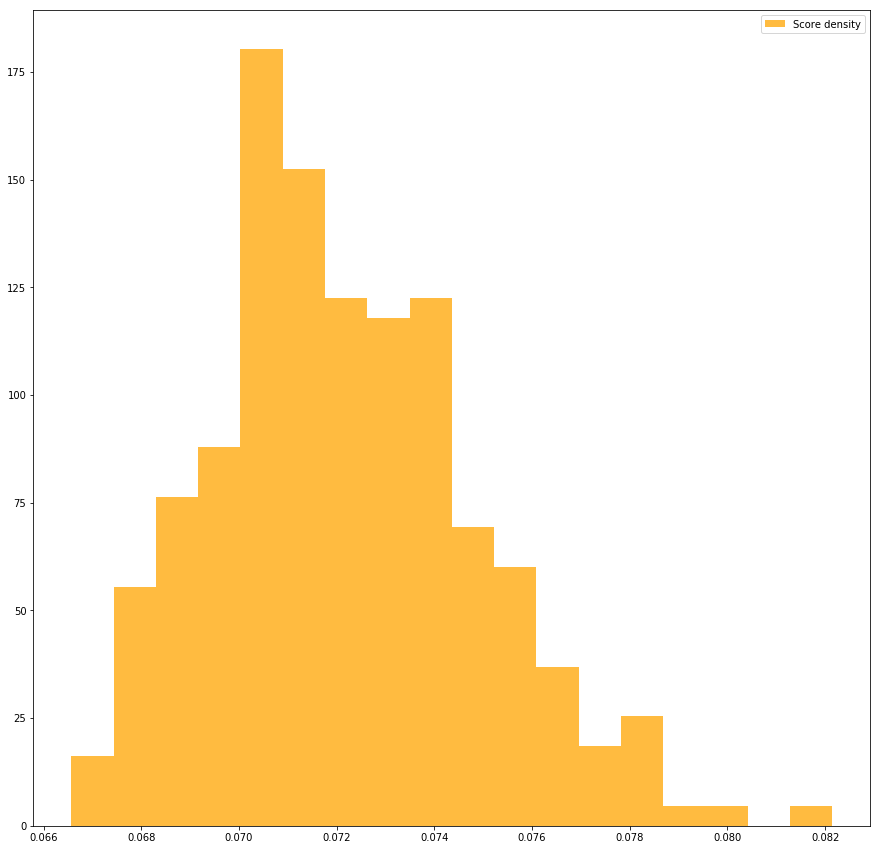

In [186]:
plt.figure(figsize=(15,15))
plt.hist(score, bins='auto',
         density=True, facecolor='orange', alpha=0.75, label='Score density')
plt.legend() 
plt.show()

## We can see that we have optimised our coefs for this set as the 0.0665 score is lowest part of the curtosis

In [188]:
#Let 's try to submit the median, the worst
np.argpartition(score,kth=True)


array([ 95, 259,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,   0,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [194]:
print(score[np.argpartition(score,kth=True)[249]])
xopt=xrand[np.argpartition(score,kth=True)[249]]

0.0711154470846


In [195]:
Mopt_1= np.zeros((15,15), dtype=float)
Mopt_1[8,8]=xopt[0]
Mopt_1[8,10]=xopt[1]
Mopt_1[8,12]=xopt[2]
Mopt_1[8,14]=xopt[3]
Mopt_1[10,10]=xopt[4]
Mopt_1[10,12]=xopt[5]
Mopt_1[10,14]=xopt[6]
Mopt_1[12,12]=xopt[7]
Mopt_1[14,14]=xopt[8]
np.savetxt('M_pred_opt_5.txt', Mopt_1, fmt='%f') 

### We get 0.0729 -> means we have optimized the best this set of features
### We should then try from another sets of features

In [153]:
clf_et_3.feature_importances_.shape

(10,)

In [154]:
M = MfromFeatures(clf_et_3.feature_importances_, Mtable_1, 11, 21, alg_time_thr)
MeanScoreCV(M,3)

Score at FAR=0.01%
threshold : 22479334.1253 far : 9.91339299393e-05 frr : 0.0637672641787
Score at FAR=0.01%
threshold : 16871914.9841 far : 9.91339299393e-05 frr : 0.0414340287981
Score at FAR=0.01%
threshold : 20376006.7501 far : 9.91339299393e-05 frr : 0.0637672641787
##done:  0.0563228523852


0.056322852385150356

### Not a good solution let 's try a Lasso CV as we want to reduce overfeet

In [156]:
clf_l_opt = LassoCV(cv=10,n_jobs=-1, random_state=26, max_iter=10**4)
clf_l_opt.fit(Xtrain_f,Y.values[train_2_index[0]])

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=26, selection='cyclic',
    tol=0.0001, verbose=False)

In [162]:
# let's see which coef are put to 0 
print(np.argwhere(clf_l_opt.coef_==0))


[[6]
 [7]
 [8]]


In [165]:
#index concerned are [10,14], [12,12], [14,14]
# let' s run extra trees on the 6 features retained

Xtrain = X_pol[train_2_index[0]]
Xtrain_f = Xtrain[:,ColToKeepPolyLasso[11:18]]
del Xtrain
clf_et_3 = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)
clf_et_3.fit(Xtrain_f, Y.values[train_2_index[0]])


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [169]:
def ScoreToMinimize_2(x):
    M= np.zeros((15,15), dtype=float)
    M[8,8]=x[0]
    M[8,10]=x[1]
    M[8,12]=x[2]
    M[8,14]=x[3]
    M[10,10]=x[4]
    M[10,12]=x[5]
    M/=np.sum(M)
    return MeanScoreCV(M,10)

ScoreToMinimize_2(clf_et_3.feature_importances_)

Score at FAR=0.01%
threshold : 16344103.0438 far : 9.51284233716e-05 frr : 0.0287952987267
Score at FAR=0.01%
threshold : 23812324.7235 far : 9.51284233716e-05 frr : 0.121645445642
Score at FAR=0.01%
threshold : 22665710.189 far : 9.51284233716e-05 frr : 0.0103819784525
Score at FAR=0.01%
threshold : 21030809.2121 far : 9.51284233716e-05 frr : 0.0526934378061
Score at FAR=0.01%
threshold : 15557391.3813 far : 9.51284233716e-05 frr : 0.048971596474
Score at FAR=0.01%
threshold : 16255656.757 far : 9.51284233716e-05 frr : 0.0154780564263
Score at FAR=0.01%
threshold : 18849675.208 far : 9.51284233716e-05 frr : 0.071512539185
Score at FAR=0.01%
threshold : 24255166.5683 far : 9.51284233716e-05 frr : 0.123236677116
Score at FAR=0.01%
threshold : 25090256.651 far : 9.5128899659e-05 frr : 0.267829153605
Score at FAR=0.01%
threshold : 15266611.964 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0755826315095


0.075582631509461179

In [171]:
# Now let's optimize it

res = minimize(ScoreToMinimize_2, clf_et_3.feature_importances_,
               method='Nelder-Mead', tol=1e-6)

Score at FAR=0.01%
threshold : 16344103.0438 far : 9.51284233716e-05 frr : 0.0287952987267
Score at FAR=0.01%
threshold : 23812324.7235 far : 9.51284233716e-05 frr : 0.121645445642
Score at FAR=0.01%
threshold : 22665710.189 far : 9.51284233716e-05 frr : 0.0103819784525
Score at FAR=0.01%
threshold : 21030809.2121 far : 9.51284233716e-05 frr : 0.0526934378061
Score at FAR=0.01%
threshold : 15557391.3813 far : 9.51284233716e-05 frr : 0.048971596474
Score at FAR=0.01%
threshold : 16255656.757 far : 9.51284233716e-05 frr : 0.0154780564263
Score at FAR=0.01%
threshold : 18849675.208 far : 9.51284233716e-05 frr : 0.071512539185
Score at FAR=0.01%
threshold : 24255166.5683 far : 9.51284233716e-05 frr : 0.123236677116
Score at FAR=0.01%
threshold : 25090256.651 far : 9.5128899659e-05 frr : 0.267829153605
Score at FAR=0.01%
threshold : 15266611.964 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0755826315095
Score at FAR=0.01%
threshold : 16342729.0452 far : 9.51284233716e-05 frr : 0.

Score at FAR=0.01%
threshold : 15236644.7933 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0753475217916
Score at FAR=0.01%
threshold : 16344995.6612 far : 9.51284233716e-05 frr : 0.0289911851126
Score at FAR=0.01%
threshold : 23813076.6727 far : 9.51284233716e-05 frr : 0.121841332027
Score at FAR=0.01%
threshold : 22661906.4965 far : 9.51284233716e-05 frr : 0.0103819784525
Score at FAR=0.01%
threshold : 21010149.1132 far : 9.51284233716e-05 frr : 0.0526934378061
Score at FAR=0.01%
threshold : 15541400.5631 far : 9.51284233716e-05 frr : 0.0487757100881
Score at FAR=0.01%
threshold : 16248268.7888 far : 9.51284233716e-05 frr : 0.0154780564263
Score at FAR=0.01%
threshold : 18847306.371 far : 9.51284233716e-05 frr : 0.0713166144201
Score at FAR=0.01%
threshold : 24233160.7345 far : 9.51284233716e-05 frr : 0.123040752351
Score at FAR=0.01%
threshold : 25070856.3391 far : 9.5128899659e-05 frr : 0.267045454545
Score at FAR=0.01%
threshold : 15251527.0333 far : 9.5128899659e-05 frr

Score at FAR=0.01%
threshold : 24927281.9844 far : 9.5128899659e-05 frr : 0.263714733542
Score at FAR=0.01%
threshold : 15211625.2993 far : 9.5128899659e-05 frr : 0.0152821316614
##done:  0.0744854988809
Score at FAR=0.01%
threshold : 16338207.1278 far : 9.51284233716e-05 frr : 0.0287952987267
Score at FAR=0.01%
threshold : 23808753.7733 far : 9.51284233716e-05 frr : 0.121841332027
Score at FAR=0.01%
threshold : 22655824.4364 far : 9.51284233716e-05 frr : 0.0103819784525
Score at FAR=0.01%
threshold : 20973852.4716 far : 9.51284233716e-05 frr : 0.0526934378061
Score at FAR=0.01%
threshold : 15486768.7556 far : 9.51284233716e-05 frr : 0.0476003917728
Score at FAR=0.01%
threshold : 16224429.7739 far : 9.51284233716e-05 frr : 0.0152821316614
Score at FAR=0.01%
threshold : 18852546.5875 far : 9.51284233716e-05 frr : 0.0713166144201
Score at FAR=0.01%
threshold : 24163168.7821 far : 9.51284233716e-05 frr : 0.121865203762
Score at FAR=0.01%
threshold : 24985686.9558 far : 9.5128899659e-05 fr

Score at FAR=0.01%
threshold : 23883518.3026 far : 9.51284233716e-05 frr : 0.117163009404
Score at FAR=0.01%
threshold : 24746685.588 far : 9.5128899659e-05 frr : 0.258620689655
Score at FAR=0.01%
threshold : 15141941.5812 far : 9.5128899659e-05 frr : 0.0150862068966
##done:  0.0733295619575
Score at FAR=0.01%
threshold : 16353813.0655 far : 9.51284233716e-05 frr : 0.0293829578844
Score at FAR=0.01%
threshold : 23698156.7371 far : 9.51284233716e-05 frr : 0.12125367287
Score at FAR=0.01%
threshold : 22519533.9937 far : 9.51284233716e-05 frr : 0.0103819784525
Score at FAR=0.01%
threshold : 20944073.4687 far : 9.51284233716e-05 frr : 0.0526934378061
Score at FAR=0.01%
threshold : 15257770.8131 far : 9.51284233716e-05 frr : 0.0454456415279
Score at FAR=0.01%
threshold : 15999810.7428 far : 9.51284233716e-05 frr : 0.0137147335423
Score at FAR=0.01%
threshold : 18691295.7344 far : 9.51284233716e-05 frr : 0.0697492163009
Score at FAR=0.01%
threshold : 23943784.0521 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 18611239.423 far : 9.51284233716e-05 frr : 0.0691614420063
Score at FAR=0.01%
threshold : 23486807.5227 far : 9.51284233716e-05 frr : 0.110305642633
Score at FAR=0.01%
threshold : 24415341.1377 far : 9.5128899659e-05 frr : 0.254114420063
Score at FAR=0.01%
threshold : 15034964.1108 far : 9.5128899659e-05 frr : 0.0150862068966
##done:  0.0716446818995
Score at FAR=0.01%
threshold : 16110131.1642 far : 9.51284233716e-05 frr : 0.0291870714985
Score at FAR=0.01%
threshold : 23481943.2908 far : 9.51284233716e-05 frr : 0.12125367287
Score at FAR=0.01%
threshold : 22281317.1176 far : 9.51284233716e-05 frr : 0.00999020568071
Score at FAR=0.01%
threshold : 20780992.3285 far : 9.51284233716e-05 frr : 0.0534769833497
Score at FAR=0.01%
threshold : 14877676.9218 far : 9.51284233716e-05 frr : 0.0421155729677
Score at FAR=0.01%
threshold : 15703497.2892 far : 9.51284233716e-05 frr : 0.0127351097179
Score at FAR=0.01%
threshold : 18623258.4775 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 15222272.7335 far : 9.51284233716e-05 frr : 0.0113636363636
Score at FAR=0.01%
threshold : 18155977.8333 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22640752.6954 far : 9.51284233716e-05 frr : 0.0995297805643
Score at FAR=0.01%
threshold : 23416860.6276 far : 9.5128899659e-05 frr : 0.225117554859
Score at FAR=0.01%
threshold : 14623141.9569 far : 9.5128899659e-05 frr : 0.0141065830721
##done:  0.0679415388134
Score at FAR=0.01%
threshold : 16033684.9853 far : 9.51284233716e-05 frr : 0.0303623898139
Score at FAR=0.01%
threshold : 23112066.9367 far : 9.51284233716e-05 frr : 0.121449559256
Score at FAR=0.01%
threshold : 22128894.218 far : 9.51284233716e-05 frr : 0.0109696376102
Score at FAR=0.01%
threshold : 20747330.4772 far : 9.51284233716e-05 frr : 0.0570029382958
Score at FAR=0.01%
threshold : 14593383.9119 far : 9.51284233716e-05 frr : 0.0427032321254
Score at FAR=0.01%
threshold : 15252031.2742 far : 9.51284233716e-05 f

Score at FAR=0.01%
threshold : 14318612.1721 far : 9.51284233716e-05 frr : 0.0442703232125
Score at FAR=0.01%
threshold : 15113938.8825 far : 9.51284233716e-05 frr : 0.0135188087774
Score at FAR=0.01%
threshold : 18039979.6112 far : 9.51284233716e-05 frr : 0.0670062695925
Score at FAR=0.01%
threshold : 22399311.919 far : 9.51284233716e-05 frr : 0.100509404389
Score at FAR=0.01%
threshold : 22481665.6005 far : 9.5128899659e-05 frr : 0.202978056426
Score at FAR=0.01%
threshold : 14270344.7496 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0669813501116
Score at FAR=0.01%
threshold : 15909579.0406 far : 9.51284233716e-05 frr : 0.0317335945152
Score at FAR=0.01%
threshold : 22597081.1548 far : 9.51284233716e-05 frr : 0.123212536729
Score at FAR=0.01%
threshold : 21963160.374 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20528394.8319 far : 9.51284233716e-05 frr : 0.0620959843291
Score at FAR=0.01%
threshold : 14314273.4062 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 20745393.4296 far : 9.51284233716e-05 frr : 0.0591576885406
Score at FAR=0.01%
threshold : 14446006.9495 far : 9.51284233716e-05 frr : 0.0428991185113
Score at FAR=0.01%
threshold : 15166513.9845 far : 9.51284233716e-05 frr : 0.0117554858934
Score at FAR=0.01%
threshold : 18108997.2043 far : 9.51284233716e-05 frr : 0.0648510971787
Score at FAR=0.01%
threshold : 22617779.6218 far : 9.51284233716e-05 frr : 0.100509404389
Score at FAR=0.01%
threshold : 23263488.2304 far : 9.5128899659e-05 frr : 0.219827586207
Score at FAR=0.01%
threshold : 14579840.7195 far : 9.5128899659e-05 frr : 0.0141065830721
##done:  0.0675692664086
Score at FAR=0.01%
threshold : 15917418.6757 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22692431.6557 far : 9.51284233716e-05 frr : 0.122624877571
Score at FAR=0.01%
threshold : 21996447.0458 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20545899.8875 far : 9.51284233716e-05 fr

Score at FAR=0.01%
threshold : 22028844.2103 far : 9.51284233716e-05 frr : 0.0111655239961
Score at FAR=0.01%
threshold : 20637315.5982 far : 9.51284233716e-05 frr : 0.0601371204701
Score at FAR=0.01%
threshold : 14326166.3734 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15100658.4072 far : 9.51284233716e-05 frr : 0.0117554858934
Score at FAR=0.01%
threshold : 18108164.446 far : 9.51284233716e-05 frr : 0.0666144200627
Score at FAR=0.01%
threshold : 22521627.9032 far : 9.51284233716e-05 frr : 0.100313479624
Score at FAR=0.01%
threshold : 22877137.3486 far : 9.5128899659e-05 frr : 0.208659874608
Score at FAR=0.01%
threshold : 14457583.5445 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0669030608015
Score at FAR=0.01%
threshold : 15891847.3325 far : 9.51284233716e-05 frr : 0.0317335945152
Score at FAR=0.01%
threshold : 22634377.8816 far : 9.51284233716e-05 frr : 0.123016650343
Score at FAR=0.01%
threshold : 21976520.5003 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 22684926.7078 far : 9.51284233716e-05 frr : 0.122624877571
Score at FAR=0.01%
threshold : 21991787.2323 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20547790.8622 far : 9.51284233716e-05 frr : 0.0617042115573
Score at FAR=0.01%
threshold : 14307367.7472 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15128814.0165 far : 9.51284233716e-05 frr : 0.0131269592476
Score at FAR=0.01%
threshold : 18019859.9549 far : 9.51284233716e-05 frr : 0.066026645768
Score at FAR=0.01%
threshold : 22443083.7769 far : 9.51284233716e-05 frr : 0.100313479624
Score at FAR=0.01%
threshold : 22567192.0087 far : 9.5128899659e-05 frr : 0.203565830721
Score at FAR=0.01%
threshold : 14265140.9026 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0667266786204
Score at FAR=0.01%
threshold : 15928034.2625 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22714464.6695 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 15948053.2602 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22752605.5905 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22021225.5118 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20575521.0889 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14307805.9413 far : 9.51284233716e-05 frr : 0.0432908912831
Score at FAR=0.01%
threshold : 15118484.4853 far : 9.51284233716e-05 frr : 0.012539184953
Score at FAR=0.01%
threshold : 18063869.7167 far : 9.51284233716e-05 frr : 0.066026645768
Score at FAR=0.01%
threshold : 22496449.0919 far : 9.51284233716e-05 frr : 0.0997257053292
Score at FAR=0.01%
threshold : 22743374.8144 far : 9.5128899659e-05 frr : 0.206700626959
Score at FAR=0.01%
threshold : 14408399.5846 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0667267169994
Score at FAR=0.01%
threshold : 15915384.1164 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 14349461.5653 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665699695117
Score at FAR=0.01%
threshold : 15911879.4816 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22693662.8563 far : 9.51284233716e-05 frr : 0.122820763957
Score at FAR=0.01%
threshold : 21995359.5804 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20547192.3788 far : 9.51284233716e-05 frr : 0.0613124387855
Score at FAR=0.01%
threshold : 14307302.6392 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15129673.9806 far : 9.51284233716e-05 frr : 0.0131269592476
Score at FAR=0.01%
threshold : 18010908.6377 far : 9.51284233716e-05 frr : 0.066026645768
Score at FAR=0.01%
threshold : 22442957.2435 far : 9.51284233716e-05 frr : 0.100313479624
Score at FAR=0.01%
threshold : 22585093.0446 far : 9.5128899659e-05 frr : 0.203369905956
Score at FAR=0.01%
threshold : 14292077.6717 far : 9.5128899659e-05 frr :

Score at FAR=0.01%
threshold : 22706445.3458 far : 9.5128899659e-05 frr : 0.20552507837
Score at FAR=0.01%
threshold : 14386997.081 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0666483432556
Score at FAR=0.01%
threshold : 15918890.0144 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22707230.5342 far : 9.51284233716e-05 frr : 0.122820763957
Score at FAR=0.01%
threshold : 21999242.8886 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20557065.3613 far : 9.51284233716e-05 frr : 0.0609206660137
Score at FAR=0.01%
threshold : 14308145.5104 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15133030.8006 far : 9.51284233716e-05 frr : 0.0131269592476
Score at FAR=0.01%
threshold : 18002742.0664 far : 9.51284233716e-05 frr : 0.0656347962382
Score at FAR=0.01%
threshold : 22461405.613 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22622687.5221 far : 9.5128899659e-05 frr : 0

Score at FAR=0.01%
threshold : 22476792.1502 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22670867.3935 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14356744.414 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665307845587
Score at FAR=0.01%
threshold : 15935071.5136 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22736285.7861 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22008318.2166 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20570277.98 far : 9.51284233716e-05 frr : 0.0607247796278
Score at FAR=0.01%
threshold : 14314098.7974 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15125777.6666 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18011943.9325 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22492500.8072 far : 9.51284233716e-05 frr : 

Score at FAR=0.01%
threshold : 18008126.9489 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22484564.1545 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22675627.1434 far : 9.5128899659e-05 frr : 0.204545454545
Score at FAR=0.01%
threshold : 14355691.5285 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665895581503
Score at FAR=0.01%
threshold : 15936195.0328 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22734023.9231 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22008549.6613 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563137.6498 far : 9.51284233716e-05 frr : 0.0607247796278
Score at FAR=0.01%
threshold : 14312933.9032 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15124802.5941 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18011530.4666 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 15123845.1977 far : 9.51284233716e-05 frr : 0.0127351097179
Score at FAR=0.01%
threshold : 18019248.1079 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22486637.2614 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22688935.7033 far : 9.5128899659e-05 frr : 0.20474137931
Score at FAR=0.01%
threshold : 14372776.536 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665503808731
Score at FAR=0.01%
threshold : 15937711.6612 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22736913.3482 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009424.1823 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20564568.8459 far : 9.51284233716e-05 frr : 0.0607247796278
Score at FAR=0.01%
threshold : 14313761.0225 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15124173.5867 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 14315591.4597 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123888.2885 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18011875.3476 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22482692.9966 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22678387.2341 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14364887.4246 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665307845587
Score at FAR=0.01%
threshold : 15937525.9361 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22735070.2334 far : 9.51284233716e-05 frr : 0.122624877571
Score at FAR=0.01%
threshold : 22009236.4602 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20560706.3933 far : 9.51284233716e-05 frr : 0.0607247796278
Score at FAR=0.01%
threshold : 14314051.2227 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 20564648.3128 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313651.1183 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123717.8838 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017328.7825 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22483131.9724 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684770.7009 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14369834.3244 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938437.9024 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22737586.9824 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009773.6139 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563968.0369 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 22010008.5894 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20564641.6533 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313502.9664 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123504.1093 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18018627.6406 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22483018.6253 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22686122.1487 far : 9.5128899659e-05 frr : 0.204349529781
Score at FAR=0.01%
threshold : 14371874.7343 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665307883966
Score at FAR=0.01%
threshold : 15938202.0853 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22737207.8298 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009637.659 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 22738073.0686 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009938.9669 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20564176.425 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313627.9235 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123573.4442 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017617.8314 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22482354.1378 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684605.8107 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370337.4131 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938508.3571 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22737626.3146 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 15938789.8721 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738058.9082 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009949.0602 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20564063.5711 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313623.2749 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123552.4662 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017616.2576 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22482167.1235 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684499.6236 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370329.7262 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938661.4791 far : 9.51284233716e-05 frr

Score at FAR=0.01%
threshold : 14370254.5488 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938802.2322 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738051.8284 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009954.1065 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20564007.1475 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313620.9507 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123541.9779 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017615.4708 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22482073.622 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684446.5332 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370325.883 far : 9.5128899659e-05 frr : 

Score at FAR=0.01%
threshold : 22684416.4797 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370288.2953 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938808.4121 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738048.2886 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009956.6296 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563978.9365 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313619.7887 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123536.7339 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017615.0774 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22482026.8726 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684419.9888 far : 9.5128899659e-05 frr 

Score at FAR=0.01%
threshold : 22481968.0843 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684404.9621 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370305.1679 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938811.502 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738046.5188 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009957.8912 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563964.8312 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313619.2077 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123534.1119 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017614.8807 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22482003.4982 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 18017622.1623 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22481974.1042 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684399.2035 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370313.604 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938813.0469 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738045.6339 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009958.5219 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563957.7786 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313618.9172 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123532.8009 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017614.7823 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 15123534.1658 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017618.4231 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22481977.1142 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684396.3242 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370317.822 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938813.8194 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738045.1914 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009958.8373 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563954.2523 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313618.7719 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123532.1455 far : 9.51284233716e-05 frr 

Score at FAR=0.01%
threshold : 14313614.5378 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123532.8279 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017616.5535 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22481978.6191 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684394.8845 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370319.931 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938814.2056 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738044.9702 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009958.995 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563952.4892 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313618.6993 far : 9.51284233716e-05 frr :

Score at FAR=0.01%
threshold : 20563951.7588 far : 9.51284233716e-05 frr : 0.0605288932419
Score at FAR=0.01%
threshold : 14313616.5823 far : 9.51284233716e-05 frr : 0.043486777669
Score at FAR=0.01%
threshold : 15123532.1589 far : 9.51284233716e-05 frr : 0.0129310344828
Score at FAR=0.01%
threshold : 18017615.6188 far : 9.51284233716e-05 frr : 0.0654388714734
Score at FAR=0.01%
threshold : 22481979.3716 far : 9.51284233716e-05 frr : 0.100117554859
Score at FAR=0.01%
threshold : 22684394.1647 far : 9.5128899659e-05 frr : 0.204153605016
Score at FAR=0.01%
threshold : 14370320.9855 far : 9.5128899659e-05 frr : 0.0139106583072
##done:  0.0665111959202
Score at FAR=0.01%
threshold : 15938814.3988 far : 9.51284233716e-05 frr : 0.0307541625857
Score at FAR=0.01%
threshold : 22738044.8596 far : 9.51284233716e-05 frr : 0.122428991185
Score at FAR=0.01%
threshold : 22009959.0739 far : 9.51284233716e-05 frr : 0.011361410382
Score at FAR=0.01%
threshold : 20563951.6076 far : 9.51284233716e-05 frr

In [172]:
x1 = res.x
M = np.zeros((15, 15), dtype=float)
M[8, 8] = x1[0]
M[8, 10] = x1[1]
M[8, 12] = x1[2]
M[8, 14] = x1[3]
M[10, 10] = x1[4]
M[10, 12] = x1[5]

np.savetxt('M_pred_opt_3' + str(i) +'_.txt', M, fmt='%f')

### Optimizing through Adaboost Classifier varying max 
### Our sets of selected features seems to be too complex let's reduce it

In [99]:
feat_weight_cv3_ada = np.zeros((10, 21))
fr_cv3_ada = np.zeros((10))

for j, i in enumerate(range(1, 12, 2)):
    clf_et_1 = ExtraTreesClassifier(n_jobs=-1, max_depth=i)
    clf_ada = AdaBoostClassifier(clf_et_1, random_state=26)
    clf_ada.fit(Xtrain_f, Y.values[train_2_index[0]])
    feat_weight_cv3_ada[j, 11:] = np.asarray(
        clf_ada.feature_importances_)[:]
    M = MfromFeatures(feat_weight_cv3_ada[j, :], Mtable_1, 0, 21, alg_time_thr)
    thr, fa, fr = evalModel(returnFuseVect(
        M, Y.iloc[test_2_index[2]], CompData.iloc[test_2_index[2], :]))
    fr_cv3_ada[j] = fr

Score at FAR=0.01%
threshold : 20180859.0606 far : 9.91339299393e-05 frr : 0.0637084925066
Score at FAR=0.01%
threshold : 20341019.823 far : 9.91339299393e-05 frr : 0.064119894211
Score at FAR=0.01%
threshold : 20292615.5246 far : 9.91339299393e-05 frr : 0.0636497208346
Score at FAR=0.01%
threshold : 20284310.0073 far : 9.91339299393e-05 frr : 0.0637672641787
Score at FAR=0.01%
threshold : 20279266.1753 far : 9.91339299393e-05 frr : 0.0640611225389
Score at FAR=0.01%
threshold : nan far : 9.91339299393e-05 frr : 0.999941228328


In [100]:
for i in range(0,5):  
    M = MfromFeatures(feat_weight_cv3_ada[i,:], Mtable_1, 0, 21, alg_time_thr)
    thr, fa, fr = evalModel(returnFuseVect(
        M, Y.iloc[test_2_index[1]], CompData.iloc[test_2_index[1], :]))
    np.savetxt('M_pred_cv3_ada' + str(i) +'_.txt', M, fmt='%f')

Score at FAR=0.01%
threshold : 16696224.4079 far : 9.91339299393e-05 frr : 0.0392594769321
Score at FAR=0.01%
threshold : 16813292.5859 far : 9.91339299393e-05 frr : 0.040199823685
Score at FAR=0.01%
threshold : 16759843.834 far : 9.91339299393e-05 frr : 0.0400822803409
Score at FAR=0.01%
threshold : 16714437.4365 far : 9.91339299393e-05 frr : 0.0396121069644
Score at FAR=0.01%
threshold : 16761665.735 far : 9.91339299393e-05 frr : 0.0399059653247


### We have not improved the score we reach the limit of our method with Extra Trees

In [91]:
##Both matrix are different let's check the score
thr, fa, fr = evalModel(returnFuseVect(
    Mlg, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0], :]))
np.savetxt('M_pred_cv3_PL_LG_.txt', Mlg, fmt='%f')

Score at FAR=0.01%
threshold : 23218828.855 far : 9.91339299393e-05 frr : 0.0682926829268


In [87]:
# confusion matrix
from sklearn.metrics import confusion_matrix
Xtest = X_pol[test_2_index[0]]
Xtest_f = Xtest[:,ColToKeepPolyLasso[11:]]
del Xtest
confusion_matrix(Y.values[test_2_index[0]], clf_lg.predict(Xtest_f))

array([[651638,  14128],
       [   311,  16704]])

In [ ]:
d = np.zeros(22)
d[13:] = clf_gs.best_estimator_.feature_importances_
M = MfromFeatures(d, Mtable_1, 0, 22, alg_time_thr)
thr, fa, fr = evalModel(returnFuseVect(
    M, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0], :]))
np.savetxt('M_pred_W_.txt', M, fmt='%f')

In [ ]:
# Neglecting the coef less than .1
M[8, 12] = 0
M[10, 12] = 0
M[10, 14] = 0
M[12, 14] = 0

M = M / np.sum(M)
thr, fa, fr = evalModel(returnFuseVect(
    M, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0], :]))
np.savetxt('M_pred_W_.txt', M, fmt='%f')

### As seen above we reach the minimum with the set choosen regarding the ExtraTrees method to fit the weight and a minimizer applied to the weight with objective the score function

#### Let's explore the other option if we get a better score 
#### Lasso -> Data Analysis ->Lasso->  Extra Trees

In [139]:
ColtoKeepLassoPoly

array([ 3,  7, 13,  9,  2,  6,  8, 12])

## Methodoly 2 Following

In [142]:
poly_2 = PolynomialFeatures(include_bias=True)
X_pol_2 = poly_2.fit_transform(trainset.values[:,ColtoKeepLassoPoly])
X_pol_2.shape

(2048343, 45)

In [148]:
# let 's do a second Lasso to reduce dimension
#Apply Lasso and ElasticNet on original dataset
Xtrain = X_pol_2[test_index[0]]
Ytrain = Y.values[test_index[0]]
clf_l_2 = LassoCV(cv=10,n_jobs=-1, random_state=26, max_iter=10**4)
clf_e_2 = ElasticNetCV(cv=10, n_jobs=-1, random_state=26, max_iter=10**4)
clf_l_2.fit(Xtrain,Ytrain)
clf_e_2.fit(Xtrain,Ytrain)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=10000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto', random_state=26,
       selection='cyclic', tol=0.0001, verbose=0)

In [151]:
np.argwhere(clf_e_2.coef_>0)

array([[ 2],
       [ 3],
       [ 4],
       [10],
       [11],
       [12],
       [17],
       [18],
       [19],
       [24],
       [25],
       [30]])

In [152]:
np.argwhere(clf_l_2.coef_>0)

array([[ 2],
       [ 3],
       [ 4],
       [10],
       [11],
       [17],
       [18],
       [19],
       [24],
       [25],
       [30]])

In [159]:
Xtrain = X_pol_2[:,np.argwhere(clf_l_2.coef_>0).ravel()]

In [160]:
#Let's rank the 11 columns
clf_e_2 = ExtraTreesClassifier(n_jobs=-1, random_state=26)
clf_e_2.fit(Xtrain,Y.values)
clf_e_2.feature_importances_

array([ 0.0082236 ,  0.0157208 ,  0.06979028,  0.00876431,  0.17721577,
        0.15152714,  0.07163784,  0.26920707,  0.1278366 ,  0.01482767,
        0.08524892])

In [175]:
SelCol = np.argsort(clf_e_2.feature_importances_)
print(SelCol)
print(ColtoKeepLassoPoly)

[ 0  3  9  1  2  6 10  8  5  4  7]
[ 3  7 13  9  2  6  8 12]


In [164]:
np.asarray(poly_2.get_feature_names())[np.argwhere(clf_l_2.coef_>0).ravel()]

array(['x1', 'x2', 'x3', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x1 x3',
       'x2^2', 'x2 x3', 'x3^2'],
      dtype='<U5')

In [180]:
Tabdict = np.zeros(9, dtype=int)
Tabdict[0] = 3
Tabdict[1] = 7
Tabdict[2] = 13
Tabdict[3] = 9
Tabdict[4] = 2
Tabdict[5] = 6
Tabdict[6] = 8
Tabdict[7] = 12


import re
reg = r"x(\d*)(\^)?\s?x?(\d*)?"
Mtable_2 = np.zeros((15, 15), dtype=int)

for j, i in enumerate(np.asarray(poly_2.get_feature_names())[np.argwhere(clf_l_2.coef_ > 0).ravel()]):
    p = re.search(reg, i)
    if p.group(2) == '^':
        Mtable_2[Tabdict[int(p.group(1))] + 1, Tabdict[int(p.group(1))] + 1] = j+1
    elif p.group(3) != '':
        Mtable_2[Tabdict[int(p.group(1))] + 1, Tabdict[int(p.group(3))] + 1] = j+1
    else:
        Mtable_2[Tabdict[int(p.group(1))] + 1, 0] = j +1
print(np.argwhere(Mtable_2 > 0))


[[ 4  8]
 [ 4 14]
 [ 8  0]
 [ 8  8]
 [ 8 10]
 [ 8 14]
 [10  0]
 [10 10]
 [14  0]
 [14 10]
 [14 14]]


In [190]:
fr_f_1 = np.zeros(((SelCol.shape[0]-2),10), dtype=float)
feat_weight_1 = np.zeros((10 * (SelCol.shape[0]-2), SelCol.shape[0]))

# Cross Validation 10

for j in range(SelCol.shape[0]-2):
    for i in range(10):
        Min=0
        Xtrain = X_pol_2[train_index[i]]
        Xtrain_f = Xtrain[:,SelCol[j:]]
        print(Xtrain_f.shape)
        del Xtrain
        Ytrain = Y.values[train_index[i]]
        Ytest = Y.values[test_index[i]]
        clf_e_2.fit(Xtrain_f, Ytrain)
        feat_weight_1[i + 10 * j, j:] = np.asarray(clf_e_2.feature_importances_)[:]
        Mf=MfromFeatures(np.asarray(clf_e_2.feature_importances_),Mtable_2,j,SelCol.shape[0], alg_time_thr)
        thr, fa, fr = evalModel(returnFuseVect(
            Mf, Y.iloc[test_index[i]], CompData.iloc[test_index[i], :]))
        fr_f_1[j,i]=fr
    print(fr_f_1[j,:])


# Plot features_scores percantile
# Plot FRR -> percentile

(1843508, 11)
Score at FAR=0.01%
threshold : 16641043.9347 far : 9.51284233716e-05 frr : 0.0360430950049
(1843508, 11)
Score at FAR=0.01%
threshold : 23964034.912 far : 9.51284233716e-05 frr : 0.131635651322
(1843508, 11)
Score at FAR=0.01%
threshold : 22573500.6882 far : 9.51284233716e-05 frr : 0.015083251714
(1843508, 11)
Score at FAR=0.01%
threshold : 21401041.6535 far : 9.51284233716e-05 frr : 0.0871694417238
(1843508, 11)
Score at FAR=0.01%
threshold : 15333917.5814 far : 9.51284233716e-05 frr : 0.0760039177277
(1843509, 11)
Score at FAR=0.01%
threshold : 15509754.901 far : 9.51284233716e-05 frr : 0.0217476489028
(1843509, 11)
Score at FAR=0.01%
threshold : 19557274.4071 far : 9.51284233716e-05 frr : 0.0850313479624
(1843509, 11)
Score at FAR=0.01%
threshold : 24210790.8192 far : 9.51284233716e-05 frr : 0.137147335423
(1843510, 11)
Score at FAR=0.01%
threshold : 25285009.879 far : 9.5128899659e-05 frr : 0.260775862069
(1843510, 11)
Score at FAR=0.01%
threshold : 14153952.2339 far 

Score at FAR=0.01%
threshold : 24465508.9173 far : 9.51284233716e-05 frr : 0.125759059745
(1843508, 4)
Score at FAR=0.01%
threshold : 23270446.6292 far : 9.51284233716e-05 frr : 0.00803134182174
(1843508, 4)
Score at FAR=0.01%
threshold : 21795156.7278 far : 9.51284233716e-05 frr : 0.0711067580803
(1843508, 4)
Score at FAR=0.01%
threshold : 16646127.6792 far : 9.51284233716e-05 frr : 0.0863858961802
(1843509, 4)
Score at FAR=0.01%
threshold : 17128039.0056 far : 9.51284233716e-05 frr : 0.0280172413793
(1843509, 4)
Score at FAR=0.01%
threshold : 20189094.4596 far : 9.51284233716e-05 frr : 0.0877742946708
(1843509, 4)
Score at FAR=0.01%
threshold : 23174818.4356 far : 9.51284233716e-05 frr : 0.103056426332
(1843510, 4)
Score at FAR=0.01%
threshold : 25535516.6704 far : 9.5128899659e-05 frr : 0.282915360502
(1843510, 4)
Score at FAR=0.01%
threshold : 16801476.4363 far : 9.5128899659e-05 frr : 0.0327194357367
[ 0.03682664  0.12575906  0.00803134  0.07110676  0.0863859   0.02801724
  0.0877

In [192]:
Moy = np.mean(fr_f_1, axis=1)
Max = np.max(fr_f_1, axis=1)
Min = np.min(fr_f_1, axis=1)
MinMax = np.zeros((2,Moy.shape[0]))
MinMax[0,:]=Min
MinMax[1,:]=Max

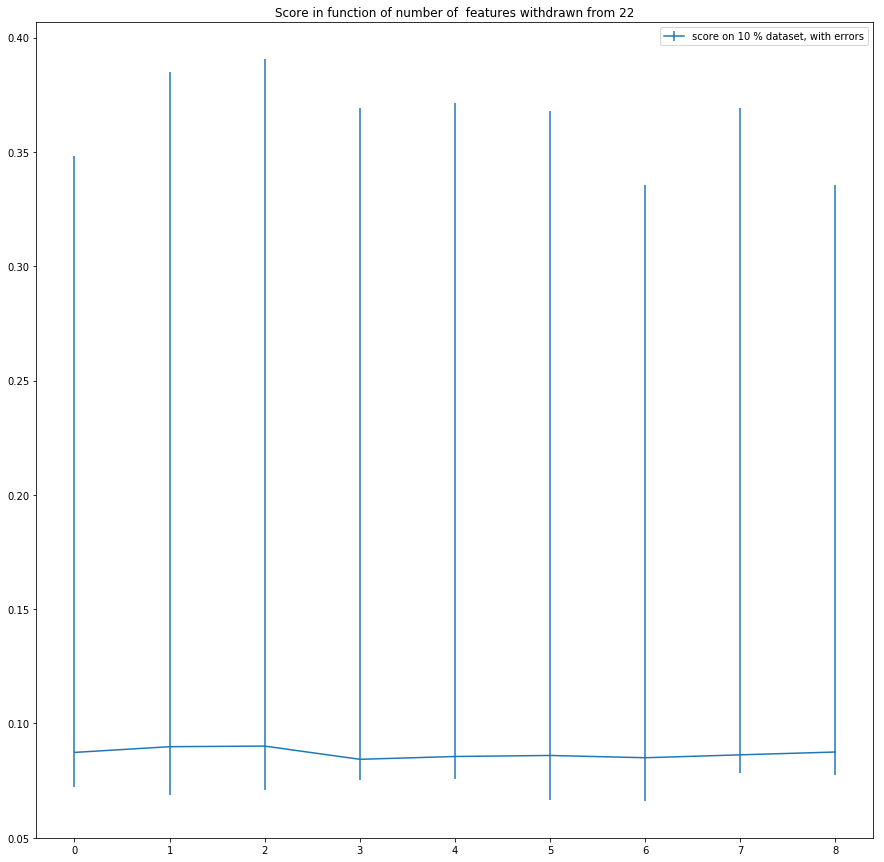

In [194]:
#plot scores nb colonnes ( candlestick)
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(range(SelCol.shape[0]-2))
y = Moy



# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(15,15))
plt.errorbar(x, y, yerr=MinMax, label='score on 10 % dataset, with errors')
plt.title("Score in function of number of  features withdrawn from 11")
plt.legend()
plt.show()

In [196]:
for i, j in enumerate(np.argsort(fr_f_1, axis=1)[:, 2]):  
    M = MfromFeatures(feat_weight_1[j+10*i, :], Mtable_2, 0, 11, alg_time_thr)
    thr, fa, fr = evalModel(returnFuseVect(
        M, Y.iloc[test_2_index[0]], CompData.iloc[test_2_index[0], :]))
    np.savetxt('M_pred_LP' + str(i) +'_.txt', M, fmt='%f')

Score at FAR=0.01%
threshold : 20649009.3321 far : 9.91339299393e-05 frr : 0.0669997061416
Score at FAR=0.01%
threshold : 20818409.6228 far : 9.91339299393e-05 frr : 0.0690567146635
Score at FAR=0.01%
threshold : 21676517.578 far : 9.91339299393e-05 frr : 0.067352336174
Score at FAR=0.01%
threshold : 23147193.0338 far : 9.91339299393e-05 frr : 0.0675286511901
Score at FAR=0.01%
threshold : 23101919.0486 far : 9.91339299393e-05 frr : 0.0669409344696
Score at FAR=0.01%
threshold : 23649009.6069 far : 9.91339299393e-05 frr : 0.0656479576844
Score at FAR=0.01%
threshold : 23816748.798 far : 9.91339299393e-05 frr : 0.0638848075228
Score at FAR=0.01%
threshold : 23041152.0925 far : 9.91339299393e-05 frr : 0.0730531883632
Score at FAR=0.01%
threshold : 23796630.3052 far : 9.91339299393e-05 frr : 0.0689979429915


### Methodology 3
made a stupid mistake on my graph for logistic regression no time to run it before submission deadline

In [70]:
clf_lg = LogisticRegression( n_jobs=-1)
fr_f_5 = np.zeros(((ColToKeepPolyLasso.shape[0]-2),10), dtype=float)
feat_weight_5 = np.zeros((10 * (ColToKeepPolyLasso.shape[0]-2), ColToKeepPolyLasso.shape[0]))
Mf_l=[]
# Cross Validation 10

for j in range(ColToKeepPolyLasso.shape[0]-2):
    for i in range(10):
        Min=0
        Xtrain = X_pol[train_index[i]]
        Xtrain_f = Xtrain[:,ColToKeepPolyLasso[j:]]
        print(Xtrain_f.shape)
        del Xtrain
        Ytrain = Y.values[train_index[i]]
        Ytest = Y.values[test_index[i]]
        clf_lg.fit(Xtrain_f, Ytrain)
        feat_weight_5[i + 10 * j, j:] = np.asarray(clf_lg.coef_)[:]
        Mf=MfromFeatures(np.asarray(clf_lg.coef_),Mtable_1,j,21, alg_time_thr)
        thr, fa, fr = evalModel(returnFuseVect(
            Mf, Y.iloc[test_index[i]], CompData.iloc[test_index[i], :]))
        fr_f_5[j,i]=fr
    print(fr_f_5[j,:])






(1843508, 21)


/home/joseph/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Score at FAR=0.01%
threshold : 23059595.9796 far : 9.51284233716e-05 frr : 0.0309500489716
(1843508, 21)
Score at FAR=0.01%
threshold : 33851657.6324 far : 9.51284233716e-05 frr : 0.124191968658
(1843508, 21)


KeyboardInterrupt: 

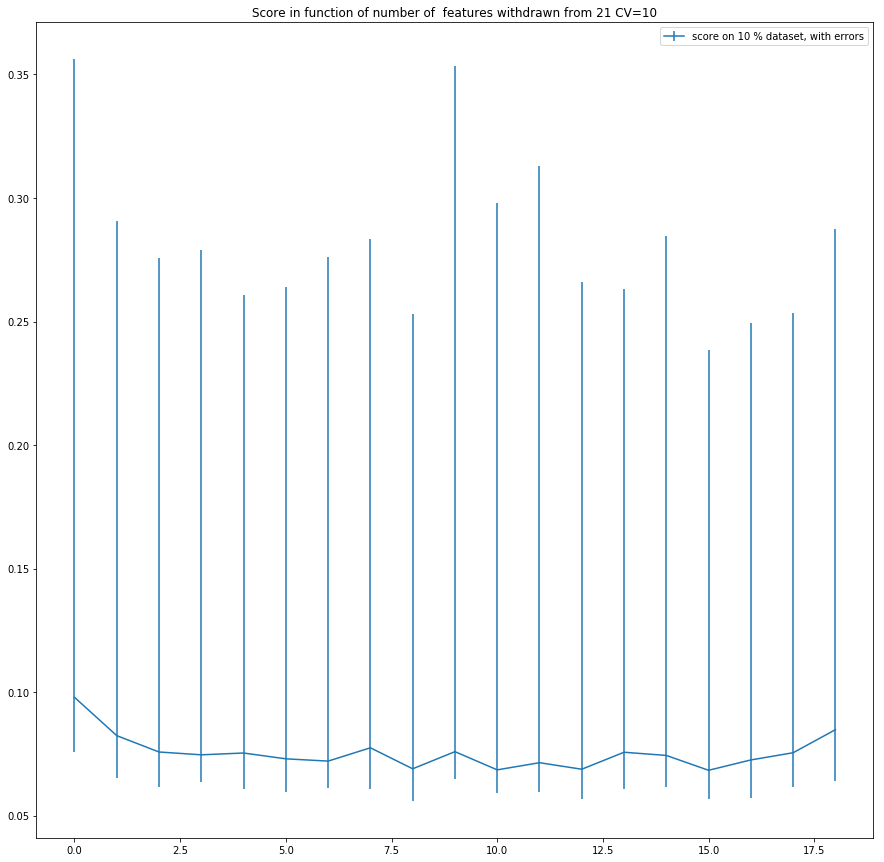

In [54]:
Moy_5 = np.mean(fr_f_5, axis=1)
Max_5 = np.max(fr_f_5, axis=1)
Min_5 = np.min(fr_f_5, axis=1)
MinMax_5 = np.zeros((2,Moy.shape[0]))
MinMax_5[0,:]=Min_5
MinMax_5[1,:]=Max_5
#plot mean FRR with errors
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(range(ColToKeepPolyLasso.shape[0]-2))
y = Moy



# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(15,15))
plt.errorbar(x, y, yerr=MinMax, label='score on 10 % dataset, with errors')
plt.title("Score in function of number of  features withdrawn from 21 CV=10")
plt.legend()
plt.show()

In [57]:
print(np.argmin(y), y.min())

15 0.0683131242343


In [65]:
#let' submit the 15th
np.argsort(fr_f_5[15])

array([2, 9, 7, 0, 4, 3, 1, 6, 8, 5])

In [69]:
M = MfromFeatures(feat_weight_5[152, :], Mtable_1, 0, 21, alg_time_thr)


Score at FAR=0.01%
threshold : 20576308.8683 far : 9.91339299393e-05 frr : 0.35022039377


## Our previous method (Extra Trees) was good as we have selected the same set


In [ ]:
# let s do a grid search for optimizing this coef
parameters = {'penalty': ['l1', 'l2'], 'C' = [1e-4, 1e-2, 10], 'solver' = ['liblinear', 'saga'], 'max_iter': [1000]}
clf_gs

(1843508, 21)


/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Score at FAR=0.01%
threshold : 164497376.651 far : 9.51284233716e-05 frr : 0.0667972575906
(1843508, 21)
Score at FAR=0.01%
threshold : 282556719.343 far : 9.51284233716e-05 frr : 0.166699314398
(1843508, 21)
Score at FAR=0.01%
threshold : 74571425.316 far : 9.51284233716e-05 frr : 0.0360430950049
(1843508, 21)
Score at FAR=0.01%
threshold : 118916197.767 far : 9.51284233716e-05 frr : 0.133006856024
(1843508, 21)
Score at FAR=0.01%
threshold : 620676638.686 far : 9.51284233716e-05 frr : 0.0936336924584
(1843509, 21)
Score at FAR=0.01%
threshold : 149590937.011 far : 9.51284233716e-05 frr : 0.0858150470219
(1843509, 21)
Score at FAR=0.01%
threshold : 100879632.23 far : 9.51284233716e-05 frr : 0.146551724138
(1843509, 21)
Score at FAR=0.01%
threshold : 116707575.653 far : 9.51284233716e-05 frr : 0.193377742947
(1843510, 21)
Score at FAR=0.01%
threshold : 416713761.486 far : 9.5128899659e-05 frr : 0.3125
(1843510, 21)
Score at FAR=0.01%
threshold : 201737207.099 far : 9.5128899659e-05 frr

(1843508, 14)
Score at FAR=0.01%
threshold : 24830710.6345 far : 9.51284233716e-05 frr : 0.127717923604
(1843508, 14)
Score at FAR=0.01%
threshold : 23829981.8592 far : 9.51284233716e-05 frr : 0.0233104799216
(1843508, 14)
Score at FAR=0.01%
threshold : 22241137.1465 far : 9.51284233716e-05 frr : 0.126346718903
(1843508, 14)
Score at FAR=0.01%
threshold : 20421546.4722 far : 9.51284233716e-05 frr : 0.190205680705
(1843509, 14)
Score at FAR=0.01%
threshold : 17041183.9288 far : 9.51284233716e-05 frr : 0.0703369905956
(1843509, 14)
Score at FAR=0.01%
threshold : 19537466.8879 far : 9.51284233716e-05 frr : 0.13342476489
(1843509, 14)
Score at FAR=0.01%
threshold : 24468664.9932 far : 9.51284233716e-05 frr : 0.189067398119
(1843510, 14)
Score at FAR=0.01%
threshold : 23720779.5853 far : 9.5128899659e-05 frr : 0.251959247649
(1843510, 14)
Score at FAR=0.01%
threshold : 15955734.8146 far : 9.5128899659e-05 frr : 0.0301724137931
[ 0.05014691  0.12771792  0.02331048  0.12634672  0.19020568  0.

Score at FAR=0.01%
threshold : 26460726.7286 far : 9.51284233716e-05 frr : 0.0556317335945
(1843508, 7)
Score at FAR=0.01%
threshold : 24648910.4817 far : 9.51284233716e-05 frr : 0.196865817826
(1843508, 7)
Score at FAR=0.01%
threshold : 16516043.0096 far : 9.51284233716e-05 frr : 0.0750244857982
(1843509, 7)
Score at FAR=0.01%
threshold : 18476176.1571 far : 9.51284233716e-05 frr : 0.183581504702
(1843509, 7)
Score at FAR=0.01%
threshold : 20078476.2398 far : 9.51284233716e-05 frr : 0.180054858934
(1843509, 7)
Score at FAR=0.01%
threshold : 22371934.046 far : 9.51284233716e-05 frr : 0.144396551724
(1843510, 7)
Score at FAR=0.01%
threshold : 21649244.2735 far : 9.5128899659e-05 frr : 0.230407523511
(1843510, 7)
Score at FAR=0.01%
threshold : 19217451.1864 far : 9.5128899659e-05 frr : 0.24079153605
[ 0.25445642  0.15259549  0.05563173  0.19686582  0.07502449  0.1835815
  0.18005486  0.14439655  0.23040752  0.24079154]
(1843508, 6)
Score at FAR=0.01%
threshold : 23165351.5447 far : 9.512

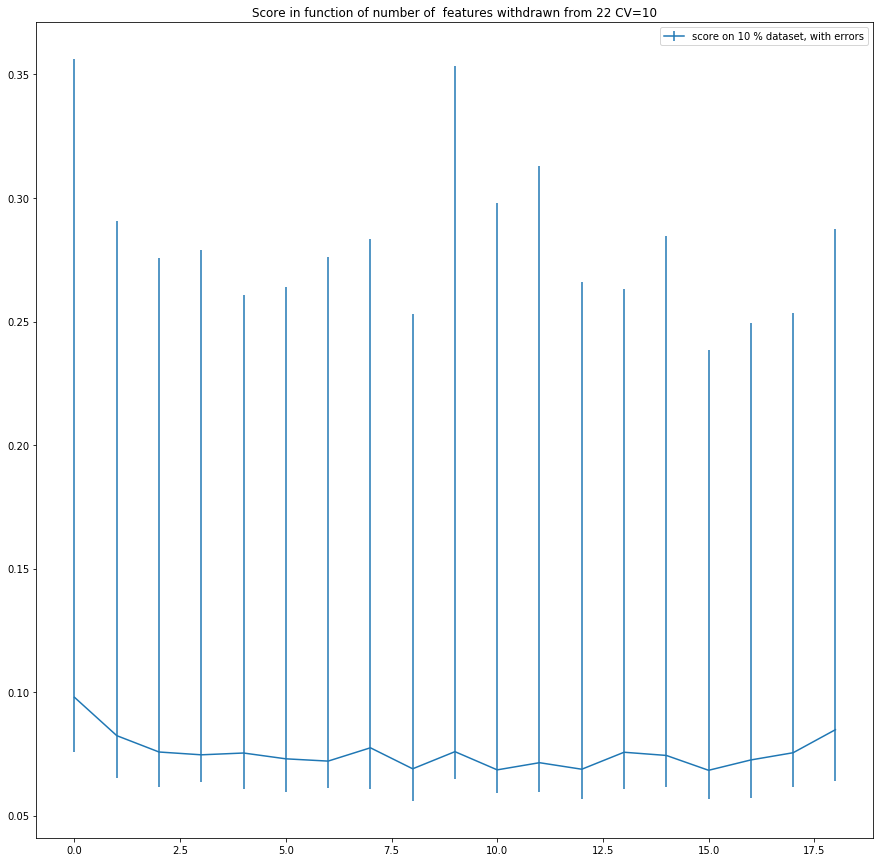

In [60]:
from sklearn.linear_model import Perceptron
clf_per = Perceptron(n_jobs=-1, tol=1e-4)
fr_f_6 = np.zeros(((ColToKeepPolyLasso.shape[0]-2),10), dtype=float)
feat_weight_6 = np.zeros((10 * (ColToKeepPolyLasso.shape[0]-2), ColToKeepPolyLasso.shape[0]))
Mf_l=[]
# Cross Validation 10

for j in range(ColToKeepPolyLasso.shape[0]-2):
    for i in range(10):
        Min=0
        Xtrain = X_pol[train_index[i]]
        Xtrain_f = Xtrain[:,ColToKeepPolyLasso[j:]]
        print(Xtrain_f.shape)
        del Xtrain
        Ytrain = Y.values[train_index[i]]
        Ytest = Y.values[test_index[i]]
        clf_per.fit(Xtrain_f, Ytrain)
        feat_weight[i + 10 * j, j:] = np.asarray(clf_per.coef_)[:]
        Mf=MfromFeatures(np.asarray(clf_per.coef_),Mtable_1,j,21, alg_time_thr)
        thr, fa, fr = evalModel(returnFuseVect(
            Mf, Y.iloc[test_index[i]], CompData.iloc[test_index[i], :]))
        fr_f[j,i]=fr
    print(fr_f[j,:])



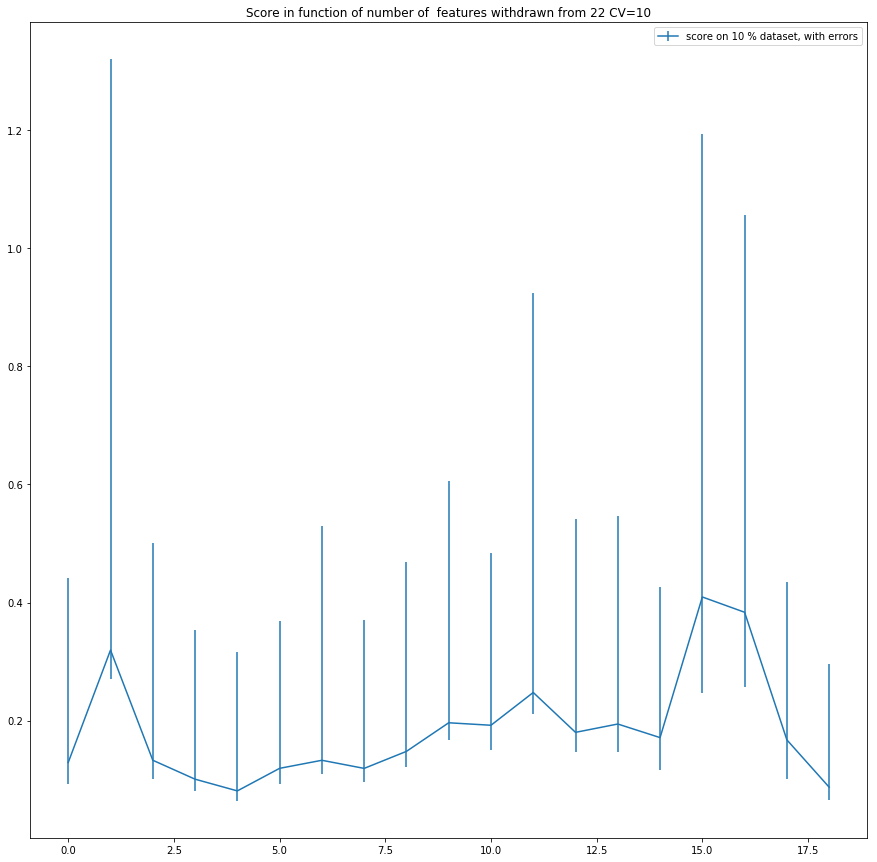

In [74]:
Moy_6 = np.mean(fr_f, axis=1)
Max_6 = np.max(fr_f, axis=1)
Min_6 = np.min(fr_f, axis=1)
MinMax_6 = np.zeros((2,Moy.shape[0]))
MinMax_6[0,:]=Min_6
MinMax_6[1,:]=Max_6

#plot mean FRR with errors
import numpy as np
import matplotlib.pyplot as plt


x = np.asarray(range(ColToKeepPolyLasso.shape[0]-2))
y = Moy_6



# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(15,15))
plt.errorbar(x, y, yerr=MinMax_6, label='score on 10 % dataset, with errors')
plt.title("Score in function of number of  features withdrawn from 22 CV=10")
plt.legend()
plt.show()

In [75]:
print(np.argmin(y), y.min())

4 0.0811849706324


## This is not the same set as before i have no time to explore it further

In [77]:
np.argsort(fr_f[4])

array([9, 5, 2, 0, 4, 3, 6, 1, 7, 8])

In [80]:
M = MfromFeatures(feat_weight[49, :], Mtable_1, 0, 21, alg_time_thr)
print(MeanScoreCV(M,10))
np.savetxt('M_pred_P' +'_.txt', M, fmt='%f')

Score at FAR=0.01%
threshold : 18923609.8257 far : 9.51284233716e-05 frr : 0.0417238001959
Score at FAR=0.01%
threshold : 26888454.5579 far : 9.51284233716e-05 frr : 0.144564152791
Score at FAR=0.01%
threshold : 25405153.1057 far : 9.51284233716e-05 frr : 0.0256611165524
Score at FAR=0.01%
threshold : 22969993.8692 far : 9.51284233716e-05 frr : 0.101469147894
Score at FAR=0.01%
threshold : 16261525.722 far : 9.51284233716e-05 frr : 0.0550440744368
Score at FAR=0.01%
threshold : 17250817.4508 far : 9.51284233716e-05 frr : 0.0223354231975
Score at FAR=0.01%
threshold : 20319695.8908 far : 9.51284233716e-05 frr : 0.0887539184953
Score at FAR=0.01%
threshold : 26096864.7643 far : 9.51284233716e-05 frr : 0.149294670846
Score at FAR=0.01%
threshold : 24559398.4662 far : 9.5128899659e-05 frr : 0.203369905956
Score at FAR=0.01%
threshold : 15638466.2881 far : 9.5128899659e-05 frr : 0.0176332288401
##done:  0.0849849439206
0.0849849439206


In [81]:
#let s do a grid search for optimizing this coef
parameters = {'penalty': [None, 'l2','l1','elasticnet'],  'tol':[1e-5, 1e-4]}
clf_gs = GridSearchCV(clf_per, param_grid=parameters, cv=10)
clf_gs.fit(X_pol[:,ColToKeepPolyLasso],Y.values)

GridSearchCV(cv=10, error_score='raise',
       estimator=Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=-1, penalty=None, random_state=0,
      shuffle=True, tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': [None, 'l2', 'l1', 'elasticnet'], 'tol': [1e-05, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [82]:
clf_gs.best_estimator_

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=-1, penalty='l2', random_state=0,
      shuffle=True, tol=1e-05, verbose=0, warm_start=False)

In [83]:
clf_gs.best_score_

0.99450677938216403

In [85]:
M = MfromFeatures(clf_gs.best_estimator_.coef_, Mtable_1, 0, 21, alg_time_thr)
print(MeanScoreCV(M,10))
np.savetxt('M_pred_P' +'_.txt', M, fmt='%f')

/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Score at FAR=0.01%
threshold : 15976644.0629 far : 9.51284233716e-05 frr : 0.0334965719882
Score at FAR=0.01%
threshold : 22787645.279 far : 9.51284233716e-05 frr : 0.125954946131
Score at FAR=0.01%
threshold : 21542373.6607 far : 9.51284233716e-05 frr : 0.022722820764
Score at FAR=0.01%
threshold : 19490083.0713 far : 9.51284233716e-05 frr : 0.0714985308521
Score at FAR=0.01%
threshold : 13851261.9224 far : 9.51284233716e-05 frr : 0.0497551420176
Score at FAR=0.01%
threshold : 14596784.2128 far : 9.51284233716e-05 frr : 0.0152821316614
Score at FAR=0.01%
threshold : 16781123.384 far : 9.51284233716e-05 frr : 0.0697492163009
Score at FAR=0.01%
threshold : 22761796.572 far : 9.51284233716e-05 frr : 0.149882445141
Score at FAR=0.01%
threshold : 22529816.8561 far : 9.5128899659e-05 frr : 0.264890282132
Score at FAR=0.01%
threshold : 13348646.8691 far : 9.5128899659e-05 frr : 0.0144984326019
##done:  0.081773051959
0.081773051959
